# Predictive Analysis of Sea Surface Currents Velocity 'u' (East-West)

This Notebook is an analysis and prediction of sea surface currents (SSC) velocity using an GRU Model. The primary focus is on processing, visualizing, and predicting based on historical sea surface current data. This pipeline aims to provide a comprehensive workflow from data processing to real-life future predictions, facilitating deeper insights into sea surface currents and their potential impacts.

## Overview
- **Data Preparation**: Loading and cleaning of time-series data from NetCDF files to create a structured dataset suitable for analysis.
- **Geospatial Visualization**: Mapping sea surface current data and identify areas of interest.
- **Data Filtering**: Narrowing down the dataset to focus on specific geographic regions and time frames for detailed analysis.
- **Predictive Modeling**: Developing GRU models to forecast future sea surface current velocities based on historical data.
- **Evaluation**: Comparing predicted values against actual data to assess the accuracy and effectiveness of the models.
- **Output**: Aggregating all predictions and converting them into a format suitable for further analysis or integration into a Lagrangian Model.

### Import Necessary Libraries

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError
from keras.models import load_model

### Suppress Future Warnings

In [2]:
import warnings

# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Importing & Opening the Data

Load and open the sea surface current dataset for subsequent analysis and modeling. This file has hourly data from 1st January 2020 till 1st August 2023

In [3]:
# Load the dataset
netcdf_file_path = "Data/model_IO/final_SSC_Data.nc"

# Open the dataset
dataset = xr.open_dataset(netcdf_file_path)

### Data Preparation 

1. **Conversion and Index Resetting**: The dataset is converted to a Pandas DataFrame and the index is reset.
2. **Column Removal**: Unnecessary columns ('stdu', 'stdv', 'cov', 'velo', 'head') that are not needed are removed.
3. **NaN Value Removal**: Rows containing NaN values in the 'u' and 'v' columns are removed.
4. **Datetime Conversion**: The 'time' column is converted to a datetime format.
5. **Display**: Finally, the cleaned DataFrame is displayed to verify the successful preprocessing steps.

In [4]:
# Convert the dataset to a pandas DataFrame and reset the index 
df = dataset.to_dataframe().reset_index()

# Drop unnecessary columns from the DataFrame that are not needed
df = df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

# Drop rows with NaN values in 'u' and 'v' columns to ensure data integrity for analysis
df.dropna(subset=['u', 'v'],inplace=True)

# Convert the 'time' column to datetime format for time series analysis
df.index = pd.to_datetime(df['time'], format='%d-%m-%Y %H:%M:%S')

# Display the DataFrame
df

time        lat      lon         u  \
time                                                                    
2020-02-25 15:00:00 2020-02-25 15:00:00  35.900600  14.5692  0.224436   
2020-02-25 15:00:00 2020-02-25 15:00:00  35.900600  14.6097  0.225030   
2020-02-25 15:00:00 2020-02-25 15:00:00  35.900600  14.6503  0.219380   
2020-02-25 15:00:00 2020-02-25 15:00:00  35.900600  14.6908  0.192193   
2020-02-25 15:00:00 2020-02-25 15:00:00  35.900600  15.0965 -0.088404   
...                                 ...        ...      ...       ...   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.880199  14.0419 -0.179297   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.880199  14.0824 -0.187970   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.880199  14.1230 -0.184672   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.880199  14.1635 -0.228134   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.880199  14.2041 -0.225346   

                            v  
time                           
2020-02-25 15:00:00 -0.204129  
2020-02-25 15:00:00 -0.220144  
2020-02-25 15:00:00 -0.229340  
2020-02-25 15:00:00 -0.223198  
2020-02-25 15:00:00 -0.160217  
...                       ...  
2023-08-01 23:00:00 -0.109355  
2023-08-01 23:00:00 -0.150195  
2023-08-01 23:00:00 -0.175530  
2023-08-01 23:00:00 -0.281021  
2023-08-01 23:00:00 -0.278797  

[17230832 rows x 5 columns]

### Geospatial Visualization

- **Boundaries & Interest Area**: Set the coordinates for the specific geographic boundaries and a polygon to highlight key area on the map.
- **Map Setup**: Initialize a map with features like land, coastlines, and borders for context.
- **Data Points**: Plot data points within the set boundaries to visualize the distribution of sea surface currents.
- **Highlight Area**: Draw a red polygon to emphasize the area of interest on the map.

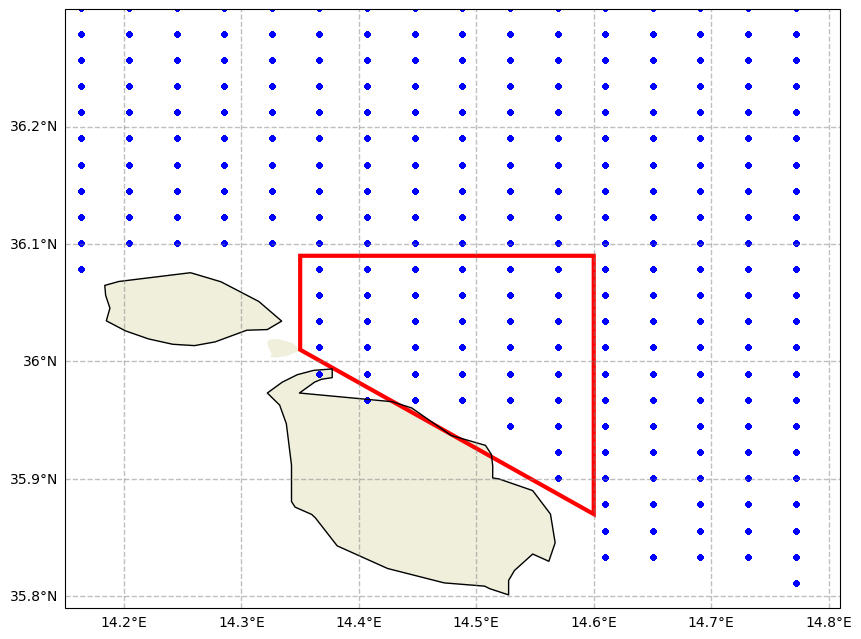

In [5]:
# Define the boundaries for the map 
boundaries = {
    'min_lon': 14.15,  
    'max_lon': 14.81,  
    'min_lat': 35.79,  
    'max_lat': 36.3    
}

# Define the vertices of a polygon to highlight a specific area on the map
polygon_coordinates = [
    (14.6, 35.87),
    (14.35, 36.01),
    (14.35, 36.09),
    (14.6, 36.09),
    (14.6, 35.87)
]

# Initialize a matplotlib figure with Cartopy for data visualization
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the viewing extent of the map using the defined boundaries
ax.set_extent([boundaries['min_lon'], boundaries['max_lon'], boundaries['min_lat'], boundaries['max_lat']], crs=ccrs.PlateCarree())

# Add features to the map for land, coastlines, and country borders for context
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot all data points from the dataframe within the defined geographic boundaries
ax.scatter(df['lon'], df['lat'], s=10, color='blue', marker='o', alpha=0.5, transform=ccrs.Geodetic())

# Draw a red polygon using the defined coordinates to highlight a specific area on the map
red_polygon = mpatches.Polygon(polygon_coordinates, closed=True, edgecolor='red', facecolor='none', linewidth=3, transform=ccrs.Geodetic())
ax.add_patch(red_polygon)

# Add gridlines to the map
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Display the plot
plt.show()

### Geospatial Filtering

Filter the dataset to focus on the area of interest:

- **Filtering**: Apply the polygon as a filter to select only data points located inside this area.
- **Visualization**: Plot the filtered data on a map to visually confirm the focus area, marking points within the polygon in red for clarity.
- **Map Features**: Enhance the map with features like land, coastlines, and borders for better context.
- **Final View**: Display the map with the filtered points.

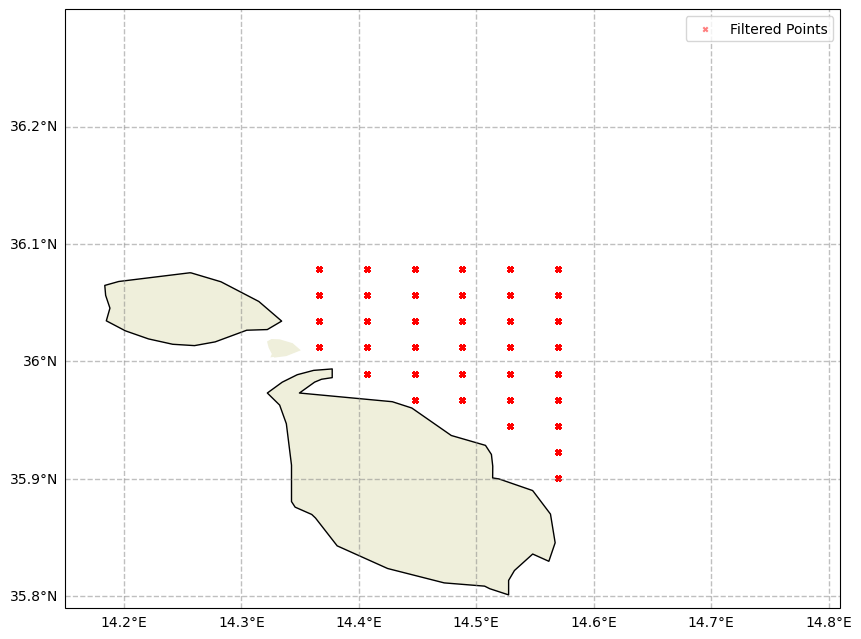

In [6]:
# Convert the list of polygon coordinates to a Path object
polygon_path = mpath.Path(polygon_coordinates)

# Use the Path object to filter points in the DataFrame that lie inside the polygon
inside_polygon = df.apply(lambda row: polygon_path.contains_point((row['lon'], row['lat'])), axis=1)
df_inside_polygon = df[inside_polygon]

# Initialize a new matplotlib figure with Cartopy for mapping, specifying the projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the extent of the map to the defined geographic boundaries
ax.set_extent([boundaries['min_lon'], boundaries['max_lon'], boundaries['min_lat'], boundaries['max_lat']], crs=ccrs.PlateCarree())

# Add land, coastlines, and country borders to the map 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the points that are located within the defined polygon in red
scatter = ax.scatter(df_inside_polygon['lon'], df_inside_polygon['lat'], s=10, color='red', marker='x', alpha=0.5, transform=ccrs.Geodetic(), label='Filtered Points')

# Add gridlines and labels to the map
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add a legend to the plot to explain the red "X" markers
ax.legend(handles=[scatter], loc='upper right')

# Display the plot
plt.show()

### Selecting the coordinates inside the polygon

Identify and processes data points located within the selected area:

- **Path Creation**: Transform the polygon coordinates into a Path object for spatial filtering.
- **Coordinate Pairing**: Combine 'lon' and 'lat' from the DataFrame into coordinate tuples.
- **Spatial Filtering**: Apply the Path object to select only points inside the polygon.
- **Duplicate Removal**: Eliminate duplicate points to ensure unique data entries.
- **Count and Display**: Calculate and print the total number of unique points inside the polygon, along with their coordinates.

In [7]:
# Convert the polygon coordinates to a Path object 
polygon_path = mpath.Path(polygon_coordinates)

# Combine longitude and latitude columns from the DataFrame into a list of tuples for each point
coordinates = list(zip(df['lon'], df['lat']))

# Create a mask to identify which points fall within the defined polygon by checking each point
inside_mask = [polygon_path.contains_point(coord) for coord in coordinates]

# Use the mask to filter the DataFrame, keeping only points that are inside the polygon
df_inside_polygon = df[inside_mask]

# Remove potential duplicate entries based on their longitude and latitude
df_inside_polygon = df_inside_polygon.drop_duplicates(subset=['lon', 'lat'])

# Calculate the number of unique points found inside the polygon
num_points_inside_polygon = df_inside_polygon.shape[0]
print(f"Total number of points inside the polygon: {num_points_inside_polygon}\n")
print("Coordinates of the points inside the polygon:")

# Iterate over each coordinate pair inside the polygon and print them out
coordinates_inside = df_inside_polygon[['lon', 'lat']].values
for lon, lat in coordinates_inside:
    print(f"({lon}, {lat})")

Total number of points inside the polygon: 37

Coordinates of the points inside the polygon:
(14.569199562072754, 35.90060043334961)
(14.569199562072754, 35.92279815673828)
(14.569199562072754, 35.945098876953125)
(14.528599739074707, 35.96730041503906)
(14.569199562072754, 35.96730041503906)
(14.447500228881836, 35.989601135253906)
(14.48799991607666, 35.989601135253906)
(14.528599739074707, 35.989601135253906)
(14.569199562072754, 35.989601135253906)
(14.447500228881836, 36.01190185546875)
(14.48799991607666, 36.01190185546875)
(14.528599739074707, 36.01190185546875)
(14.569199562072754, 36.01190185546875)
(14.447500228881836, 36.03409957885742)
(14.48799991607666, 36.03409957885742)
(14.528599739074707, 36.03409957885742)
(14.569199562072754, 36.03409957885742)
(14.447500228881836, 36.056400299072266)
(14.48799991607666, 36.056400299072266)
(14.528599739074707, 36.056400299072266)
(14.569199562072754, 36.056400299072266)
(14.366399765014648, 36.07870101928711)
(14.406900405883789, 3

### Create a Data Frame for the coordinates inside the polygon

In [8]:
# Convert 'inside_mask' to a pandas Series to use as a boolean indexer
inside_series = pd.Series(inside_mask, index=df.index)

# Filter the original DataFrame using the boolean Series
final_df = df[inside_series]

# Display the final DataFrame
final_df

time        lat      lon         u  \
time                                                                    
2020-02-25 15:00:00 2020-02-25 15:00:00  35.900600  14.5692  0.224436   
2020-02-25 15:00:00 2020-02-25 15:00:00  35.922798  14.5692  0.209744   
2020-02-25 15:00:00 2020-02-25 15:00:00  35.945099  14.5692  0.165433   
2020-02-25 15:00:00 2020-02-25 15:00:00  35.967300  14.5286  0.139062   
2020-02-25 15:00:00 2020-02-25 15:00:00  35.967300  14.5692  0.162474   
...                                 ...        ...      ...       ...   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.078701  14.4069  0.148599   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.078701  14.4475  0.153244   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.078701  14.4880  0.165081   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.078701  14.5286  0.169408   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.078701  14.5692  0.178463   

                            v  
time                           
2020-02-25 15:00:00 -0.204129  
2020-02-25 15:00:00 -0.180382  
2020-02-25 15:00:00 -0.158304  
2020-02-25 15:00:00 -0.155931  
2020-02-25 15:00:00 -0.140758  
...                       ...  
2023-08-01 23:00:00 -0.234722  
2023-08-01 23:00:00 -0.216512  
2023-08-01 23:00:00 -0.183771  
2023-08-01 23:00:00 -0.206215  
2023-08-01 23:00:00 -0.222228  

[366357 rows x 5 columns]

### Data Extraction for Selected Coordinates

Extracting and saving specific sea surface current data for predefined locations within our area of interest:

- **Selected Coordinates**: List the specific latitude and longitude pairs.
- **Data Extraction**: For each pair, filter the main dataset to obtain the relevant data points.
- **File Saving**: Convert latitude and longitude to a format suitable for filenames and save the data as CSV files.

Each data point's latitude and longitude are converted to remove decimal points, ensuring valid filenames. This process results in a set of CSV files, each corresponding to a unique location within the selected polygon.

In [9]:
# Directory to save the files
save_directory = "Data/coordinate_data_frames"
os.makedirs(save_directory, exist_ok=True)

# Coordinates of the points inside the polygon
coordinates_inside = [
    (14.569199562072754, 35.90060043334961),
    (14.569199562072754, 35.92279815673828),
    (14.569199562072754, 35.945098876953125),
    (14.528599739074707, 35.96730041503906),
    (14.569199562072754, 35.96730041503906),
    (14.447500228881836, 35.989601135253906),
    (14.48799991607666, 35.989601135253906),
    (14.528599739074707, 35.989601135253906),
    (14.569199562072754, 35.989601135253906),
    (14.447500228881836, 36.01190185546875),
    (14.48799991607666, 36.01190185546875),
    (14.528599739074707, 36.01190185546875),
    (14.569199562072754, 36.01190185546875),
    (14.447500228881836, 36.03409957885742),
    (14.48799991607666, 36.03409957885742),
    (14.528599739074707, 36.03409957885742),
    (14.569199562072754, 36.03409957885742),
    (14.447500228881836, 36.056400299072266),
    (14.48799991607666, 36.056400299072266),
    (14.528599739074707, 36.056400299072266),
    (14.569199562072754, 36.056400299072266),
    (14.366399765014648, 36.07870101928711),
    (14.406900405883789, 36.07870101928711),
    (14.447500228881836, 36.07870101928711),
    (14.48799991607666, 36.07870101928711),
    (14.528599739074707, 36.07870101928711),
    (14.569199562072754, 36.07870101928711),
    (14.528599739074707, 35.945098876953125),
    (14.406900405883789, 36.03409957885742),
    (14.406900405883789, 36.056400299072266),
    (14.406900405883789, 36.01190185546875),
    (14.366399765014648, 36.03409957885742),
    (14.366399765014648, 36.056400299072266),
    (14.48799991607666, 35.96730041503906),
    (14.406900405883789, 35.989601135253906,),
    (14.366399765014648, 36.01190185546875),
    (14.447500228881836, 35.96730041503906)
]

# Loop through each pair of coordinates along with an index
for index, (lon, lat) in enumerate(coordinates_inside, start=1):
    # Print the current pair being processed
    print(f"Processing pair {index}: (lat: {lat}, lon: {lon})")

    # Filter the DataFrame for the exact coordinates
    df_point = final_df[(final_df['lat'] == lat) & (final_df['lon'] == lon)]

    # Check if any data points were found for the current pair
    if df_point.empty:
        print(f"No data points found for (lat: {lat}, lon: {lon})")
    else:
        print(f"Found {df_point.shape[0]} data points for (lat: {lat}, lon: {lon})")

    # Format the latitude and longitude to remove decimal points and replace with underscores
    lat_formatted = str(lat).replace('.', '_')
    lon_formatted = str(lon).replace('.', '_')

    # Create a unique filename for each pair of coordinates
    filename = f"{index}_{lat_formatted}_{lon_formatted}.csv"
    filepath = os.path.join(save_directory, filename)

    # Save the filtered DataFrame to a CSV file
    df_point.to_csv(filepath, index=False)

    # Confirm that the file has been saved
    print(f"Saved data for (lat: {lat}, lon: {lon}) as {filename}\n")

print("All data processing complete.")
print("="*175)

Processing pair 1: (lat: 35.90060043334961, lon: 14.569199562072754)
Found 6694 data points for (lat: 35.90060043334961, lon: 14.569199562072754)
Saved data for (lat: 35.90060043334961, lon: 14.569199562072754) as 1_35_90060043334961_14_569199562072754.csv

Processing pair 2: (lat: 35.92279815673828, lon: 14.569199562072754)
Found 6804 data points for (lat: 35.92279815673828, lon: 14.569199562072754)
Saved data for (lat: 35.92279815673828, lon: 14.569199562072754) as 2_35_92279815673828_14_569199562072754.csv

Processing pair 3: (lat: 35.945098876953125, lon: 14.569199562072754)
Found 8293 data points for (lat: 35.945098876953125, lon: 14.569199562072754)
Saved data for (lat: 35.945098876953125, lon: 14.569199562072754) as 3_35_945098876953125_14_569199562072754.csv

Processing pair 4: (lat: 35.96730041503906, lon: 14.528599739074707)
Found 9458 data points for (lat: 35.96730041503906, lon: 14.528599739074707)
Saved data for (lat: 35.96730041503906, lon: 14.528599739074707) as 4_35_967

### Model Preparation, Training & Evaluation

- **Model Storage**: Set up a directory to save the trained models.
- **Data Preparation**: List and load all coordinate-specific CSV files that were prepared earlier.
- **Feature Selection**: For each dataset, 'u' and 'v' values are chosen as features with 'u' set as the target variable.
- **Time Series Generation**: Construct time series generators, utilizing the last 72 hours (3 days) of data to predict the 'u' value for the next hour. This historical data frame helps the model understand temporal patterns.
- **Early Stopping**: Integrate early stopping to halt training when the validation loss stops improving, preventing overfitting and saving computational resources.
- **Model Architecture**: Build the GRU (Gated Recurrent Units) network. The model architecture includes several layers with dropout rates to manage overfitting.
- **Training Process**: Train the model on the generated time series data, monitoring both training and validation metrics.
- **Prediction and Evaluation**:
    - **Prediction**: After training, apply the model to the test set to forecast future 'u' values.
    - **Evaluation Metrics**: Use three key metrics to evaluate model performance:
        - **Mean Squared Error (MSE)**: Represents the average of the squares of the errors between actual and predicted values. Lower values indicate better performance.
        - **Mean Absolute Error (MAE)**: Measures the average magnitude of errors between pairs of actual and predicted values, without considering their direction. Lower MAE values signify better accuracy.
        - **Root Mean Squared Error (RMSE)**: The square root of MSE, providing error metrics in the same units as the data, making interpretation straightforward. Lower RMSE values denote better fit.
    - **Visualization**: Plot actual vs. predicted 'u' values to visually assess the model's prediction accuracy and understand its real-world applicability.

['1_35_90060043334961_14_569199562072754.csv', '2_35_92279815673828_14_569199562072754.csv', '3_35_945098876953125_14_569199562072754.csv', '4_35_96730041503906_14_528599739074707.csv', '5_35_96730041503906_14_569199562072754.csv', '6_35_989601135253906_14_447500228881836.csv', '7_35_989601135253906_14_48799991607666.csv', '8_35_989601135253906_14_528599739074707.csv', '9_35_989601135253906_14_569199562072754.csv', '10_36_01190185546875_14_447500228881836.csv', '11_36_01190185546875_14_48799991607666.csv', '12_36_01190185546875_14_528599739074707.csv', '13_36_01190185546875_14_569199562072754.csv', '14_36_03409957885742_14_447500228881836.csv', '15_36_03409957885742_14_48799991607666.csv', '16_36_03409957885742_14_528599739074707.csv', '17_36_03409957885742_14_569199562072754.csv', '18_36_056400299072266_14_447500228881836.csv', '19_36_056400299072266_14_48799991607666.csv', '20_36_056400299072266_14_528599739074707.csv', '21_36_056400299072266_14_569199562072754.csv', '22_36_078701019

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 44s 553ms/step - loss: 0.0112 - mean_absolute_error: 0.0832 - val_loss: 0.0086 - val_mean_absolute_error: 0.0684
Epoch 2/100
73/73 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0639INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 37s 503ms/step - loss: 0.0071 - mean_absolute_error: 0.0639 - val_loss: 0.0054 - val_mean_absolute_error: 0.0493
Epoch 3/100
73/73 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0501INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 35s 476ms/step - loss: 0.0048 - mean_absolute_error: 0.0501 - val_loss: 0.0045 - val_mean_absolute_error: 0.0419
Epoch 4/100
73/73 [==============================] - 33s 447ms/step - loss: 0.0043 - mean_absolute_error: 0.0462 - val_loss: 0.0045 - val_mean_absolute_error: 0.0410
Epoch 5/100
73/73 [==============================] - 30s 415ms/step - loss: 0.0046 - mean_absolute_error: 0.0474 - val_loss: 0.0045 - val_mean_absolute_error: 0.0419
Epoch 6/100
73/73 [==============================] - 30s 405ms/step - loss: 0.0039 - mean_absolute_error: 0.0430 - val_loss: 0.0047 - val_mean_absolute_error: 0.0439
Epoch 7/100
73/73 [==============================] - 29s 395ms/step - loss: 0.0039 - mean_absolute_error: 0.0438 - val_loss: 0.0045 - val_mean_absolute_error: 0.0398
Epoch 8/100
73/73 [==============================] - 28s 385ms/step - loss: 0.0038 - mean_absolute_error: 0.0424 - val_loss: 0.0046 - val_mean_absolute_error: 0.0417
Epoch 9/100
73/7

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 34s 473ms/step - loss: 0.0038 - mean_absolute_error: 0.0425 - val_loss: 0.0043 - val_mean_absolute_error: 0.0379
Epoch 10/100
73/73 [==============================] - 35s 484ms/step - loss: 0.0039 - mean_absolute_error: 0.0434 - val_loss: 0.0043 - val_mean_absolute_error: 0.0389
Epoch 11/100
73/73 [==============================] - 31s 431ms/step - loss: 0.0042 - mean_absolute_error: 0.0456 - val_loss: 0.0044 - val_mean_absolute_error: 0.0398
Epoch 12/100
73/73 [==============================] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.0412INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 36s 488ms/step - loss: 0.0037 - mean_absolute_error: 0.0412 - val_loss: 0.0041 - val_mean_absolute_error: 0.0381
Epoch 13/100
73/73 [==============================] - ETA: 0s - loss: 0.0036 - mean_absolute_error: 0.0414INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 40s 544ms/step - loss: 0.0036 - mean_absolute_error: 0.0414 - val_loss: 0.0041 - val_mean_absolute_error: 0.0375
Epoch 14/100
73/73 [==============================] - 46s 627ms/step - loss: 0.0036 - mean_absolute_error: 0.0409 - val_loss: 0.0042 - val_mean_absolute_error: 0.0380
Epoch 15/100
73/73 [==============================] - ETA: 0s - loss: 0.0035 - mean_absolute_error: 0.0402INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 49s 668ms/step - loss: 0.0035 - mean_absolute_error: 0.0402 - val_loss: 0.0041 - val_mean_absolute_error: 0.0374
Epoch 16/100
73/73 [==============================] - 73s 1s/step - loss: 0.0035 - mean_absolute_error: 0.0403 - val_loss: 0.0045 - val_mean_absolute_error: 0.0417
Epoch 17/100
73/73 [==============================] - ETA: 0s - loss: 0.0033 - mean_absolute_error: 0.0392INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 78s 1s/step - loss: 0.0033 - mean_absolute_error: 0.0392 - val_loss: 0.0040 - val_mean_absolute_error: 0.0366
Epoch 18/100
73/73 [==============================] - 68s 933ms/step - loss: 0.0038 - mean_absolute_error: 0.0425 - val_loss: 0.0045 - val_mean_absolute_error: 0.0418
Epoch 19/100
73/73 [==============================] - 65s 892ms/step - loss: 0.0032 - mean_absolute_error: 0.0387 - val_loss: 0.0041 - val_mean_absolute_error: 0.0381
Epoch 20/100
73/73 [==============================] - 65s 896ms/step - loss: 0.0033 - mean_absolute_error: 0.0387 - val_loss: 0.0045 - val_mean_absolute_error: 0.0413
Epoch 21/100
73/73 [==============================] - 66s 902ms/step - loss: 0.0033 - mean_absolute_error: 0.0386 - val_loss: 0.0058 - val_mean_absolute_error: 0.0499
Epoch 22/100
73/73 [==============================] - 66s 902ms/step - loss: 0.0034 - mean_absolute_error: 0.0406 - val_loss: 0.0042 - val_mean_absolute_error: 0.0391
Epoch 23/100
7

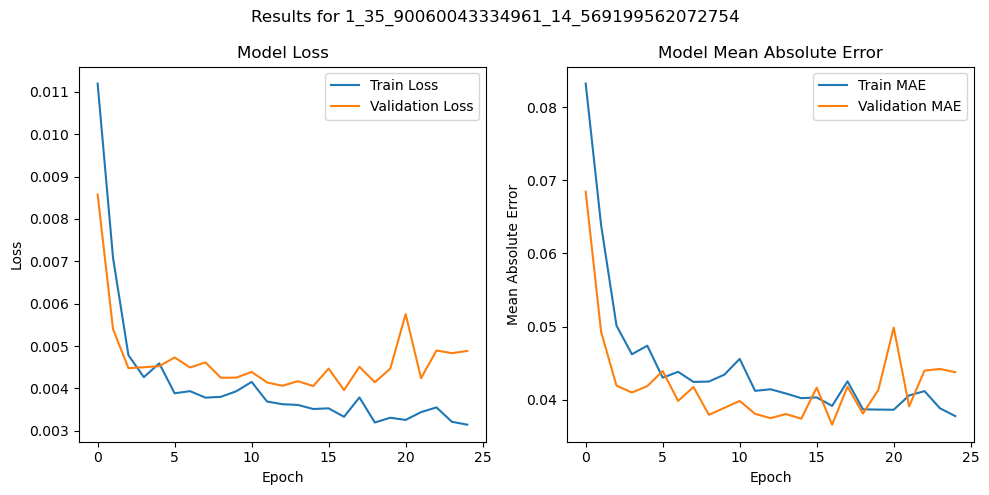

15/15 [==============================] - 3s 164ms/step

Test set Evaluation metrics for file: 1_35_90060043334961_14_569199562072754
Mean Squared Error (MSE): 0.00253946692701893
Mean Absolute Error (MAE): 0.03259352261040934
Root Mean Squared Error (RMSE): 0.05039312380691368



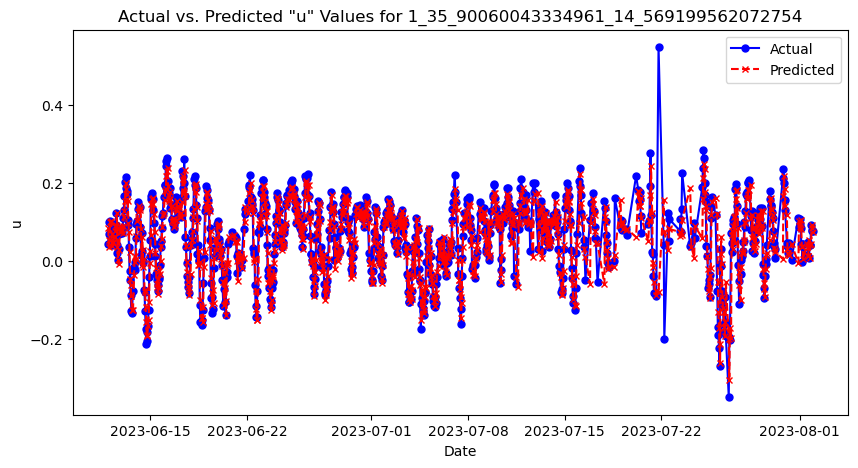

Model tarining & evaluation completed for file: 1_35_90060043334961_14_569199562072754.csv

Processing file: 2_35_92279815673828_14_569199562072754.csv

Epoch 1/100
74/74 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0772INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 71s 916ms/step - loss: 0.0095 - mean_absolute_error: 0.0772 - val_loss: 0.0087 - val_mean_absolute_error: 0.0685
Epoch 2/100
74/74 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0559INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 72s 979ms/step - loss: 0.0056 - mean_absolute_error: 0.0559 - val_loss: 0.0056 - val_mean_absolute_error: 0.0516
Epoch 3/100
74/74 [==============================] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.0473INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 72s 978ms/step - loss: 0.0043 - mean_absolute_error: 0.0473 - val_loss: 0.0047 - val_mean_absolute_error: 0.0420
Epoch 4/100
74/74 [==============================] - 66s 895ms/step - loss: 0.0038 - mean_absolute_error: 0.0438 - val_loss: 0.0048 - val_mean_absolute_error: 0.0413
Epoch 5/100
74/74 [==============================] - 67s 902ms/step - loss: 0.0038 - mean_absolute_error: 0.0426 - val_loss: 0.0049 - val_mean_absolute_error: 0.0429
Epoch 6/100
74/74 [==============================] - 68s 915ms/step - loss: 0.0038 - mean_absolute_error: 0.0427 - val_loss: 0.0048 - val_mean_absolute_error: 0.0427
Epoch 7/100
74/74 [==============================] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.0425INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 71s 960ms/step - loss: 0.0037 - mean_absolute_error: 0.0425 - val_loss: 0.0047 - val_mean_absolute_error: 0.0404
Epoch 8/100
74/74 [==============================] - 68s 921ms/step - loss: 0.0037 - mean_absolute_error: 0.0418 - val_loss: 0.0047 - val_mean_absolute_error: 0.0405
Epoch 9/100
74/74 [==============================] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.0421INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 79s 1s/step - loss: 0.0037 - mean_absolute_error: 0.0421 - val_loss: 0.0045 - val_mean_absolute_error: 0.0396
Epoch 10/100
74/74 [==============================] - 72s 977ms/step - loss: 0.0033 - mean_absolute_error: 0.0395 - val_loss: 0.0047 - val_mean_absolute_error: 0.0418
Epoch 11/100
74/74 [==============================] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.0400INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 77s 1s/step - loss: 0.0034 - mean_absolute_error: 0.0400 - val_loss: 0.0045 - val_mean_absolute_error: 0.0405
Epoch 12/100
74/74 [==============================] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.0397INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 78s 1s/step - loss: 0.0034 - mean_absolute_error: 0.0397 - val_loss: 0.0044 - val_mean_absolute_error: 0.0392
Epoch 13/100
74/74 [==============================] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.0399INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 79s 1s/step - loss: 0.0034 - mean_absolute_error: 0.0399 - val_loss: 0.0044 - val_mean_absolute_error: 0.0387
Epoch 14/100
74/74 [==============================] - 73s 983ms/step - loss: 0.0033 - mean_absolute_error: 0.0392 - val_loss: 0.0044 - val_mean_absolute_error: 0.0396
Epoch 15/100
74/74 [==============================] - ETA: 0s - loss: 0.0033 - mean_absolute_error: 0.0394INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 78s 1s/step - loss: 0.0033 - mean_absolute_error: 0.0394 - val_loss: 0.0043 - val_mean_absolute_error: 0.0409
Epoch 16/100
74/74 [==============================] - 74s 1s/step - loss: 0.0031 - mean_absolute_error: 0.0384 - val_loss: 0.0045 - val_mean_absolute_error: 0.0397
Epoch 17/100
74/74 [==============================] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.0401INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 81s 1s/step - loss: 0.0034 - mean_absolute_error: 0.0401 - val_loss: 0.0043 - val_mean_absolute_error: 0.0386
Epoch 18/100
74/74 [==============================] - 73s 992ms/step - loss: 0.0032 - mean_absolute_error: 0.0383 - val_loss: 0.0046 - val_mean_absolute_error: 0.0415
Epoch 19/100
74/74 [==============================] - 72s 978ms/step - loss: 0.0032 - mean_absolute_error: 0.0383 - val_loss: 0.0046 - val_mean_absolute_error: 0.0425
Epoch 20/100
74/74 [==============================] - 73s 987ms/step - loss: 0.0031 - mean_absolute_error: 0.0386 - val_loss: 0.0046 - val_mean_absolute_error: 0.0409
Epoch 21/100
74/74 [==============================] - 77s 1s/step - loss: 0.0031 - mean_absolute_error: 0.0381 - val_loss: 0.0046 - val_mean_absolute_error: 0.0403
Epoch 22/100
74/74 [==============================] - 76s 1s/step - loss: 0.0031 - mean_absolute_error: 0.0377 - val_loss: 0.0044 - val_mean_absolute_error: 0.0397
Epoch 23/100
74/74 [

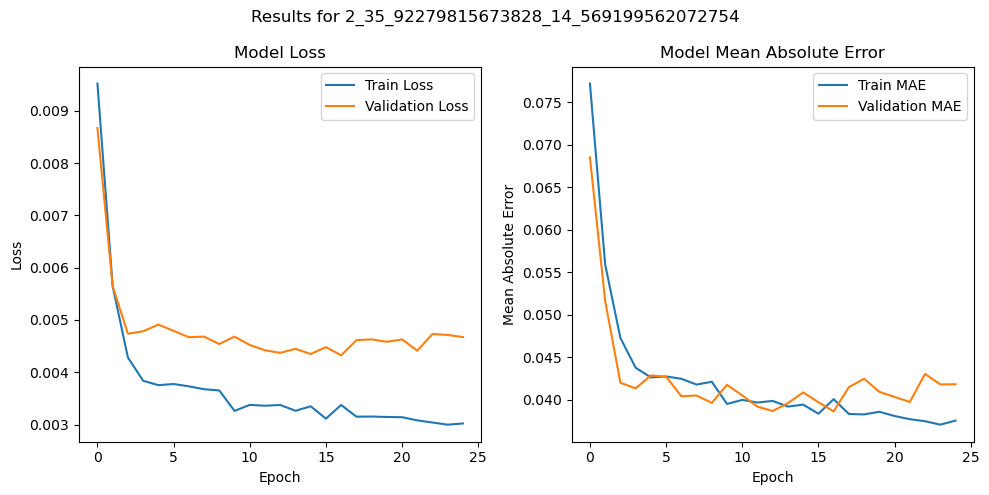

15/15 [==============================] - 3s 180ms/step

Test set Evaluation metrics for file: 2_35_92279815673828_14_569199562072754
Mean Squared Error (MSE): 0.0023723598019698487
Mean Absolute Error (MAE): 0.03351701640548878
Root Mean Squared Error (RMSE): 0.04870687633147756



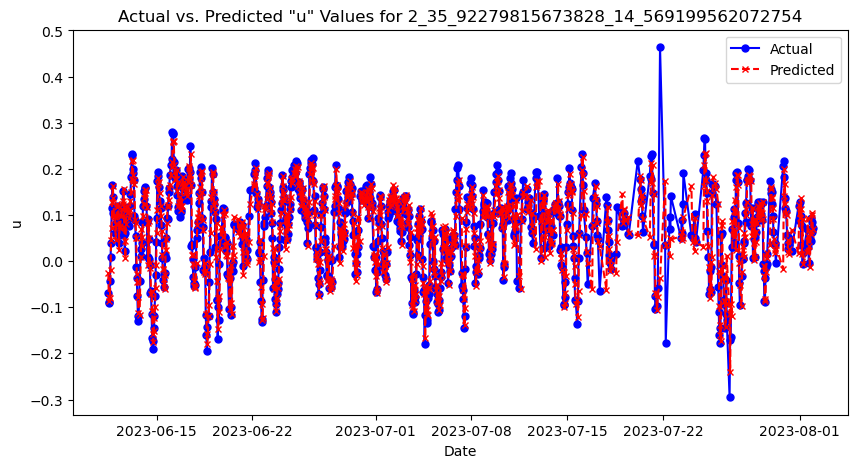

Model tarining & evaluation completed for file: 2_35_92279815673828_14_569199562072754.csv

Processing file: 3_35_945098876953125_14_569199562072754.csv

Epoch 1/100
90/90 [==============================] - ETA: 0s - loss: 0.0115 - mean_absolute_error: 0.0845INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\3_35_945098876953125_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 91s 965ms/step - loss: 0.0115 - mean_absolute_error: 0.0845 - val_loss: 0.0079 - val_mean_absolute_error: 0.0699
Epoch 2/100
90/90 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0594INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\3_35_945098876953125_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 97s 1s/step - loss: 0.0064 - mean_absolute_error: 0.0594 - val_loss: 0.0046 - val_mean_absolute_error: 0.0471
Epoch 3/100
90/90 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0514INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\3_35_945098876953125_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 96s 1s/step - loss: 0.0051 - mean_absolute_error: 0.0514 - val_loss: 0.0044 - val_mean_absolute_error: 0.0449
Epoch 4/100
90/90 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.0482INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\3_35_945098876953125_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 98s 1s/step - loss: 0.0047 - mean_absolute_error: 0.0482 - val_loss: 0.0042 - val_mean_absolute_error: 0.0431
Epoch 5/100
90/90 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0472INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\3_35_945098876953125_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 105s 1s/step - loss: 0.0046 - mean_absolute_error: 0.0472 - val_loss: 0.0040 - val_mean_absolute_error: 0.0420
Epoch 6/100
90/90 [==============================] - 85s 946ms/step - loss: 0.0045 - mean_absolute_error: 0.0470 - val_loss: 0.0042 - val_mean_absolute_error: 0.0432
Epoch 7/100
90/90 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.0464INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\3_35_945098876953125_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 90s 1s/step - loss: 0.0045 - mean_absolute_error: 0.0464 - val_loss: 0.0040 - val_mean_absolute_error: 0.0418
Epoch 8/100
90/90 [==============================] - 93s 1s/step - loss: 0.0043 - mean_absolute_error: 0.0452 - val_loss: 0.0042 - val_mean_absolute_error: 0.0445
Epoch 9/100
90/90 [==============================] - 90s 997ms/step - loss: 0.0042 - mean_absolute_error: 0.0448 - val_loss: 0.0041 - val_mean_absolute_error: 0.0427
Epoch 10/100
90/90 [==============================] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.0441INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\3_35_945098876953125_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 94s 1s/step - loss: 0.0041 - mean_absolute_error: 0.0441 - val_loss: 0.0039 - val_mean_absolute_error: 0.0417
Epoch 11/100
90/90 [==============================] - 90s 1s/step - loss: 0.0040 - mean_absolute_error: 0.0431 - val_loss: 0.0041 - val_mean_absolute_error: 0.0428
Epoch 12/100
90/90 [==============================] - ETA: 0s - loss: 0.0039 - mean_absolute_error: 0.0428INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\3_35_945098876953125_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 96s 1s/step - loss: 0.0039 - mean_absolute_error: 0.0428 - val_loss: 0.0038 - val_mean_absolute_error: 0.0405
Epoch 13/100
90/90 [==============================] - 91s 1s/step - loss: 0.0040 - mean_absolute_error: 0.0436 - val_loss: 0.0038 - val_mean_absolute_error: 0.0408
Epoch 14/100
90/90 [==============================] - 90s 1s/step - loss: 0.0041 - mean_absolute_error: 0.0442 - val_loss: 0.0039 - val_mean_absolute_error: 0.0421
Epoch 15/100
90/90 [==============================] - ETA: 0s - loss: 0.0039 - mean_absolute_error: 0.0427INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\3_35_945098876953125_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 95s 1s/step - loss: 0.0039 - mean_absolute_error: 0.0427 - val_loss: 0.0037 - val_mean_absolute_error: 0.0403
Epoch 16/100
90/90 [==============================] - 95s 1s/step - loss: 0.0039 - mean_absolute_error: 0.0428 - val_loss: 0.0038 - val_mean_absolute_error: 0.0399
Epoch 17/100
90/90 [==============================] - 95s 1s/step - loss: 0.0039 - mean_absolute_error: 0.0422 - val_loss: 0.0038 - val_mean_absolute_error: 0.0404
Epoch 18/100
90/90 [==============================] - 100s 1s/step - loss: 0.0038 - mean_absolute_error: 0.0424 - val_loss: 0.0037 - val_mean_absolute_error: 0.0404
Epoch 19/100
90/90 [==============================] - 99s 1s/step - loss: 0.0039 - mean_absolute_error: 0.0421 - val_loss: 0.0038 - val_mean_absolute_error: 0.0410
Epoch 20/100
90/90 [==============================] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.0419INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\3_35_945098876953125

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 103s 1s/step - loss: 0.0038 - mean_absolute_error: 0.0419 - val_loss: 0.0037 - val_mean_absolute_error: 0.0401
Epoch 21/100
90/90 [==============================] - 98s 1s/step - loss: 0.0038 - mean_absolute_error: 0.0420 - val_loss: 0.0037 - val_mean_absolute_error: 0.0400
Epoch 22/100
90/90 [==============================] - 98s 1s/step - loss: 0.0037 - mean_absolute_error: 0.0411 - val_loss: 0.0040 - val_mean_absolute_error: 0.0418
Epoch 23/100
90/90 [==============================] - 98s 1s/step - loss: 0.0037 - mean_absolute_error: 0.0419 - val_loss: 0.0037 - val_mean_absolute_error: 0.0396
Epoch 24/100
90/90 [==============================] - 98s 1s/step - loss: 0.0036 - mean_absolute_error: 0.0409 - val_loss: 0.0037 - val_mean_absolute_error: 0.0399
Epoch 25/100
90/90 [==============================] - 98s 1s/step - loss: 0.0037 - mean_absolute_error: 0.0418 - val_loss: 0.0039 - val_mean_absolute_error: 0.0410
Epoch 26/100
90/90 [========

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 103s 1s/step - loss: 0.0038 - mean_absolute_error: 0.0425 - val_loss: 0.0036 - val_mean_absolute_error: 0.0390
Epoch 27/100
90/90 [==============================] - 101s 1s/step - loss: 0.0037 - mean_absolute_error: 0.0414 - val_loss: 0.0040 - val_mean_absolute_error: 0.0412
Epoch 28/100
90/90 [==============================] - 101s 1s/step - loss: 0.0036 - mean_absolute_error: 0.0410 - val_loss: 0.0038 - val_mean_absolute_error: 0.0409
Epoch 29/100
90/90 [==============================] - 101s 1s/step - loss: 0.0038 - mean_absolute_error: 0.0424 - val_loss: 0.0045 - val_mean_absolute_error: 0.0451
Epoch 30/100
90/90 [==============================] - 102s 1s/step - loss: 0.0038 - mean_absolute_error: 0.0431 - val_loss: 0.0041 - val_mean_absolute_error: 0.0427
Epoch 31/100
90/90 [==============================] - 101s 1s/step - loss: 0.0037 - mean_absolute_error: 0.0414 - val_loss: 0.0039 - val_mean_absolute_error: 0.0407
Epoch 32/100
90/90 [===

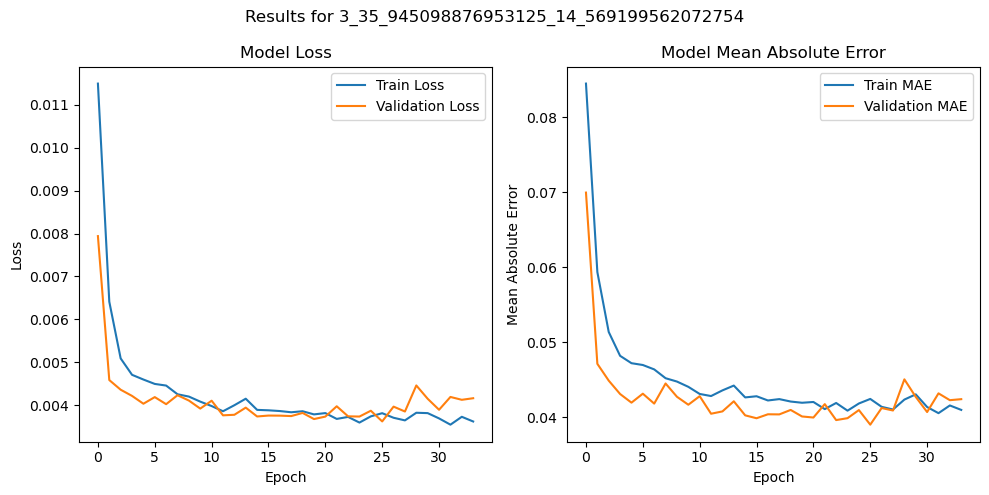

19/19 [==============================] - 5s 207ms/step

Test set Evaluation metrics for file: 3_35_945098876953125_14_569199562072754
Mean Squared Error (MSE): 0.0024968236988910622
Mean Absolute Error (MAE): 0.036890850106948724
Root Mean Squared Error (RMSE): 0.04996822689360773



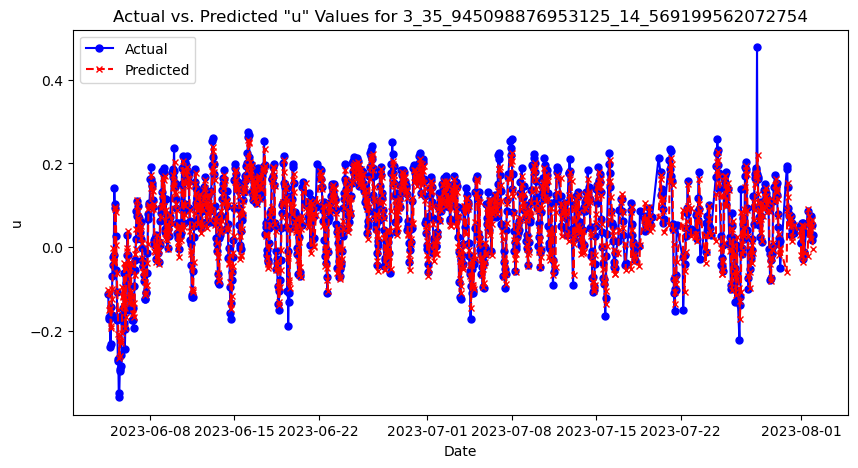

Model tarining & evaluation completed for file: 3_35_945098876953125_14_569199562072754.csv

Processing file: 4_35_96730041503906_14_528599739074707.csv

Epoch 1/100
103/103 [==============================] - ETA: 0s - loss: 0.0140 - mean_absolute_error: 0.0893INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\4_35_96730041503906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\4_35_96730041503906_14_528599739074707\assets


103/103 [==============================] - 132s 1s/step - loss: 0.0140 - mean_absolute_error: 0.0893 - val_loss: 0.0071 - val_mean_absolute_error: 0.0628
Epoch 2/100
103/103 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0638INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\4_35_96730041503906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\4_35_96730041503906_14_528599739074707\assets


103/103 [==============================] - 148s 1s/step - loss: 0.0080 - mean_absolute_error: 0.0638 - val_loss: 0.0049 - val_mean_absolute_error: 0.0485
Epoch 3/100
103/103 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0556INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\4_35_96730041503906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\4_35_96730041503906_14_528599739074707\assets


103/103 [==============================] - 148s 1s/step - loss: 0.0064 - mean_absolute_error: 0.0556 - val_loss: 0.0046 - val_mean_absolute_error: 0.0459
Epoch 4/100
103/103 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0527INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\4_35_96730041503906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\4_35_96730041503906_14_528599739074707\assets


103/103 [==============================] - 148s 1s/step - loss: 0.0060 - mean_absolute_error: 0.0527 - val_loss: 0.0046 - val_mean_absolute_error: 0.0459
Epoch 5/100
103/103 [==============================] - 144s 1s/step - loss: 0.0062 - mean_absolute_error: 0.0536 - val_loss: 0.0046 - val_mean_absolute_error: 0.0463
Epoch 6/100
103/103 [==============================] - 149s 1s/step - loss: 0.0059 - mean_absolute_error: 0.0522 - val_loss: 0.0047 - val_mean_absolute_error: 0.0471
Epoch 7/100
103/103 [==============================] - 152s 1s/step - loss: 0.0060 - mean_absolute_error: 0.0531 - val_loss: 0.0048 - val_mean_absolute_error: 0.0478
Epoch 8/100
103/103 [==============================] - 149s 1s/step - loss: 0.0061 - mean_absolute_error: 0.0525 - val_loss: 0.0049 - val_mean_absolute_error: 0.0482
Epoch 9/100
103/103 [==============================] - 148s 1s/step - loss: 0.0059 - mean_absolute_error: 0.0524 - val_loss: 0.0046 - val_mean_absolute_error: 0.0463
Epoch 10/100
103

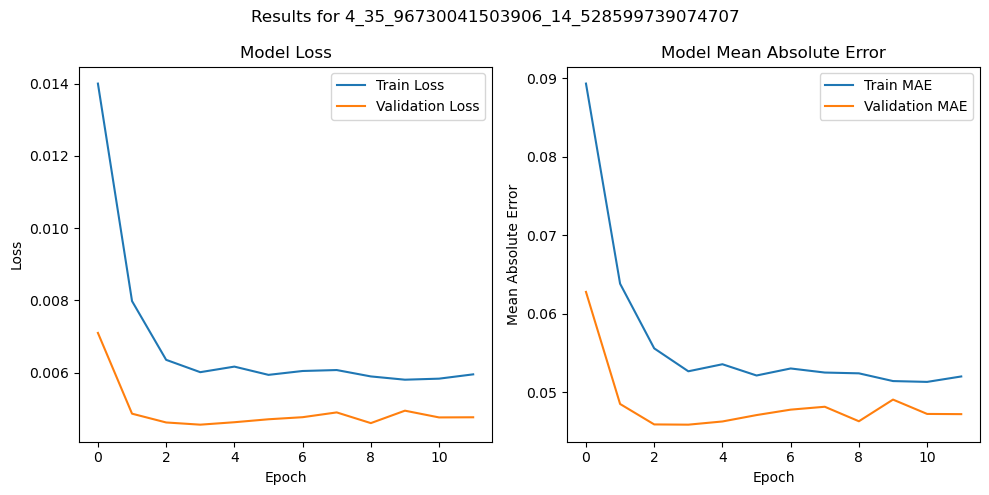

22/22 [==============================] - 6s 259ms/step

Test set Evaluation metrics for file: 4_35_96730041503906_14_528599739074707
Mean Squared Error (MSE): 0.0034781351758659735
Mean Absolute Error (MAE): 0.0445764024105876
Root Mean Squared Error (RMSE): 0.05897571683215028



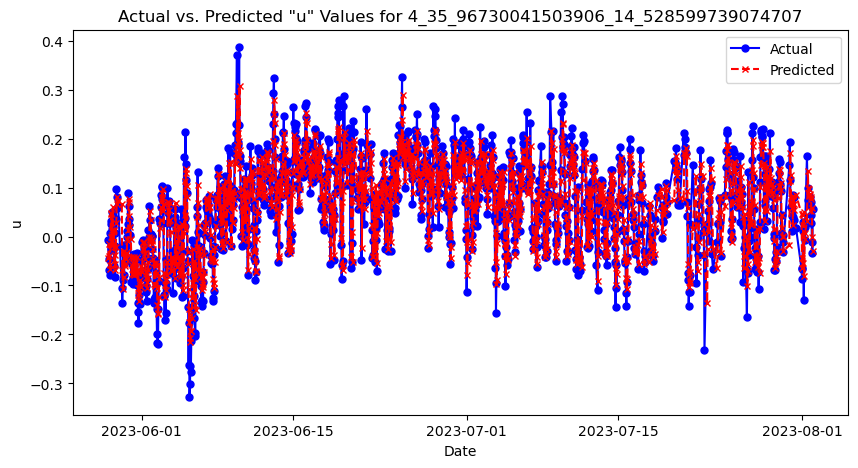

Model tarining & evaluation completed for file: 4_35_96730041503906_14_528599739074707.csv

Processing file: 5_35_96730041503906_14_569199562072754.csv

Epoch 1/100
103/103 [==============================] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0.0872INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 154s 1s/step - loss: 0.0125 - mean_absolute_error: 0.0872 - val_loss: 0.0062 - val_mean_absolute_error: 0.0613
Epoch 2/100
103/103 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0618INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 156s 2s/step - loss: 0.0070 - mean_absolute_error: 0.0618 - val_loss: 0.0043 - val_mean_absolute_error: 0.0484
Epoch 3/100
103/103 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0514INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 186s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0514 - val_loss: 0.0034 - val_mean_absolute_error: 0.0401
Epoch 4/100
103/103 [==============================] - 180s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0486 - val_loss: 0.0035 - val_mean_absolute_error: 0.0412
Epoch 5/100
103/103 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0479INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 185s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0479 - val_loss: 0.0034 - val_mean_absolute_error: 0.0398
Epoch 6/100
103/103 [==============================] - 180s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0475 - val_loss: 0.0035 - val_mean_absolute_error: 0.0405
Epoch 7/100
103/103 [==============================] - 181s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0475 - val_loss: 0.0036 - val_mean_absolute_error: 0.0415
Epoch 8/100
103/103 [==============================] - 180s 2s/step - loss: 0.0047 - mean_absolute_error: 0.0473 - val_loss: 0.0036 - val_mean_absolute_error: 0.0428
Epoch 9/100
103/103 [==============================] - 181s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0463 - val_loss: 0.0038 - val_mean_absolute_error: 0.0435
Epoch 10/100
103/103 [==============================] - 182s 2s/step - loss: 0.0044 - mean_absolute_error: 0.0459 - val_loss: 0.0036 - val_mean_absolute_error: 0.0423
Epoch 11/100
10

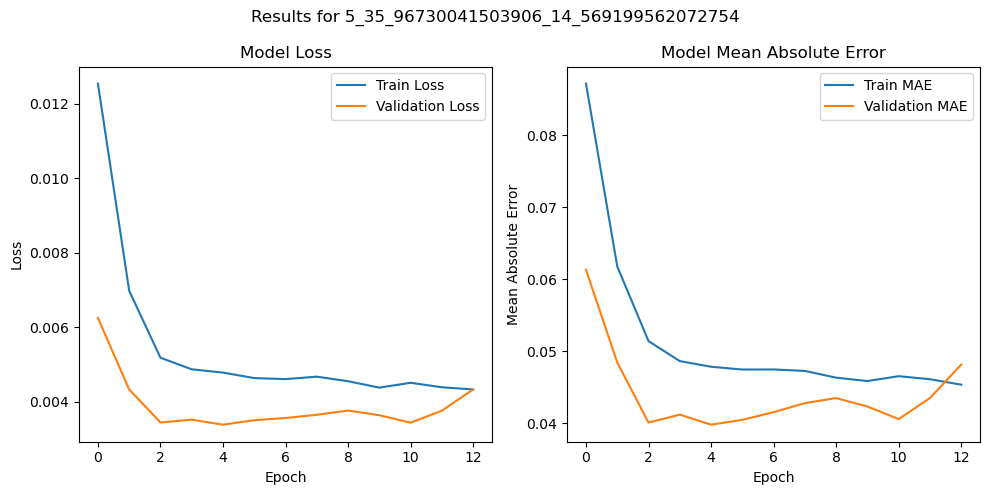

22/22 [==============================] - 7s 298ms/step

Test set Evaluation metrics for file: 5_35_96730041503906_14_569199562072754
Mean Squared Error (MSE): 0.0027732728262882976
Mean Absolute Error (MAE): 0.04012735139019126
Root Mean Squared Error (RMSE): 0.05266187260521883



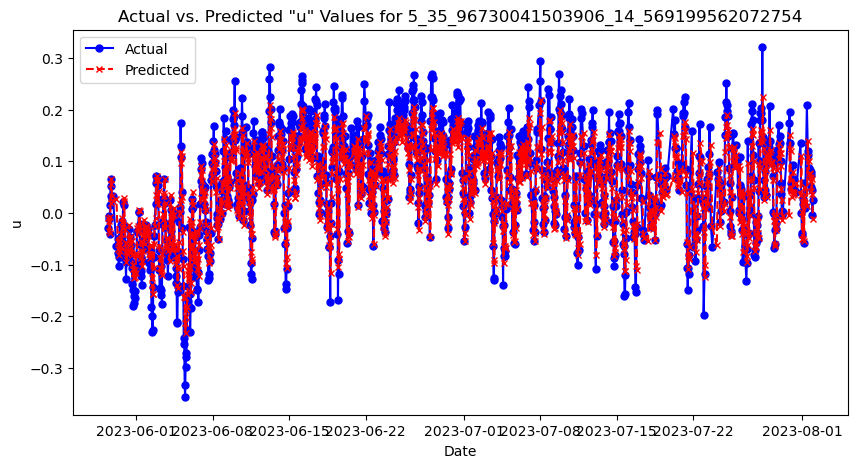

Model tarining & evaluation completed for file: 5_35_96730041503906_14_569199562072754.csv

Processing file: 6_35_989601135253906_14_447500228881836.csv

Epoch 1/100
73/73 [==============================] - ETA: 0s - loss: 0.0147 - mean_absolute_error: 0.0900INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\6_35_989601135253906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\6_35_989601135253906_14_447500228881836\assets


73/73 [==============================] - 128s 2s/step - loss: 0.0147 - mean_absolute_error: 0.0900 - val_loss: 0.0103 - val_mean_absolute_error: 0.0816
Epoch 2/100
73/73 [==============================] - ETA: 0s - loss: 0.0122 - mean_absolute_error: 0.0796INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\6_35_989601135253906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\6_35_989601135253906_14_447500228881836\assets


73/73 [==============================] - 129s 2s/step - loss: 0.0122 - mean_absolute_error: 0.0796 - val_loss: 0.0078 - val_mean_absolute_error: 0.0693
Epoch 3/100
73/73 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0710INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\6_35_989601135253906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\6_35_989601135253906_14_447500228881836\assets


73/73 [==============================] - 133s 2s/step - loss: 0.0104 - mean_absolute_error: 0.0710 - val_loss: 0.0071 - val_mean_absolute_error: 0.0664
Epoch 4/100
73/73 [==============================] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.0679INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\6_35_989601135253906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\6_35_989601135253906_14_447500228881836\assets


73/73 [==============================] - 135s 2s/step - loss: 0.0099 - mean_absolute_error: 0.0679 - val_loss: 0.0054 - val_mean_absolute_error: 0.0565
Epoch 5/100
73/73 [==============================] - 128s 2s/step - loss: 0.0093 - mean_absolute_error: 0.0644 - val_loss: 0.0054 - val_mean_absolute_error: 0.0568
Epoch 6/100
73/73 [==============================] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0646INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\6_35_989601135253906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\6_35_989601135253906_14_447500228881836\assets


73/73 [==============================] - 133s 2s/step - loss: 0.0091 - mean_absolute_error: 0.0646 - val_loss: 0.0053 - val_mean_absolute_error: 0.0555
Epoch 7/100
73/73 [==============================] - 127s 2s/step - loss: 0.0087 - mean_absolute_error: 0.0630 - val_loss: 0.0055 - val_mean_absolute_error: 0.0576
Epoch 8/100
73/73 [==============================] - 129s 2s/step - loss: 0.0088 - mean_absolute_error: 0.0631 - val_loss: 0.0053 - val_mean_absolute_error: 0.0557
Epoch 9/100
73/73 [==============================] - 128s 2s/step - loss: 0.0089 - mean_absolute_error: 0.0632 - val_loss: 0.0055 - val_mean_absolute_error: 0.0572
Epoch 10/100
73/73 [==============================] - 128s 2s/step - loss: 0.0088 - mean_absolute_error: 0.0624 - val_loss: 0.0055 - val_mean_absolute_error: 0.0571
Epoch 11/100
73/73 [==============================] - 128s 2s/step - loss: 0.0092 - mean_absolute_error: 0.0642 - val_loss: 0.0059 - val_mean_absolute_error: 0.0600
Epoch 12/100
73/73 [======

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\6_35_989601135253906_14_447500228881836\assets


73/73 [==============================] - 133s 2s/step - loss: 0.0088 - mean_absolute_error: 0.0629 - val_loss: 0.0052 - val_mean_absolute_error: 0.0549
Epoch 14/100
73/73 [==============================] - 128s 2s/step - loss: 0.0087 - mean_absolute_error: 0.0623 - val_loss: 0.0056 - val_mean_absolute_error: 0.0577
Epoch 15/100
73/73 [==============================] - 128s 2s/step - loss: 0.0087 - mean_absolute_error: 0.0627 - val_loss: 0.0062 - val_mean_absolute_error: 0.0614
Epoch 16/100
73/73 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0630INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\6_35_989601135253906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\6_35_989601135253906_14_447500228881836\assets


73/73 [==============================] - 134s 2s/step - loss: 0.0090 - mean_absolute_error: 0.0630 - val_loss: 0.0050 - val_mean_absolute_error: 0.0533
Epoch 17/100
73/73 [==============================] - 132s 2s/step - loss: 0.0084 - mean_absolute_error: 0.0610 - val_loss: 0.0059 - val_mean_absolute_error: 0.0594
Epoch 18/100
73/73 [==============================] - 131s 2s/step - loss: 0.0085 - mean_absolute_error: 0.0614 - val_loss: 0.0056 - val_mean_absolute_error: 0.0576
Epoch 19/100
73/73 [==============================] - 131s 2s/step - loss: 0.0088 - mean_absolute_error: 0.0624 - val_loss: 0.0062 - val_mean_absolute_error: 0.0612
Epoch 20/100
73/73 [==============================] - 132s 2s/step - loss: 0.0084 - mean_absolute_error: 0.0608 - val_loss: 0.0059 - val_mean_absolute_error: 0.0591
Epoch 21/100
73/73 [==============================] - 133s 2s/step - loss: 0.0084 - mean_absolute_error: 0.0611 - val_loss: 0.0060 - val_mean_absolute_error: 0.0598
Epoch 22/100
73/73 [===

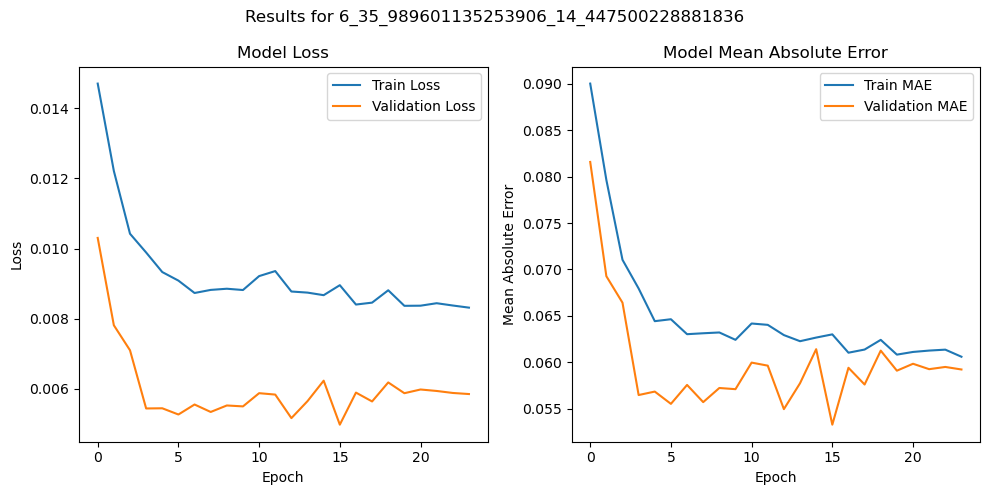

15/15 [==============================] - 5s 322ms/step

Test set Evaluation metrics for file: 6_35_989601135253906_14_447500228881836
Mean Squared Error (MSE): 0.005055052090150551
Mean Absolute Error (MAE): 0.052743937258150075
Root Mean Squared Error (RMSE): 0.07109888951418687



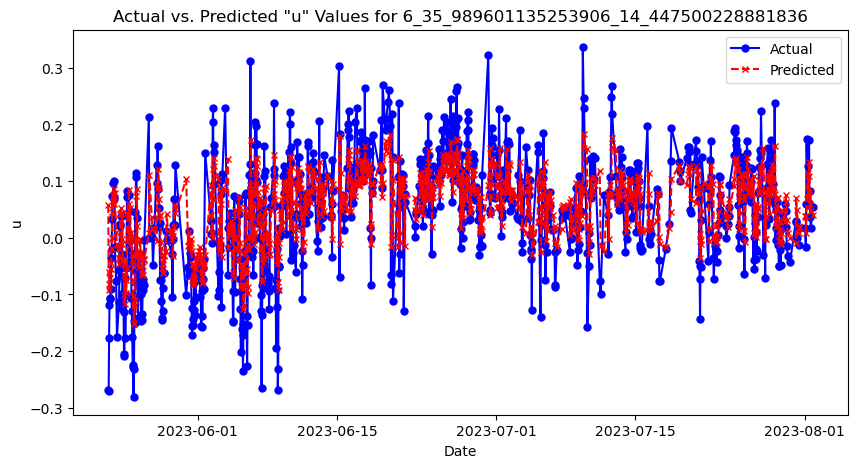

Model tarining & evaluation completed for file: 6_35_989601135253906_14_447500228881836.csv

Processing file: 7_35_989601135253906_14_48799991607666.csv

Epoch 1/100
106/106 [==============================] - ETA: 0s - loss: 0.0142 - mean_absolute_error: 0.0842INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\7_35_989601135253906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\7_35_989601135253906_14_48799991607666\assets


106/106 [==============================] - 198s 2s/step - loss: 0.0142 - mean_absolute_error: 0.0842 - val_loss: 0.0082 - val_mean_absolute_error: 0.0722
Epoch 2/100
106/106 [==============================] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0679INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\7_35_989601135253906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\7_35_989601135253906_14_48799991607666\assets


106/106 [==============================] - 194s 2s/step - loss: 0.0101 - mean_absolute_error: 0.0679 - val_loss: 0.0037 - val_mean_absolute_error: 0.0466
Epoch 3/100
106/106 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0577INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\7_35_989601135253906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\7_35_989601135253906_14_48799991607666\assets


106/106 [==============================] - 204s 2s/step - loss: 0.0080 - mean_absolute_error: 0.0577 - val_loss: 0.0030 - val_mean_absolute_error: 0.0408
Epoch 4/100
106/106 [==============================] - 214s 2s/step - loss: 0.0080 - mean_absolute_error: 0.0564 - val_loss: 0.0032 - val_mean_absolute_error: 0.0425
Epoch 5/100
106/106 [==============================] - 214s 2s/step - loss: 0.0081 - mean_absolute_error: 0.0566 - val_loss: 0.0036 - val_mean_absolute_error: 0.0461
Epoch 6/100
106/106 [==============================] - 217s 2s/step - loss: 0.0079 - mean_absolute_error: 0.0558 - val_loss: 0.0034 - val_mean_absolute_error: 0.0445
Epoch 7/100
106/106 [==============================] - 214s 2s/step - loss: 0.0078 - mean_absolute_error: 0.0559 - val_loss: 0.0031 - val_mean_absolute_error: 0.0418
Epoch 8/100
106/106 [==============================] - 215s 2s/step - loss: 0.0076 - mean_absolute_error: 0.0544 - val_loss: 0.0031 - val_mean_absolute_error: 0.0414
Epoch 9/100
106/

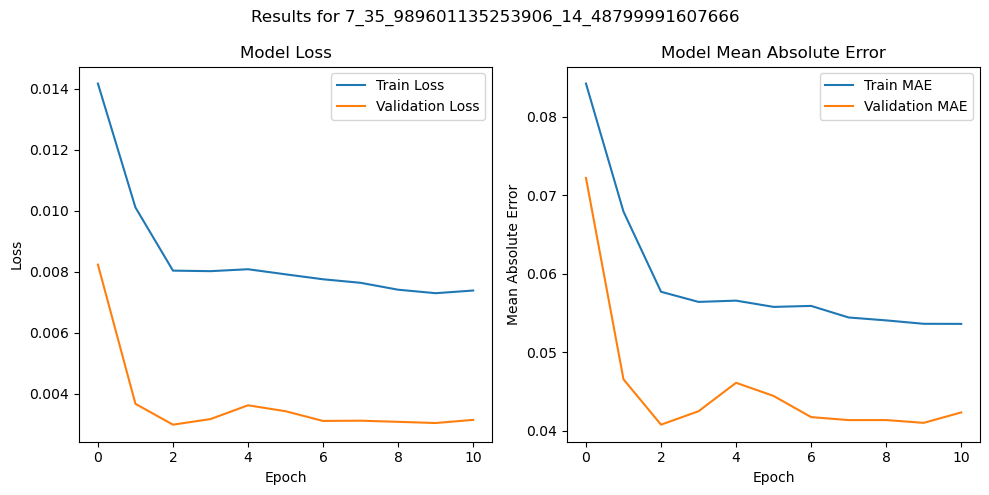

22/22 [==============================] - 9s 361ms/step

Test set Evaluation metrics for file: 7_35_989601135253906_14_48799991607666
Mean Squared Error (MSE): 0.0034095746909294507
Mean Absolute Error (MAE): 0.0437963731575682
Root Mean Squared Error (RMSE): 0.058391563525302614



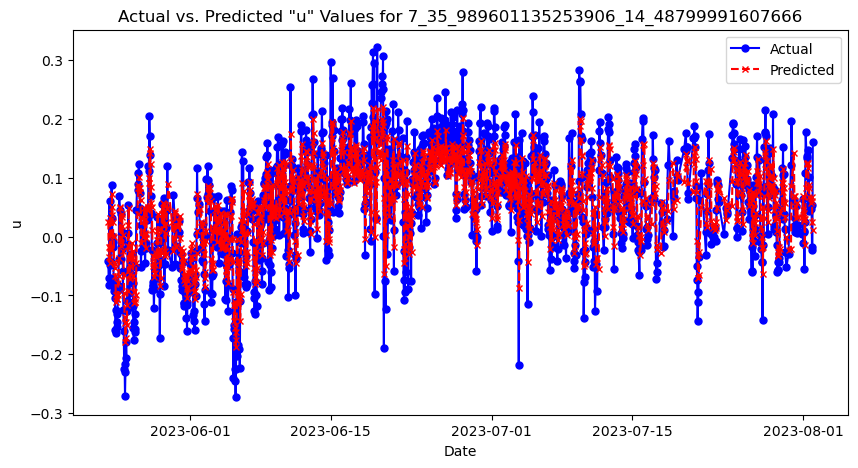

Model tarining & evaluation completed for file: 7_35_989601135253906_14_48799991607666.csv

Processing file: 8_35_989601135253906_14_528599739074707.csv

Epoch 1/100
117/117 [==============================] - ETA: 0s - loss: 0.0140 - mean_absolute_error: 0.0871INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\8_35_989601135253906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\8_35_989601135253906_14_528599739074707\assets


117/117 [==============================] - 243s 2s/step - loss: 0.0140 - mean_absolute_error: 0.0871 - val_loss: 0.0048 - val_mean_absolute_error: 0.0528
Epoch 2/100
117/117 [==============================] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0652INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\8_35_989601135253906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\8_35_989601135253906_14_528599739074707\assets


117/117 [==============================] - 241s 2s/step - loss: 0.0086 - mean_absolute_error: 0.0652 - val_loss: 0.0039 - val_mean_absolute_error: 0.0451
Epoch 3/100
117/117 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0588INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\8_35_989601135253906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\8_35_989601135253906_14_528599739074707\assets


117/117 [==============================] - 241s 2s/step - loss: 0.0077 - mean_absolute_error: 0.0588 - val_loss: 0.0033 - val_mean_absolute_error: 0.0397
Epoch 4/100
117/117 [==============================] - 235s 2s/step - loss: 0.0072 - mean_absolute_error: 0.0564 - val_loss: 0.0036 - val_mean_absolute_error: 0.0420
Epoch 5/100
117/117 [==============================] - 237s 2s/step - loss: 0.0073 - mean_absolute_error: 0.0563 - val_loss: 0.0035 - val_mean_absolute_error: 0.0409
Epoch 6/100
117/117 [==============================] - 235s 2s/step - loss: 0.0071 - mean_absolute_error: 0.0553 - val_loss: 0.0035 - val_mean_absolute_error: 0.0414
Epoch 7/100
117/117 [==============================] - 235s 2s/step - loss: 0.0068 - mean_absolute_error: 0.0539 - val_loss: 0.0036 - val_mean_absolute_error: 0.0420
Epoch 8/100
117/117 [==============================] - 237s 2s/step - loss: 0.0069 - mean_absolute_error: 0.0538 - val_loss: 0.0033 - val_mean_absolute_error: 0.0401
Epoch 9/100
117/

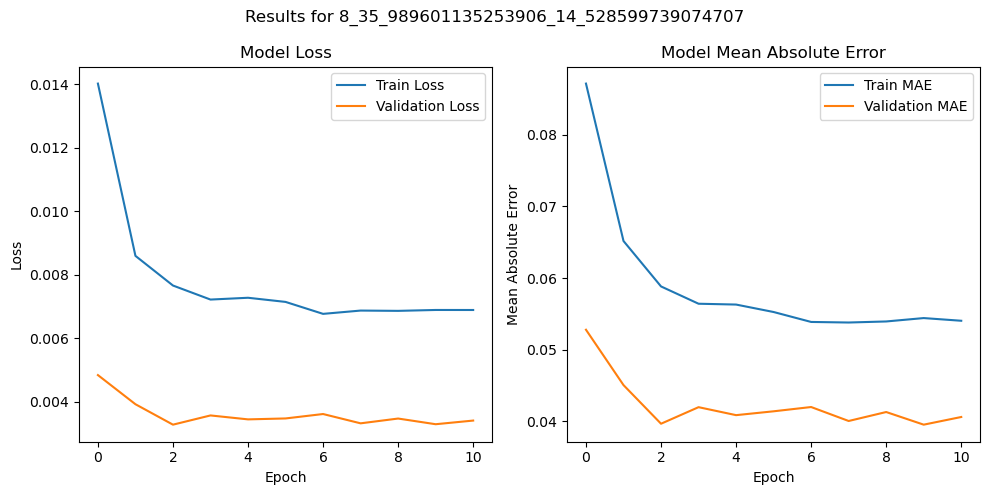

25/25 [==============================] - 9s 351ms/step

Test set Evaluation metrics for file: 8_35_989601135253906_14_528599739074707
Mean Squared Error (MSE): 0.002852519338383968
Mean Absolute Error (MAE): 0.04017500298215247
Root Mean Squared Error (RMSE): 0.05340898181377331



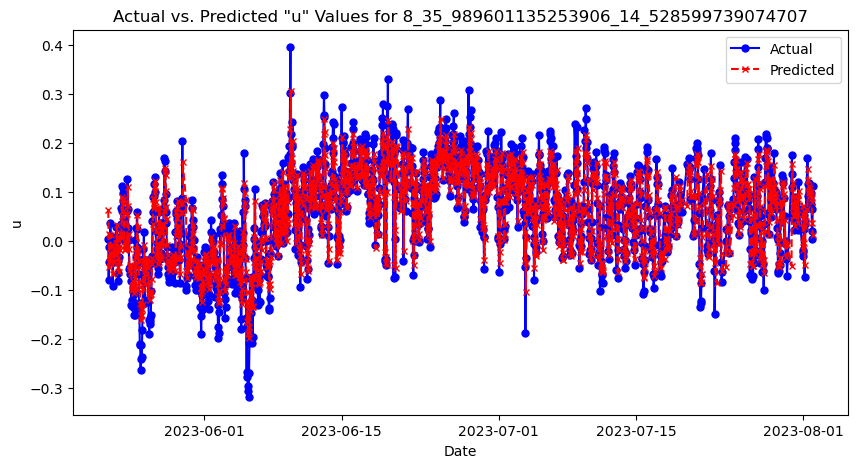

Model tarining & evaluation completed for file: 8_35_989601135253906_14_528599739074707.csv

Processing file: 9_35_989601135253906_14_569199562072754.csv

Epoch 1/100
117/117 [==============================] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0865INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 239s 2s/step - loss: 0.0129 - mean_absolute_error: 0.0865 - val_loss: 0.0051 - val_mean_absolute_error: 0.0554
Epoch 2/100
117/117 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 242s 2s/step - loss: 0.0069 - mean_absolute_error: 0.0593 - val_loss: 0.0028 - val_mean_absolute_error: 0.0378
Epoch 3/100
117/117 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0527INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 239s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0527 - val_loss: 0.0028 - val_mean_absolute_error: 0.0375
Epoch 4/100
117/117 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0524INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 240s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0524 - val_loss: 0.0026 - val_mean_absolute_error: 0.0355
Epoch 5/100
117/117 [==============================] - 235s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0524 - val_loss: 0.0029 - val_mean_absolute_error: 0.0389
Epoch 6/100
117/117 [==============================] - 235s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0504 - val_loss: 0.0027 - val_mean_absolute_error: 0.0363
Epoch 7/100
117/117 [==============================] - 235s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0503 - val_loss: 0.0027 - val_mean_absolute_error: 0.0370
Epoch 8/100
117/117 [==============================] - 235s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0516 - val_loss: 0.0030 - val_mean_absolute_error: 0.0394
Epoch 9/100
117/117 [==============================] - 234s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0494 - val_loss: 0.0033 - val_mean_absolute_error: 0.0427
Epoch 10/100
117

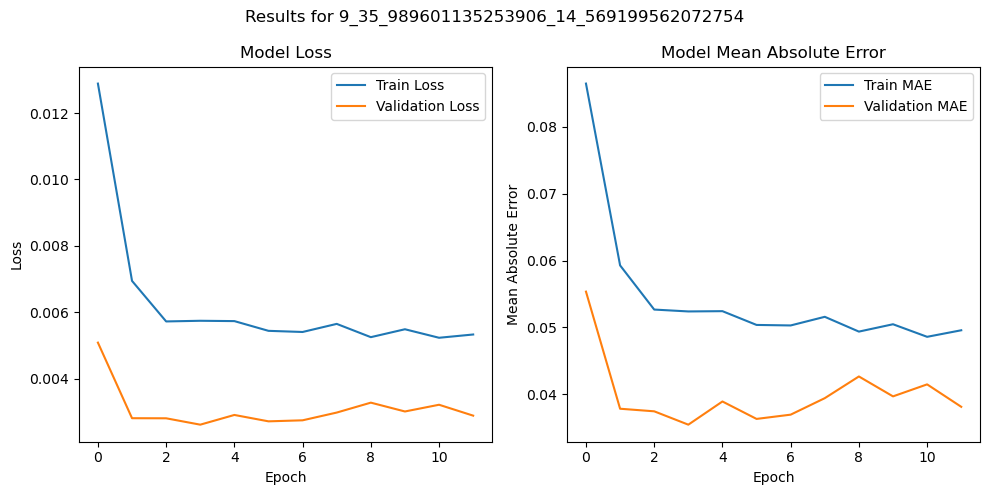

25/25 [==============================] - 10s 358ms/step

Test set Evaluation metrics for file: 9_35_989601135253906_14_569199562072754
Mean Squared Error (MSE): 0.002545405638345871
Mean Absolute Error (MAE): 0.03846460312891026
Root Mean Squared Error (RMSE): 0.05045201322391279



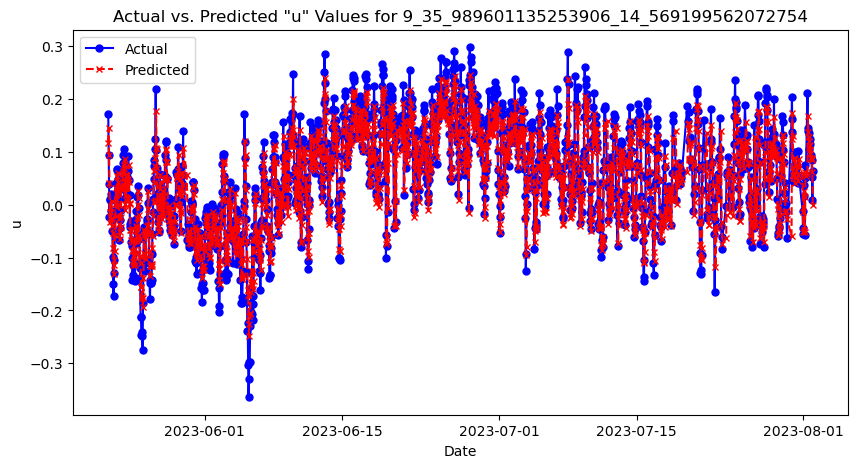

Model tarining & evaluation completed for file: 9_35_989601135253906_14_569199562072754.csv

Processing file: 10_36_01190185546875_14_447500228881836.csv

Epoch 1/100
102/102 [==============================] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.0841INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\10_36_01190185546875_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\10_36_01190185546875_14_447500228881836\assets


102/102 [==============================] - 208s 2s/step - loss: 0.0133 - mean_absolute_error: 0.0841 - val_loss: 0.0055 - val_mean_absolute_error: 0.0580
Epoch 2/100
102/102 [==============================] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0702INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\10_36_01190185546875_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\10_36_01190185546875_14_447500228881836\assets


102/102 [==============================] - 195s 2s/step - loss: 0.0102 - mean_absolute_error: 0.0702 - val_loss: 0.0033 - val_mean_absolute_error: 0.0443
Epoch 3/100
102/102 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0613INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\10_36_01190185546875_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\10_36_01190185546875_14_447500228881836\assets


102/102 [==============================] - 199s 2s/step - loss: 0.0088 - mean_absolute_error: 0.0613 - val_loss: 0.0029 - val_mean_absolute_error: 0.0406
Epoch 4/100
102/102 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0587INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\10_36_01190185546875_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\10_36_01190185546875_14_447500228881836\assets


102/102 [==============================] - 204s 2s/step - loss: 0.0081 - mean_absolute_error: 0.0587 - val_loss: 0.0029 - val_mean_absolute_error: 0.0407
Epoch 5/100
102/102 [==============================] - 216s 2s/step - loss: 0.0080 - mean_absolute_error: 0.0580 - val_loss: 0.0029 - val_mean_absolute_error: 0.0410
Epoch 6/100
102/102 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0574INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\10_36_01190185546875_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\10_36_01190185546875_14_447500228881836\assets


102/102 [==============================] - 221s 2s/step - loss: 0.0077 - mean_absolute_error: 0.0574 - val_loss: 0.0026 - val_mean_absolute_error: 0.0377
Epoch 7/100
102/102 [==============================] - 223s 2s/step - loss: 0.0078 - mean_absolute_error: 0.0563 - val_loss: 0.0028 - val_mean_absolute_error: 0.0397
Epoch 8/100
102/102 [==============================] - 213s 2s/step - loss: 0.0077 - mean_absolute_error: 0.0568 - val_loss: 0.0032 - val_mean_absolute_error: 0.0430
Epoch 9/100
102/102 [==============================] - 213s 2s/step - loss: 0.0074 - mean_absolute_error: 0.0550 - val_loss: 0.0029 - val_mean_absolute_error: 0.0413
Epoch 10/100
102/102 [==============================] - 214s 2s/step - loss: 0.0073 - mean_absolute_error: 0.0547 - val_loss: 0.0027 - val_mean_absolute_error: 0.0393
Epoch 11/100
102/102 [==============================] - 214s 2s/step - loss: 0.0072 - mean_absolute_error: 0.0537 - val_loss: 0.0027 - val_mean_absolute_error: 0.0392
Epoch 12/100
1

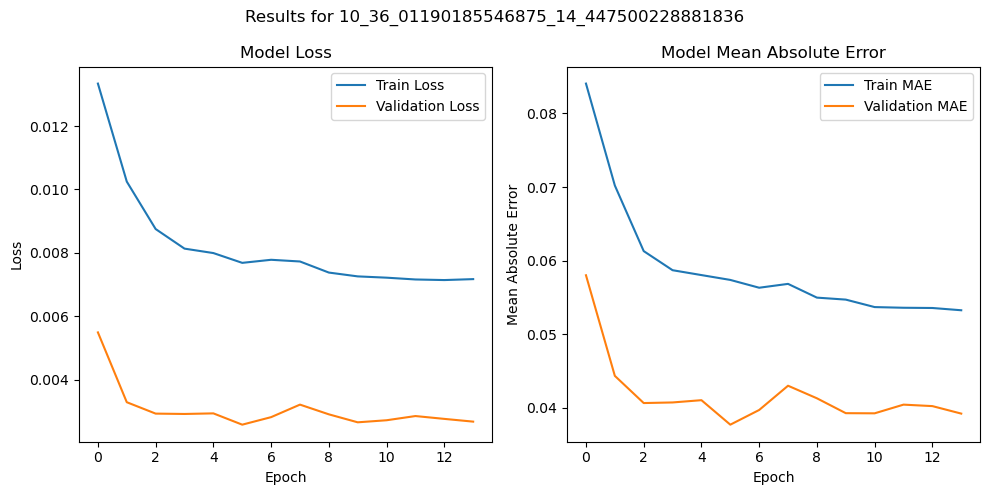

21/21 [==============================] - 9s 396ms/step

Test set Evaluation metrics for file: 10_36_01190185546875_14_447500228881836
Mean Squared Error (MSE): 0.0036352831249252403
Mean Absolute Error (MAE): 0.045305726284345746
Root Mean Squared Error (RMSE): 0.060293309122366474



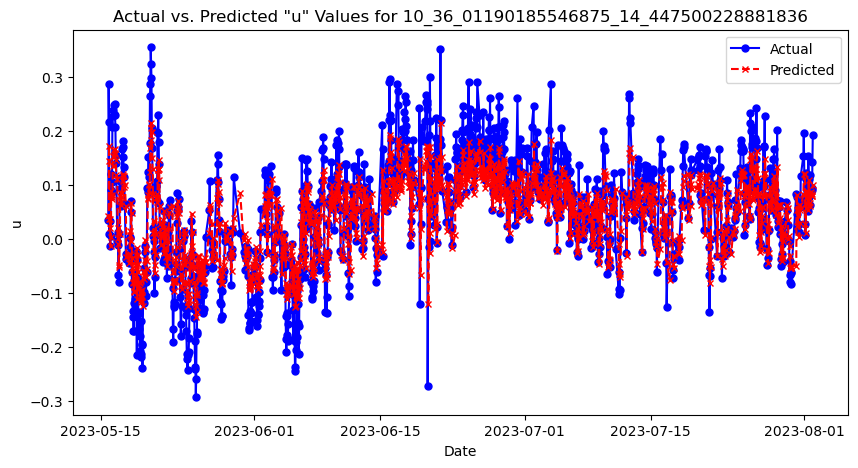

Model tarining & evaluation completed for file: 10_36_01190185546875_14_447500228881836.csv

Processing file: 11_36_01190185546875_14_48799991607666.csv

Epoch 1/100
121/121 [==============================] - ETA: 0s - loss: 0.0141 - mean_absolute_error: 0.0852INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\11_36_01190185546875_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\11_36_01190185546875_14_48799991607666\assets


121/121 [==============================] - 248s 2s/step - loss: 0.0141 - mean_absolute_error: 0.0852 - val_loss: 0.0041 - val_mean_absolute_error: 0.0491
Epoch 2/100
121/121 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0669INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\11_36_01190185546875_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\11_36_01190185546875_14_48799991607666\assets


121/121 [==============================] - 239s 2s/step - loss: 0.0096 - mean_absolute_error: 0.0669 - val_loss: 0.0024 - val_mean_absolute_error: 0.0367
Epoch 3/100
121/121 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0570INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\11_36_01190185546875_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\11_36_01190185546875_14_48799991607666\assets


121/121 [==============================] - 262s 2s/step - loss: 0.0079 - mean_absolute_error: 0.0570 - val_loss: 0.0022 - val_mean_absolute_error: 0.0343
Epoch 4/100
121/121 [==============================] - 259s 2s/step - loss: 0.0078 - mean_absolute_error: 0.0572 - val_loss: 0.0022 - val_mean_absolute_error: 0.0354
Epoch 5/100
121/121 [==============================] - 259s 2s/step - loss: 0.0078 - mean_absolute_error: 0.0569 - val_loss: 0.0022 - val_mean_absolute_error: 0.0348
Epoch 6/100
121/121 [==============================] - 259s 2s/step - loss: 0.0077 - mean_absolute_error: 0.0551 - val_loss: 0.0022 - val_mean_absolute_error: 0.0352
Epoch 7/100
121/121 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0554INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\11_36_01190185546875_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\11_36_01190185546875_14_48799991607666\assets


121/121 [==============================] - 264s 2s/step - loss: 0.0075 - mean_absolute_error: 0.0554 - val_loss: 0.0021 - val_mean_absolute_error: 0.0339
Epoch 8/100
121/121 [==============================] - 270s 2s/step - loss: 0.0077 - mean_absolute_error: 0.0556 - val_loss: 0.0023 - val_mean_absolute_error: 0.0357
Epoch 9/100
121/121 [==============================] - 268s 2s/step - loss: 0.0074 - mean_absolute_error: 0.0549 - val_loss: 0.0022 - val_mean_absolute_error: 0.0344
Epoch 10/100
121/121 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0540INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\11_36_01190185546875_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\11_36_01190185546875_14_48799991607666\assets


121/121 [==============================] - 273s 2s/step - loss: 0.0073 - mean_absolute_error: 0.0540 - val_loss: 0.0020 - val_mean_absolute_error: 0.0326
Epoch 11/100
121/121 [==============================] - 292s 2s/step - loss: 0.0072 - mean_absolute_error: 0.0528 - val_loss: 0.0022 - val_mean_absolute_error: 0.0342
Epoch 12/100
121/121 [==============================] - 294s 2s/step - loss: 0.0072 - mean_absolute_error: 0.0534 - val_loss: 0.0022 - val_mean_absolute_error: 0.0341
Epoch 13/100
121/121 [==============================] - 292s 2s/step - loss: 0.0072 - mean_absolute_error: 0.0537 - val_loss: 0.0024 - val_mean_absolute_error: 0.0365
Epoch 14/100
121/121 [==============================] - 293s 2s/step - loss: 0.0073 - mean_absolute_error: 0.0536 - val_loss: 0.0021 - val_mean_absolute_error: 0.0335
Epoch 15/100
121/121 [==============================] - 293s 2s/step - loss: 0.0073 - mean_absolute_error: 0.0532 - val_loss: 0.0021 - val_mean_absolute_error: 0.0339
Epoch 16/10

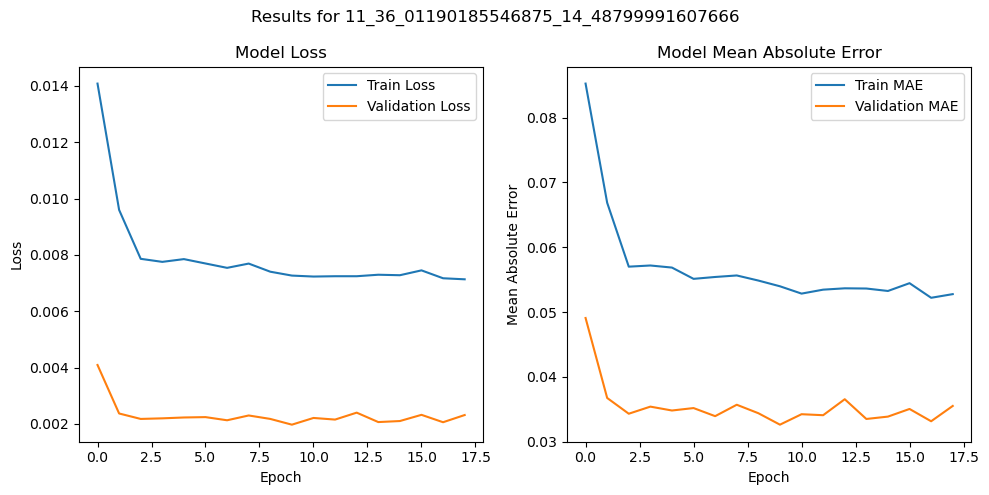

26/26 [==============================] - 10s 354ms/step

Test set Evaluation metrics for file: 11_36_01190185546875_14_48799991607666
Mean Squared Error (MSE): 0.0028675005947493503
Mean Absolute Error (MAE): 0.03944153999464698
Root Mean Squared Error (RMSE): 0.05354904849527534



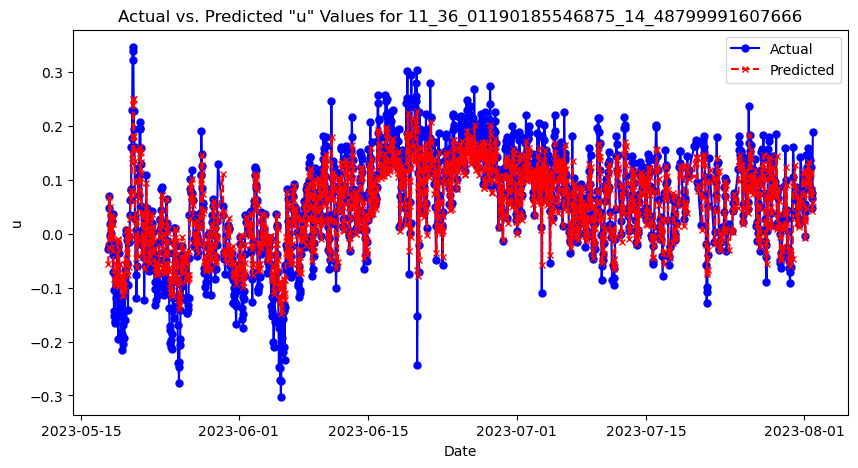

Model tarining & evaluation completed for file: 11_36_01190185546875_14_48799991607666.csv

Processing file: 12_36_01190185546875_14_528599739074707.csv

Epoch 1/100
135/135 [==============================] - ETA: 0s - loss: 0.0160 - mean_absolute_error: 0.0892INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\12_36_01190185546875_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\12_36_01190185546875_14_528599739074707\assets


135/135 [==============================] - 260s 2s/step - loss: 0.0160 - mean_absolute_error: 0.0892 - val_loss: 0.0079 - val_mean_absolute_error: 0.0650
Epoch 2/100
135/135 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0682INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\12_36_01190185546875_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\12_36_01190185546875_14_528599739074707\assets


135/135 [==============================] - 295s 2s/step - loss: 0.0104 - mean_absolute_error: 0.0682 - val_loss: 0.0053 - val_mean_absolute_error: 0.0504
Epoch 3/100
135/135 [==============================] - 298s 2s/step - loss: 0.0089 - mean_absolute_error: 0.0613 - val_loss: 0.0056 - val_mean_absolute_error: 0.0523
Epoch 4/100
135/135 [==============================] - 320s 2s/step - loss: 0.0089 - mean_absolute_error: 0.0610 - val_loss: 0.0054 - val_mean_absolute_error: 0.0508
Epoch 5/100
135/135 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0606INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\12_36_01190185546875_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\12_36_01190185546875_14_528599739074707\assets


135/135 [==============================] - 298s 2s/step - loss: 0.0088 - mean_absolute_error: 0.0606 - val_loss: 0.0053 - val_mean_absolute_error: 0.0493
Epoch 6/100
135/135 [==============================] - 295s 2s/step - loss: 0.0085 - mean_absolute_error: 0.0596 - val_loss: 0.0057 - val_mean_absolute_error: 0.0526
Epoch 7/100
135/135 [==============================] - 296s 2s/step - loss: 0.0089 - mean_absolute_error: 0.0609 - val_loss: 0.0059 - val_mean_absolute_error: 0.0532
Epoch 8/100
135/135 [==============================] - 296s 2s/step - loss: 0.0088 - mean_absolute_error: 0.0597 - val_loss: 0.0055 - val_mean_absolute_error: 0.0514
Epoch 9/100
135/135 [==============================] - 295s 2s/step - loss: 0.0090 - mean_absolute_error: 0.0611 - val_loss: 0.0056 - val_mean_absolute_error: 0.0516
Epoch 10/100
135/135 [==============================] - 295s 2s/step - loss: 0.0085 - mean_absolute_error: 0.0591 - val_loss: 0.0054 - val_mean_absolute_error: 0.0507
Epoch 11/100
13

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\12_36_01190185546875_14_528599739074707\assets


135/135 [==============================] - 301s 2s/step - loss: 0.0084 - mean_absolute_error: 0.0579 - val_loss: 0.0051 - val_mean_absolute_error: 0.0476
Epoch 13/100
135/135 [==============================] - 296s 2s/step - loss: 0.0085 - mean_absolute_error: 0.0582 - val_loss: 0.0058 - val_mean_absolute_error: 0.0523
Epoch 14/100
135/135 [==============================] - 296s 2s/step - loss: 0.0086 - mean_absolute_error: 0.0579 - val_loss: 0.0053 - val_mean_absolute_error: 0.0489
Epoch 15/100
135/135 [==============================] - 297s 2s/step - loss: 0.0082 - mean_absolute_error: 0.0570 - val_loss: 0.0054 - val_mean_absolute_error: 0.0502
Epoch 16/100
135/135 [==============================] - 296s 2s/step - loss: 0.0083 - mean_absolute_error: 0.0573 - val_loss: 0.0054 - val_mean_absolute_error: 0.0503
Epoch 17/100
135/135 [==============================] - 297s 2s/step - loss: 0.0081 - mean_absolute_error: 0.0563 - val_loss: 0.0056 - val_mean_absolute_error: 0.0518
Epoch 18/10

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\12_36_01190185546875_14_528599739074707\assets


135/135 [==============================] - 301s 2s/step - loss: 0.0080 - mean_absolute_error: 0.0559 - val_loss: 0.0050 - val_mean_absolute_error: 0.0480
Epoch 19/100
135/135 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0571INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\12_36_01190185546875_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\12_36_01190185546875_14_528599739074707\assets


135/135 [==============================] - 305s 2s/step - loss: 0.0083 - mean_absolute_error: 0.0571 - val_loss: 0.0050 - val_mean_absolute_error: 0.0477
Epoch 20/100
135/135 [==============================] - 301s 2s/step - loss: 0.0082 - mean_absolute_error: 0.0566 - val_loss: 0.0054 - val_mean_absolute_error: 0.0503
Epoch 21/100
135/135 [==============================] - 287s 2s/step - loss: 0.0080 - mean_absolute_error: 0.0557 - val_loss: 0.0051 - val_mean_absolute_error: 0.0486
Epoch 22/100
135/135 [==============================] - 288s 2s/step - loss: 0.0081 - mean_absolute_error: 0.0561 - val_loss: 0.0053 - val_mean_absolute_error: 0.0490
Epoch 23/100
135/135 [==============================] - 291s 2s/step - loss: 0.0079 - mean_absolute_error: 0.0551 - val_loss: 0.0053 - val_mean_absolute_error: 0.0491
Epoch 24/100
135/135 [==============================] - 288s 2s/step - loss: 0.0081 - mean_absolute_error: 0.0556 - val_loss: 0.0054 - val_mean_absolute_error: 0.0499
Epoch 25/10

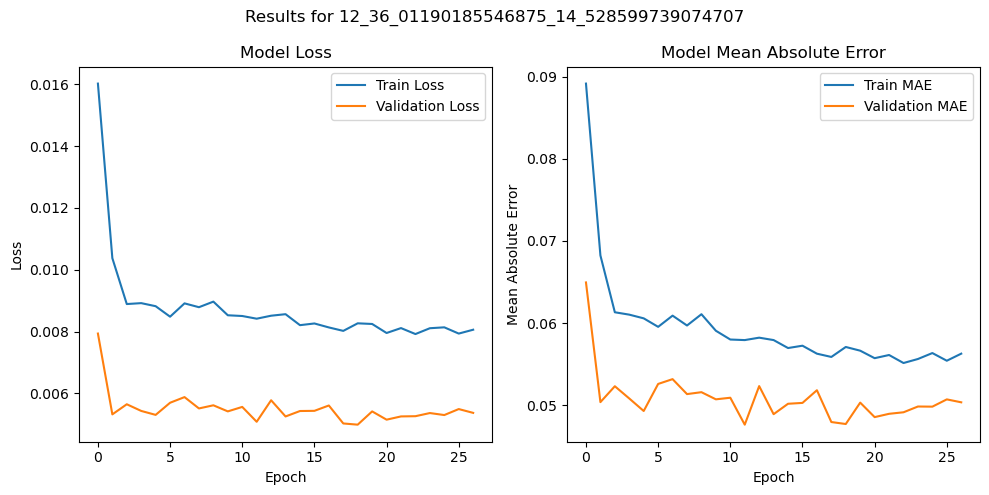

28/28 [==============================] - 11s 382ms/step

Test set Evaluation metrics for file: 12_36_01190185546875_14_528599739074707
Mean Squared Error (MSE): 0.0030666775334324157
Mean Absolute Error (MAE): 0.043051889068793654
Root Mean Squared Error (RMSE): 0.05537759053473179



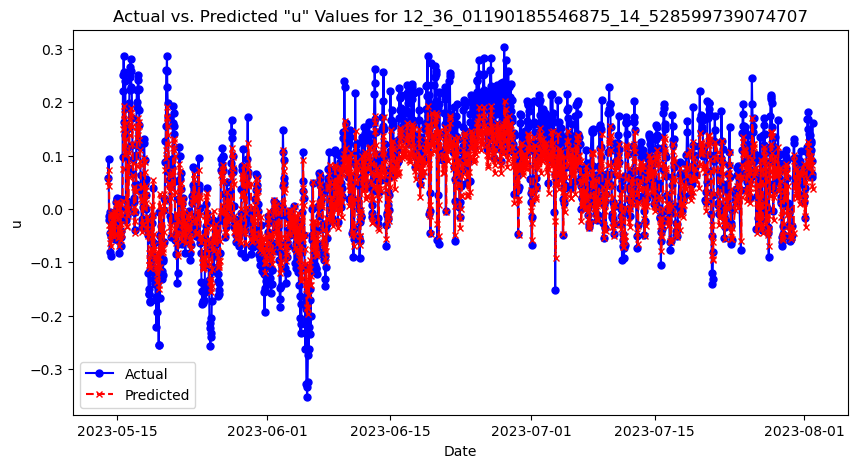

Model tarining & evaluation completed for file: 12_36_01190185546875_14_528599739074707.csv

Processing file: 13_36_01190185546875_14_569199562072754.csv

Epoch 1/100
133/133 [==============================] - ETA: 0s - loss: 0.0157 - mean_absolute_error: 0.0899INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\13_36_01190185546875_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\13_36_01190185546875_14_569199562072754\assets


133/133 [==============================] - 285s 2s/step - loss: 0.0157 - mean_absolute_error: 0.0899 - val_loss: 0.0051 - val_mean_absolute_error: 0.0524
Epoch 2/100
133/133 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0676INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\13_36_01190185546875_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\13_36_01190185546875_14_569199562072754\assets


133/133 [==============================] - 292s 2s/step - loss: 0.0097 - mean_absolute_error: 0.0676 - val_loss: 0.0035 - val_mean_absolute_error: 0.0414
Epoch 3/100
133/133 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0553INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\13_36_01190185546875_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\13_36_01190185546875_14_569199562072754\assets


133/133 [==============================] - 283s 2s/step - loss: 0.0071 - mean_absolute_error: 0.0553 - val_loss: 0.0033 - val_mean_absolute_error: 0.0376
Epoch 4/100
133/133 [==============================] - 278s 2s/step - loss: 0.0071 - mean_absolute_error: 0.0551 - val_loss: 0.0033 - val_mean_absolute_error: 0.0384
Epoch 5/100
133/133 [==============================] - 281s 2s/step - loss: 0.0073 - mean_absolute_error: 0.0562 - val_loss: 0.0035 - val_mean_absolute_error: 0.0401
Epoch 6/100
133/133 [==============================] - 279s 2s/step - loss: 0.0070 - mean_absolute_error: 0.0551 - val_loss: 0.0033 - val_mean_absolute_error: 0.0383
Epoch 7/100
133/133 [==============================] - 279s 2s/step - loss: 0.0069 - mean_absolute_error: 0.0547 - val_loss: 0.0034 - val_mean_absolute_error: 0.0393
Epoch 8/100
133/133 [==============================] - 279s 2s/step - loss: 0.0068 - mean_absolute_error: 0.0534 - val_loss: 0.0033 - val_mean_absolute_error: 0.0383
Epoch 9/100
133/

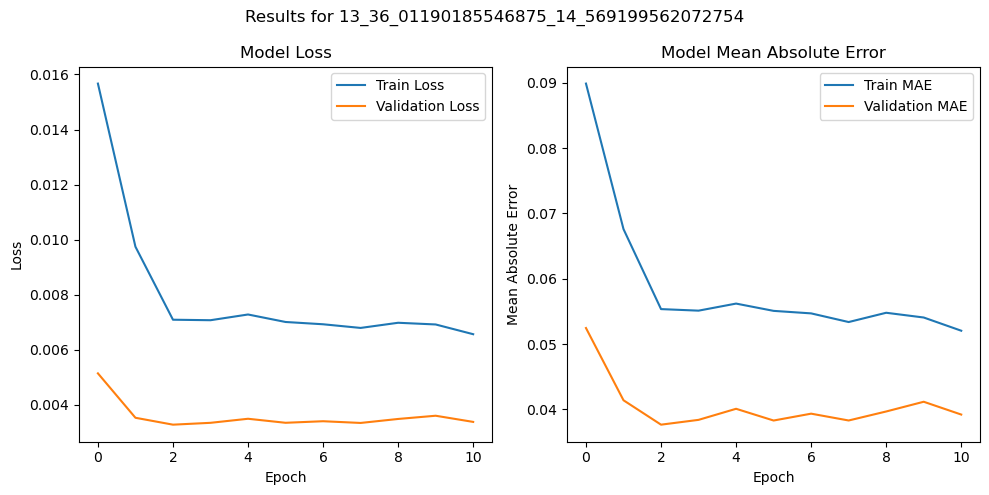

28/28 [==============================] - 11s 367ms/step

Test set Evaluation metrics for file: 13_36_01190185546875_14_569199562072754
Mean Squared Error (MSE): 0.0022199585746270865
Mean Absolute Error (MAE): 0.03612100554558682
Root Mean Squared Error (RMSE): 0.04711643635322059



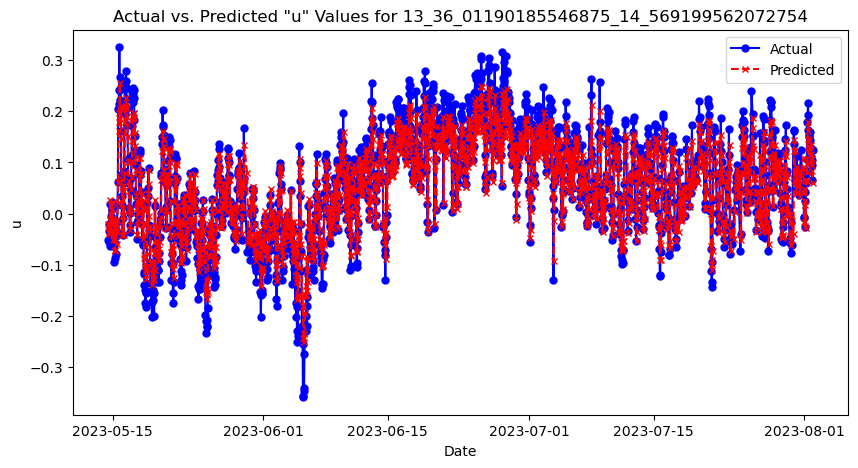

Model tarining & evaluation completed for file: 13_36_01190185546875_14_569199562072754.csv

Processing file: 14_36_03409957885742_14_447500228881836.csv

Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.0777INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\14_36_03409957885742_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 264s 2s/step - loss: 0.0117 - mean_absolute_error: 0.0777 - val_loss: 0.0059 - val_mean_absolute_error: 0.0536
Epoch 2/100
125/125 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0599INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\14_36_03409957885742_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 259s 2s/step - loss: 0.0079 - mean_absolute_error: 0.0599 - val_loss: 0.0044 - val_mean_absolute_error: 0.0414
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0552INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\14_36_03409957885742_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 268s 2s/step - loss: 0.0071 - mean_absolute_error: 0.0552 - val_loss: 0.0042 - val_mean_absolute_error: 0.0405
Epoch 4/100
125/125 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0545INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\14_36_03409957885742_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 280s 2s/step - loss: 0.0071 - mean_absolute_error: 0.0545 - val_loss: 0.0039 - val_mean_absolute_error: 0.0373
Epoch 5/100
125/125 [==============================] - 297s 2s/step - loss: 0.0069 - mean_absolute_error: 0.0533 - val_loss: 0.0039 - val_mean_absolute_error: 0.0374
Epoch 6/100
125/125 [==============================] - 300s 2s/step - loss: 0.0068 - mean_absolute_error: 0.0531 - val_loss: 0.0040 - val_mean_absolute_error: 0.0381
Epoch 7/100
125/125 [==============================] - 299s 2s/step - loss: 0.0068 - mean_absolute_error: 0.0523 - val_loss: 0.0041 - val_mean_absolute_error: 0.0385
Epoch 8/100
125/125 [==============================] - 298s 2s/step - loss: 0.0066 - mean_absolute_error: 0.0520 - val_loss: 0.0041 - val_mean_absolute_error: 0.0402
Epoch 9/100
125/125 [==============================] - 300s 2s/step - loss: 0.0067 - mean_absolute_error: 0.0517 - val_loss: 0.0042 - val_mean_absolute_error: 0.0401
Epoch 10/100
125

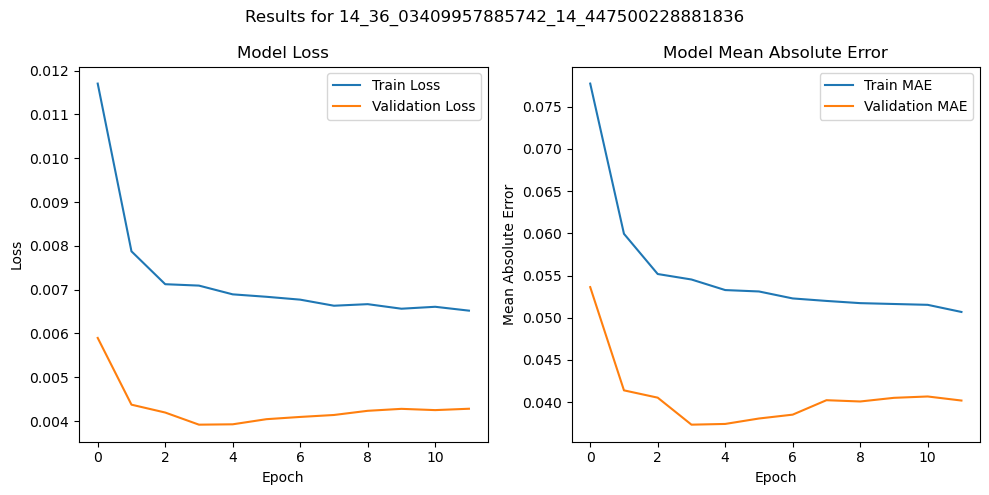

26/26 [==============================] - 10s 345ms/step

Test set Evaluation metrics for file: 14_36_03409957885742_14_447500228881836
Mean Squared Error (MSE): 0.0027706719275296435
Mean Absolute Error (MAE): 0.040392041789471714
Root Mean Squared Error (RMSE): 0.052637172487982706



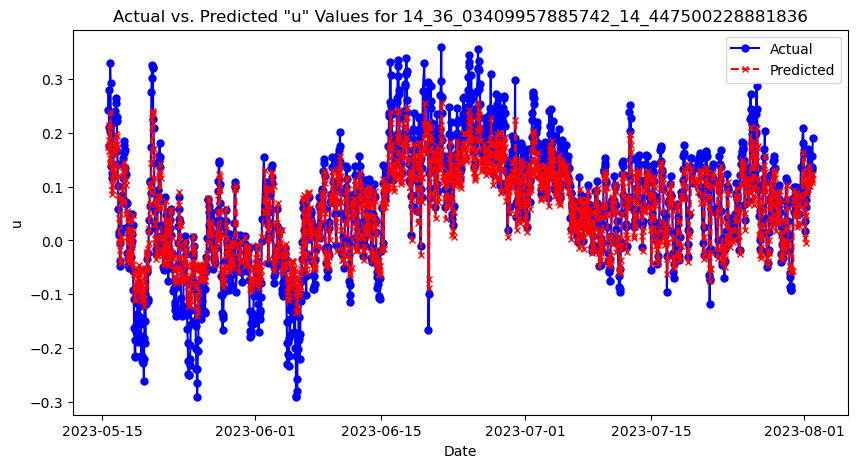

Model tarining & evaluation completed for file: 14_36_03409957885742_14_447500228881836.csv

Processing file: 15_36_03409957885742_14_48799991607666.csv

Epoch 1/100
137/137 [==============================] - ETA: 0s - loss: 0.0155 - mean_absolute_error: 0.0883INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\15_36_03409957885742_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\15_36_03409957885742_14_48799991607666\assets


137/137 [==============================] - 258s 2s/step - loss: 0.0155 - mean_absolute_error: 0.0883 - val_loss: 0.0087 - val_mean_absolute_error: 0.0623
Epoch 2/100
137/137 [==============================] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0668INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\15_36_03409957885742_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\15_36_03409957885742_14_48799991607666\assets


137/137 [==============================] - 256s 2s/step - loss: 0.0100 - mean_absolute_error: 0.0668 - val_loss: 0.0061 - val_mean_absolute_error: 0.0474
Epoch 3/100
137/137 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0592INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\15_36_03409957885742_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\15_36_03409957885742_14_48799991607666\assets


137/137 [==============================] - 258s 2s/step - loss: 0.0085 - mean_absolute_error: 0.0592 - val_loss: 0.0058 - val_mean_absolute_error: 0.0449
Epoch 4/100
137/137 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0569INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\15_36_03409957885742_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\15_36_03409957885742_14_48799991607666\assets


137/137 [==============================] - 273s 2s/step - loss: 0.0079 - mean_absolute_error: 0.0569 - val_loss: 0.0053 - val_mean_absolute_error: 0.0397
Epoch 5/100
137/137 [==============================] - 274s 2s/step - loss: 0.0081 - mean_absolute_error: 0.0576 - val_loss: 0.0057 - val_mean_absolute_error: 0.0438
Epoch 6/100
137/137 [==============================] - 276s 2s/step - loss: 0.0081 - mean_absolute_error: 0.0575 - val_loss: 0.0057 - val_mean_absolute_error: 0.0451
Epoch 7/100
137/137 [==============================] - 273s 2s/step - loss: 0.0081 - mean_absolute_error: 0.0570 - val_loss: 0.0057 - val_mean_absolute_error: 0.0445
Epoch 8/100
137/137 [==============================] - 274s 2s/step - loss: 0.0081 - mean_absolute_error: 0.0571 - val_loss: 0.0062 - val_mean_absolute_error: 0.0486
Epoch 9/100
137/137 [==============================] - 274s 2s/step - loss: 0.0081 - mean_absolute_error: 0.0571 - val_loss: 0.0062 - val_mean_absolute_error: 0.0484
Epoch 10/100
137

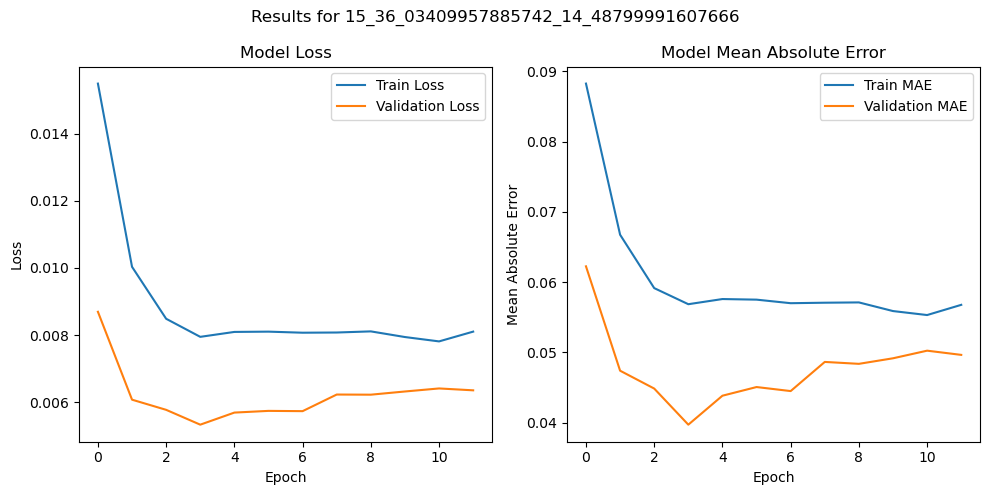

29/29 [==============================] - 11s 355ms/step

Test set Evaluation metrics for file: 15_36_03409957885742_14_48799991607666
Mean Squared Error (MSE): 0.0022552666878001694
Mean Absolute Error (MAE): 0.03561516173009409
Root Mean Squared Error (RMSE): 0.047489648217271196



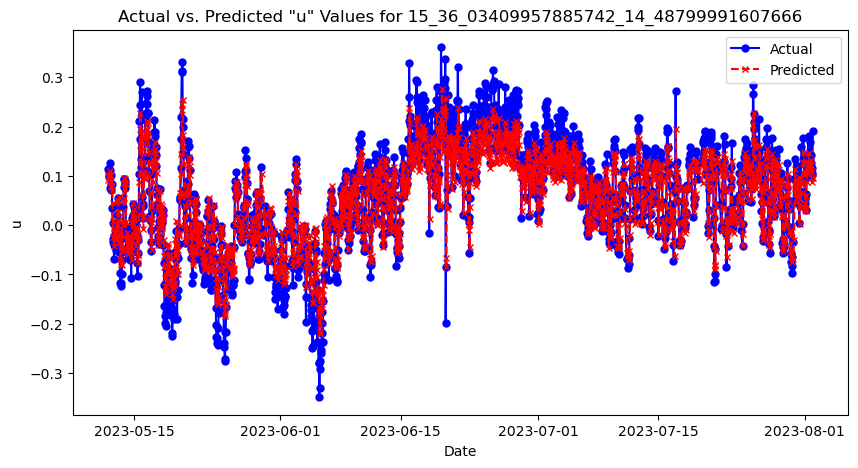

Model tarining & evaluation completed for file: 15_36_03409957885742_14_48799991607666.csv

Processing file: 16_36_03409957885742_14_528599739074707.csv

Epoch 1/100
156/156 [==============================] - ETA: 0s - loss: 0.0170 - mean_absolute_error: 0.0886INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\16_36_03409957885742_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\16_36_03409957885742_14_528599739074707\assets


156/156 [==============================] - 333s 2s/step - loss: 0.0170 - mean_absolute_error: 0.0886 - val_loss: 0.0097 - val_mean_absolute_error: 0.0648
Epoch 2/100
156/156 [==============================] - ETA: 0s - loss: 0.0118 - mean_absolute_error: 0.0709INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\16_36_03409957885742_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\16_36_03409957885742_14_528599739074707\assets


156/156 [==============================] - 332s 2s/step - loss: 0.0118 - mean_absolute_error: 0.0709 - val_loss: 0.0079 - val_mean_absolute_error: 0.0566
Epoch 3/100
156/156 [==============================] - 327s 2s/step - loss: 0.0109 - mean_absolute_error: 0.0660 - val_loss: 0.0080 - val_mean_absolute_error: 0.0559
Epoch 4/100
156/156 [==============================] - 327s 2s/step - loss: 0.0106 - mean_absolute_error: 0.0644 - val_loss: 0.0081 - val_mean_absolute_error: 0.0561
Epoch 5/100
156/156 [==============================] - 326s 2s/step - loss: 0.0105 - mean_absolute_error: 0.0646 - val_loss: 0.0085 - val_mean_absolute_error: 0.0595
Epoch 6/100
156/156 [==============================] - 326s 2s/step - loss: 0.0104 - mean_absolute_error: 0.0641 - val_loss: 0.0082 - val_mean_absolute_error: 0.0583
Epoch 7/100
156/156 [==============================] - 326s 2s/step - loss: 0.0106 - mean_absolute_error: 0.0652 - val_loss: 0.0088 - val_mean_absolute_error: 0.0614
Epoch 8/100
156/

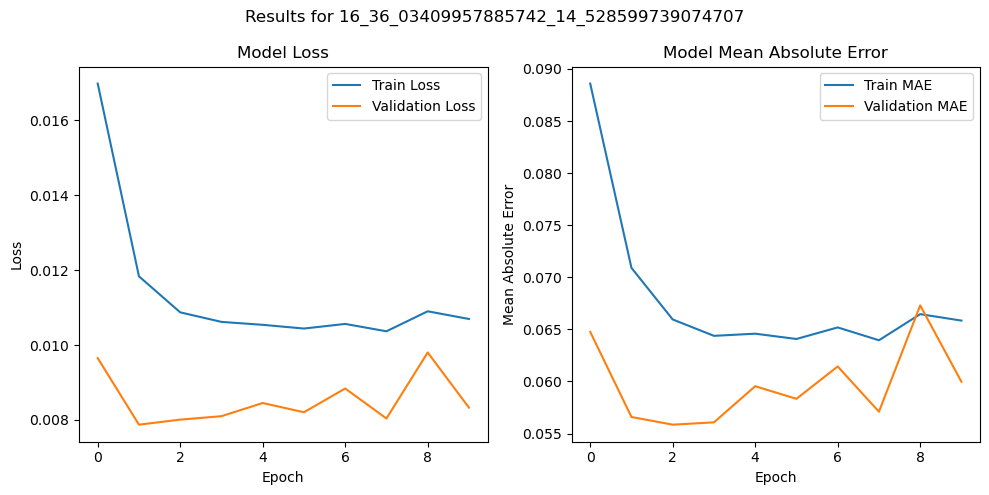

33/33 [==============================] - 13s 366ms/step

Test set Evaluation metrics for file: 16_36_03409957885742_14_528599739074707
Mean Squared Error (MSE): 0.003483715277707454
Mean Absolute Error (MAE): 0.04607552669435953
Root Mean Squared Error (RMSE): 0.05902300634250558



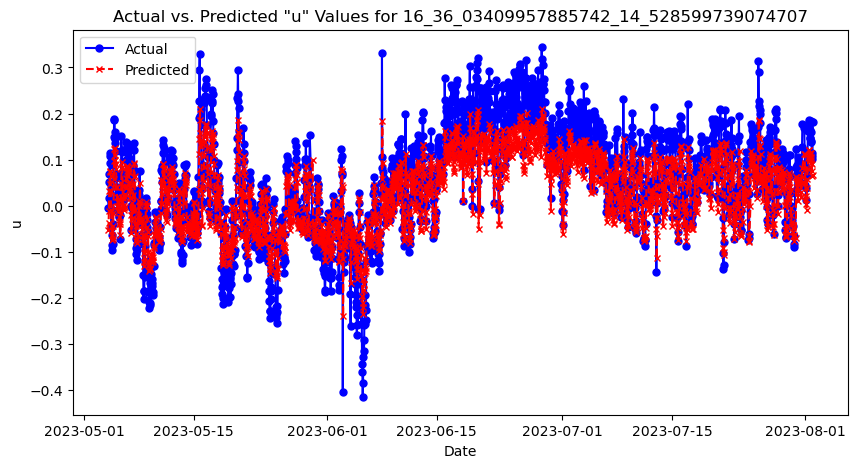

Model tarining & evaluation completed for file: 16_36_03409957885742_14_528599739074707.csv

Processing file: 17_36_03409957885742_14_569199562072754.csv

Epoch 1/100
153/153 [==============================] - ETA: 0s - loss: 0.0152 - mean_absolute_error: 0.0857INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\17_36_03409957885742_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\17_36_03409957885742_14_569199562072754\assets


153/153 [==============================] - 327s 2s/step - loss: 0.0152 - mean_absolute_error: 0.0857 - val_loss: 0.0087 - val_mean_absolute_error: 0.0660
Epoch 2/100
153/153 [==============================] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.0716INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\17_36_03409957885742_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\17_36_03409957885742_14_569199562072754\assets


153/153 [==============================] - 324s 2s/step - loss: 0.0111 - mean_absolute_error: 0.0716 - val_loss: 0.0065 - val_mean_absolute_error: 0.0556
Epoch 3/100
153/153 [==============================] - 320s 2s/step - loss: 0.0097 - mean_absolute_error: 0.0649 - val_loss: 0.0069 - val_mean_absolute_error: 0.0572
Epoch 4/100
153/153 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0635INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\17_36_03409957885742_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\17_36_03409957885742_14_569199562072754\assets


153/153 [==============================] - 323s 2s/step - loss: 0.0096 - mean_absolute_error: 0.0635 - val_loss: 0.0064 - val_mean_absolute_error: 0.0545
Epoch 5/100
153/153 [==============================] - 343s 2s/step - loss: 0.0093 - mean_absolute_error: 0.0623 - val_loss: 0.0067 - val_mean_absolute_error: 0.0576
Epoch 6/100
153/153 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0606INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\17_36_03409957885742_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\17_36_03409957885742_14_569199562072754\assets


153/153 [==============================] - 358s 2s/step - loss: 0.0089 - mean_absolute_error: 0.0606 - val_loss: 0.0061 - val_mean_absolute_error: 0.0519
Epoch 7/100
153/153 [==============================] - 357s 2s/step - loss: 0.0090 - mean_absolute_error: 0.0609 - val_loss: 0.0063 - val_mean_absolute_error: 0.0538
Epoch 8/100
153/153 [==============================] - 367s 2s/step - loss: 0.0090 - mean_absolute_error: 0.0605 - val_loss: 0.0061 - val_mean_absolute_error: 0.0524
Epoch 9/100
153/153 [==============================] - 369s 2s/step - loss: 0.0090 - mean_absolute_error: 0.0606 - val_loss: 0.0064 - val_mean_absolute_error: 0.0541
Epoch 10/100
153/153 [==============================] - 368s 2s/step - loss: 0.0088 - mean_absolute_error: 0.0602 - val_loss: 0.0062 - val_mean_absolute_error: 0.0529
Epoch 11/100
153/153 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0597INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\17_36_0

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\17_36_03409957885742_14_569199562072754\assets


153/153 [==============================] - 366s 2s/step - loss: 0.0088 - mean_absolute_error: 0.0597 - val_loss: 0.0060 - val_mean_absolute_error: 0.0518
Epoch 12/100
153/153 [==============================] - 335s 2s/step - loss: 0.0088 - mean_absolute_error: 0.0596 - val_loss: 0.0062 - val_mean_absolute_error: 0.0530
Epoch 13/100
153/153 [==============================] - 334s 2s/step - loss: 0.0087 - mean_absolute_error: 0.0594 - val_loss: 0.0064 - val_mean_absolute_error: 0.0538
Epoch 14/100
153/153 [==============================] - 334s 2s/step - loss: 0.0087 - mean_absolute_error: 0.0591 - val_loss: 0.0061 - val_mean_absolute_error: 0.0512
Epoch 15/100
153/153 [==============================] - 335s 2s/step - loss: 0.0087 - mean_absolute_error: 0.0593 - val_loss: 0.0062 - val_mean_absolute_error: 0.0526
Epoch 16/100
153/153 [==============================] - 335s 2s/step - loss: 0.0087 - mean_absolute_error: 0.0592 - val_loss: 0.0067 - val_mean_absolute_error: 0.0552
Epoch 17/10

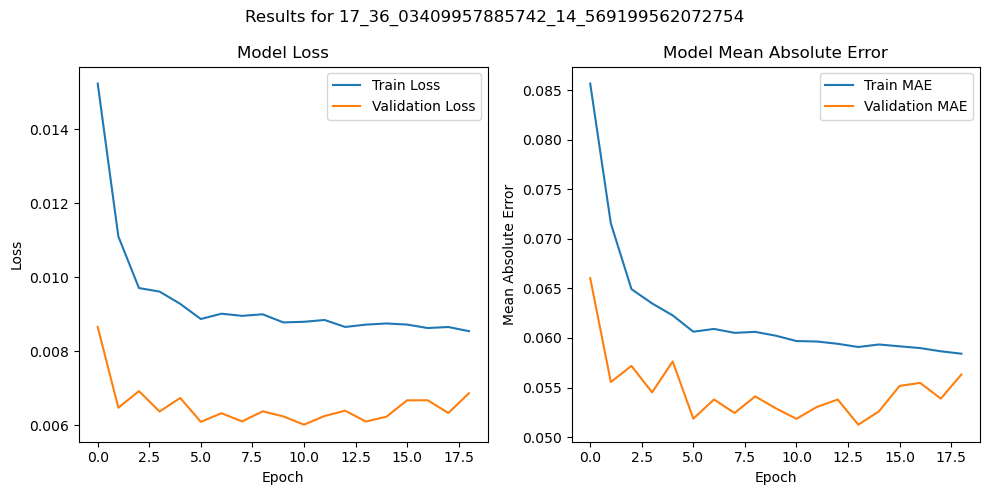

32/32 [==============================] - 13s 387ms/step

Test set Evaluation metrics for file: 17_36_03409957885742_14_569199562072754
Mean Squared Error (MSE): 0.003060074287788908
Mean Absolute Error (MAE): 0.04354820097227057
Root Mean Squared Error (RMSE): 0.055317938209851134



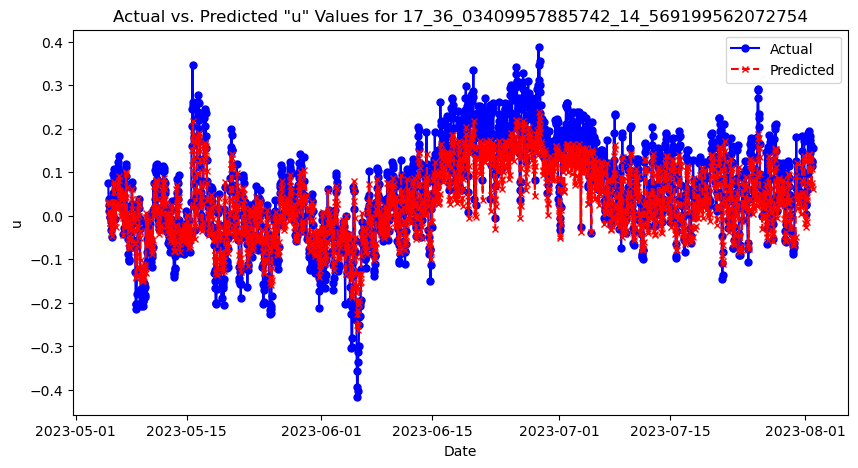

Model tarining & evaluation completed for file: 17_36_03409957885742_14_569199562072754.csv

Processing file: 18_36_056400299072266_14_447500228881836.csv

Epoch 1/100
128/128 [==============================] - ETA: 0s - loss: 0.0122 - mean_absolute_error: 0.0810INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 267s 2s/step - loss: 0.0122 - mean_absolute_error: 0.0810 - val_loss: 0.0057 - val_mean_absolute_error: 0.0522
Epoch 2/100
128/128 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0588INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 263s 2s/step - loss: 0.0074 - mean_absolute_error: 0.0588 - val_loss: 0.0039 - val_mean_absolute_error: 0.0368
Epoch 3/100
128/128 [==============================] - 263s 2s/step - loss: 0.0065 - mean_absolute_error: 0.0532 - val_loss: 0.0040 - val_mean_absolute_error: 0.0372
Epoch 4/100
128/128 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0517INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 266s 2s/step - loss: 0.0062 - mean_absolute_error: 0.0517 - val_loss: 0.0039 - val_mean_absolute_error: 0.0368
Epoch 5/100
128/128 [==============================] - 278s 2s/step - loss: 0.0064 - mean_absolute_error: 0.0519 - val_loss: 0.0039 - val_mean_absolute_error: 0.0374
Epoch 6/100
128/128 [==============================] - 277s 2s/step - loss: 0.0062 - mean_absolute_error: 0.0511 - val_loss: 0.0039 - val_mean_absolute_error: 0.0370
Epoch 7/100
128/128 [==============================] - 278s 2s/step - loss: 0.0062 - mean_absolute_error: 0.0511 - val_loss: 0.0041 - val_mean_absolute_error: 0.0390
Epoch 8/100
128/128 [==============================] - 277s 2s/step - loss: 0.0064 - mean_absolute_error: 0.0526 - val_loss: 0.0044 - val_mean_absolute_error: 0.0433
Epoch 9/100
128/128 [==============================] - 281s 2s/step - loss: 0.0063 - mean_absolute_error: 0.0518 - val_loss: 0.0041 - val_mean_absolute_error: 0.0399
Epoch 10/100
128

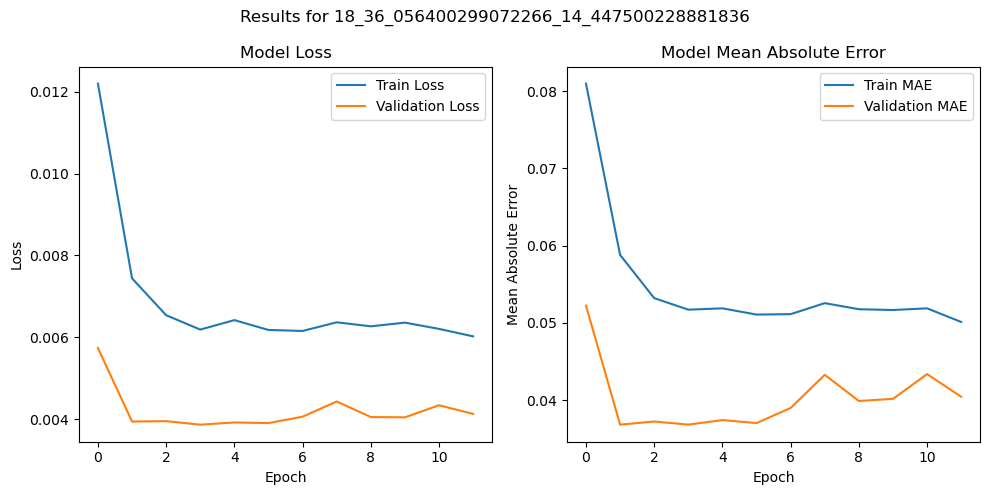

27/27 [==============================] - 11s 380ms/step

Test set Evaluation metrics for file: 18_36_056400299072266_14_447500228881836
Mean Squared Error (MSE): 0.0023286109829416665
Mean Absolute Error (MAE): 0.03768447512328868
Root Mean Squared Error (RMSE): 0.04825568342632468



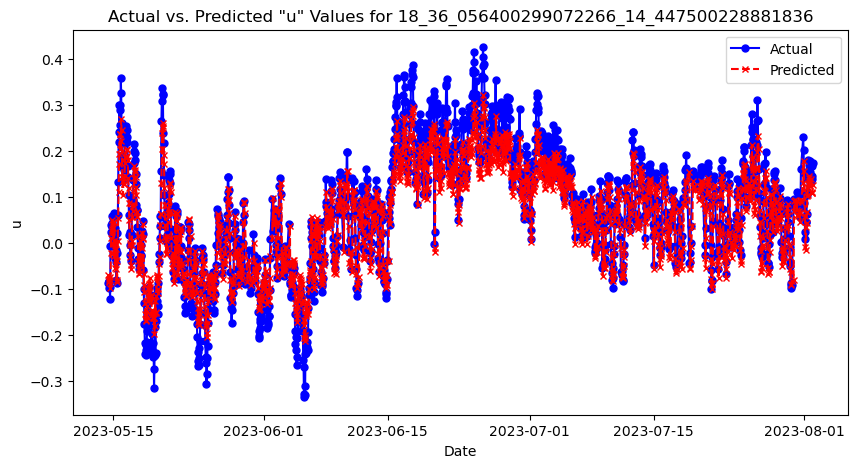

Model tarining & evaluation completed for file: 18_36_056400299072266_14_447500228881836.csv

Processing file: 19_36_056400299072266_14_48799991607666.csv

Epoch 1/100
138/138 [==============================] - ETA: 0s - loss: 0.0151 - mean_absolute_error: 0.0877INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\19_36_056400299072266_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\19_36_056400299072266_14_48799991607666\assets


138/138 [==============================] - 302s 2s/step - loss: 0.0151 - mean_absolute_error: 0.0877 - val_loss: 0.0068 - val_mean_absolute_error: 0.0560
Epoch 2/100
138/138 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0668INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\19_36_056400299072266_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\19_36_056400299072266_14_48799991607666\assets


138/138 [==============================] - 302s 2s/step - loss: 0.0098 - mean_absolute_error: 0.0668 - val_loss: 0.0049 - val_mean_absolute_error: 0.0420
Epoch 3/100
138/138 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0604INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\19_36_056400299072266_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\19_36_056400299072266_14_48799991607666\assets


138/138 [==============================] - 306s 2s/step - loss: 0.0087 - mean_absolute_error: 0.0604 - val_loss: 0.0049 - val_mean_absolute_error: 0.0403
Epoch 4/100
138/138 [==============================] - 287s 2s/step - loss: 0.0084 - mean_absolute_error: 0.0590 - val_loss: 0.0051 - val_mean_absolute_error: 0.0446
Epoch 5/100
138/138 [==============================] - 302s 2s/step - loss: 0.0086 - mean_absolute_error: 0.0599 - val_loss: 0.0051 - val_mean_absolute_error: 0.0446
Epoch 6/100
138/138 [==============================] - 324s 2s/step - loss: 0.0084 - mean_absolute_error: 0.0596 - val_loss: 0.0052 - val_mean_absolute_error: 0.0442
Epoch 7/100
138/138 [==============================] - 384s 3s/step - loss: 0.0081 - mean_absolute_error: 0.0578 - val_loss: 0.0051 - val_mean_absolute_error: 0.0425
Epoch 8/100
138/138 [==============================] - 291s 2s/step - loss: 0.0084 - mean_absolute_error: 0.0593 - val_loss: 0.0053 - val_mean_absolute_error: 0.0459
Epoch 9/100
138/

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\19_36_056400299072266_14_48799991607666\assets


138/138 [==============================] - 315s 2s/step - loss: 0.0081 - mean_absolute_error: 0.0569 - val_loss: 0.0047 - val_mean_absolute_error: 0.0399
Epoch 12/100
138/138 [==============================] - 321s 2s/step - loss: 0.0078 - mean_absolute_error: 0.0556 - val_loss: 0.0051 - val_mean_absolute_error: 0.0431
Epoch 13/100
138/138 [==============================] - 332s 2s/step - loss: 0.0078 - mean_absolute_error: 0.0552 - val_loss: 0.0047 - val_mean_absolute_error: 0.0386
Epoch 14/100
138/138 [==============================] - 364s 3s/step - loss: 0.0079 - mean_absolute_error: 0.0563 - val_loss: 0.0049 - val_mean_absolute_error: 0.0415
Epoch 15/100
138/138 [==============================] - 485s 4s/step - loss: 0.0078 - mean_absolute_error: 0.0553 - val_loss: 0.0052 - val_mean_absolute_error: 0.0445
Epoch 16/100
138/138 [==============================] - 334s 2s/step - loss: 0.0076 - mean_absolute_error: 0.0544 - val_loss: 0.0048 - val_mean_absolute_error: 0.0400
Epoch 17/10

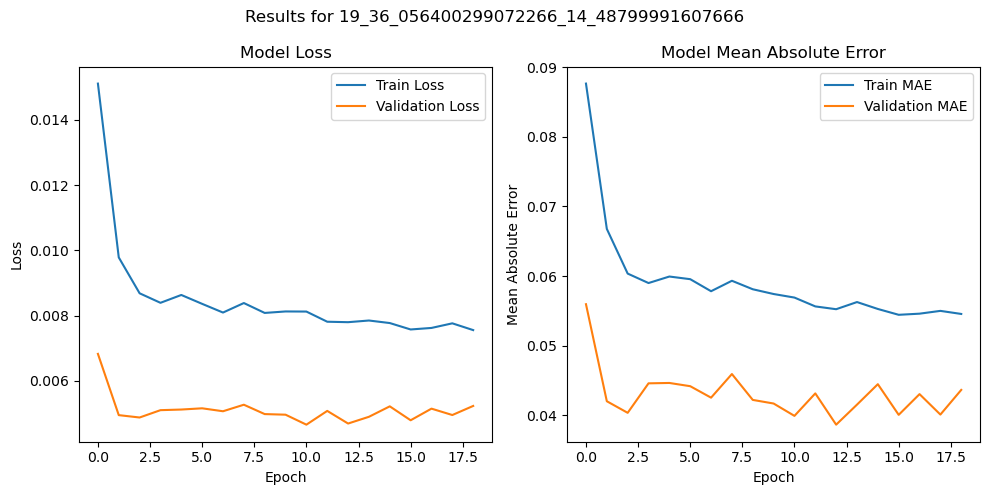

29/29 [==============================] - 11s 371ms/step

Test set Evaluation metrics for file: 19_36_056400299072266_14_48799991607666
Mean Squared Error (MSE): 0.0025172919554792405
Mean Absolute Error (MAE): 0.03842783360787866
Root Mean Squared Error (RMSE): 0.05017262157271873



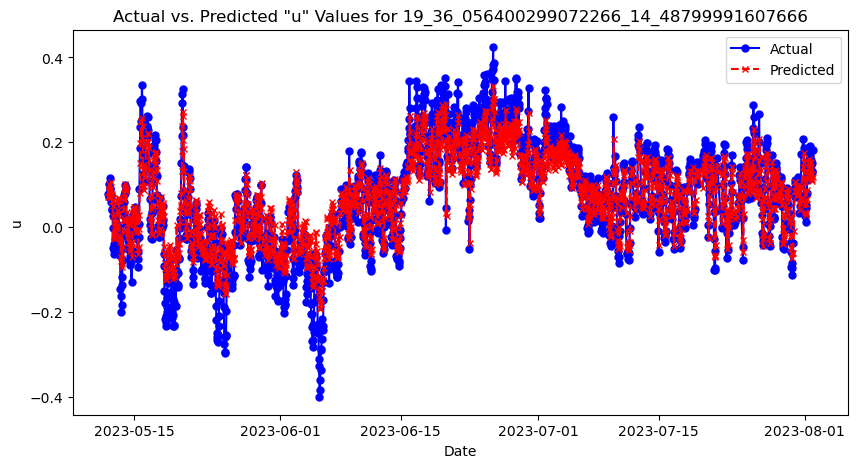

Model tarining & evaluation completed for file: 19_36_056400299072266_14_48799991607666.csv

Processing file: 20_36_056400299072266_14_528599739074707.csv

Epoch 1/100
156/156 [==============================] - ETA: 0s - loss: 0.0157 - mean_absolute_error: 0.0892INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\20_36_056400299072266_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\20_36_056400299072266_14_528599739074707\assets


156/156 [==============================] - 334s 2s/step - loss: 0.0157 - mean_absolute_error: 0.0892 - val_loss: 0.0101 - val_mean_absolute_error: 0.0691
Epoch 2/100
156/156 [==============================] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0671INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\20_36_056400299072266_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\20_36_056400299072266_14_528599739074707\assets


156/156 [==============================] - 336s 2s/step - loss: 0.0102 - mean_absolute_error: 0.0671 - val_loss: 0.0074 - val_mean_absolute_error: 0.0552
Epoch 3/100
156/156 [==============================] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0630INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\20_36_056400299072266_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\20_36_056400299072266_14_528599739074707\assets


156/156 [==============================] - 332s 2s/step - loss: 0.0094 - mean_absolute_error: 0.0630 - val_loss: 0.0067 - val_mean_absolute_error: 0.0490
Epoch 4/100
156/156 [==============================] - 323s 2s/step - loss: 0.0093 - mean_absolute_error: 0.0618 - val_loss: 0.0071 - val_mean_absolute_error: 0.0522
Epoch 5/100
156/156 [==============================] - 323s 2s/step - loss: 0.0092 - mean_absolute_error: 0.0622 - val_loss: 0.0068 - val_mean_absolute_error: 0.0498
Epoch 6/100
156/156 [==============================] - 323s 2s/step - loss: 0.0094 - mean_absolute_error: 0.0623 - val_loss: 0.0067 - val_mean_absolute_error: 0.0489
Epoch 7/100
156/156 [==============================] - 323s 2s/step - loss: 0.0092 - mean_absolute_error: 0.0611 - val_loss: 0.0071 - val_mean_absolute_error: 0.0516
Epoch 8/100
156/156 [==============================] - 339s 2s/step - loss: 0.0092 - mean_absolute_error: 0.0614 - val_loss: 0.0070 - val_mean_absolute_error: 0.0513
Epoch 9/100
156/

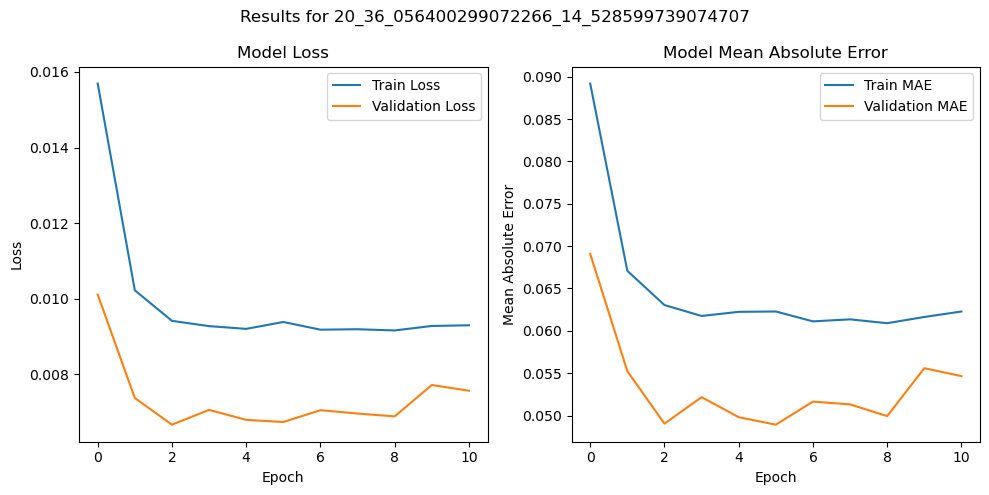

33/33 [==============================] - 14s 416ms/step

Test set Evaluation metrics for file: 20_36_056400299072266_14_528599739074707
Mean Squared Error (MSE): 0.0027898248687121025
Mean Absolute Error (MAE): 0.040558379539267206
Root Mean Squared Error (RMSE): 0.052818792760835634



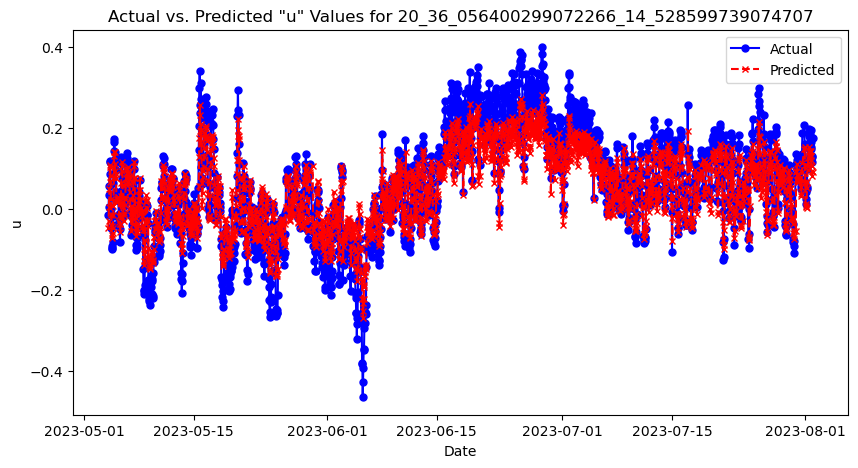

Model tarining & evaluation completed for file: 20_36_056400299072266_14_528599739074707.csv

Processing file: 21_36_056400299072266_14_569199562072754.csv

Epoch 1/100
154/154 [==============================] - ETA: 0s - loss: 0.0161 - mean_absolute_error: 0.0894INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\21_36_056400299072266_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\21_36_056400299072266_14_569199562072754\assets


154/154 [==============================] - 346s 2s/step - loss: 0.0161 - mean_absolute_error: 0.0894 - val_loss: 0.0081 - val_mean_absolute_error: 0.0676
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0766INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\21_36_056400299072266_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\21_36_056400299072266_14_569199562072754\assets


154/154 [==============================] - 322s 2s/step - loss: 0.0126 - mean_absolute_error: 0.0766 - val_loss: 0.0075 - val_mean_absolute_error: 0.0653
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0679INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\21_36_056400299072266_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\21_36_056400299072266_14_569199562072754\assets


154/154 [==============================] - 345s 2s/step - loss: 0.0102 - mean_absolute_error: 0.0679 - val_loss: 0.0061 - val_mean_absolute_error: 0.0559
Epoch 4/100
154/154 [==============================] - 321s 2s/step - loss: 0.0098 - mean_absolute_error: 0.0647 - val_loss: 0.0067 - val_mean_absolute_error: 0.0596
Epoch 5/100
154/154 [==============================] - 322s 2s/step - loss: 0.0100 - mean_absolute_error: 0.0650 - val_loss: 0.0061 - val_mean_absolute_error: 0.0546
Epoch 6/100
154/154 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0638INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\21_36_056400299072266_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\21_36_056400299072266_14_569199562072754\assets


154/154 [==============================] - 325s 2s/step - loss: 0.0095 - mean_absolute_error: 0.0638 - val_loss: 0.0059 - val_mean_absolute_error: 0.0542
Epoch 7/100
154/154 [==============================] - 312s 2s/step - loss: 0.0095 - mean_absolute_error: 0.0634 - val_loss: 0.0063 - val_mean_absolute_error: 0.0574
Epoch 8/100
154/154 [==============================] - 314s 2s/step - loss: 0.0100 - mean_absolute_error: 0.0647 - val_loss: 0.0064 - val_mean_absolute_error: 0.0578
Epoch 9/100
154/154 [==============================] - 329s 2s/step - loss: 0.0097 - mean_absolute_error: 0.0645 - val_loss: 0.0062 - val_mean_absolute_error: 0.0563
Epoch 10/100
154/154 [==============================] - 313s 2s/step - loss: 0.0095 - mean_absolute_error: 0.0635 - val_loss: 0.0061 - val_mean_absolute_error: 0.0559
Epoch 11/100
154/154 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0637INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\21_36_0

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\21_36_056400299072266_14_569199562072754\assets


154/154 [==============================] - 316s 2s/step - loss: 0.0097 - mean_absolute_error: 0.0637 - val_loss: 0.0057 - val_mean_absolute_error: 0.0526
Epoch 12/100
154/154 [==============================] - 310s 2s/step - loss: 0.0093 - mean_absolute_error: 0.0624 - val_loss: 0.0061 - val_mean_absolute_error: 0.0553
Epoch 13/100
154/154 [==============================] - 328s 2s/step - loss: 0.0094 - mean_absolute_error: 0.0619 - val_loss: 0.0060 - val_mean_absolute_error: 0.0552
Epoch 14/100
154/154 [==============================] - 331s 2s/step - loss: 0.0093 - mean_absolute_error: 0.0614 - val_loss: 0.0060 - val_mean_absolute_error: 0.0544
Epoch 15/100
154/154 [==============================] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0614INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\21_36_056400299072266_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\21_36_056400299072266_14_569199562072754\assets


154/154 [==============================] - 335s 2s/step - loss: 0.0093 - mean_absolute_error: 0.0614 - val_loss: 0.0055 - val_mean_absolute_error: 0.0507
Epoch 16/100
154/154 [==============================] - 326s 2s/step - loss: 0.0091 - mean_absolute_error: 0.0607 - val_loss: 0.0062 - val_mean_absolute_error: 0.0554
Epoch 17/100
154/154 [==============================] - 330s 2s/step - loss: 0.0091 - mean_absolute_error: 0.0616 - val_loss: 0.0057 - val_mean_absolute_error: 0.0524
Epoch 18/100
154/154 [==============================] - 330s 2s/step - loss: 0.0091 - mean_absolute_error: 0.0616 - val_loss: 0.0058 - val_mean_absolute_error: 0.0536
Epoch 19/100
154/154 [==============================] - 333s 2s/step - loss: 0.0090 - mean_absolute_error: 0.0605 - val_loss: 0.0057 - val_mean_absolute_error: 0.0517
Epoch 20/100
154/154 [==============================] - 331s 2s/step - loss: 0.0090 - mean_absolute_error: 0.0601 - val_loss: 0.0058 - val_mean_absolute_error: 0.0518
Epoch 21/10

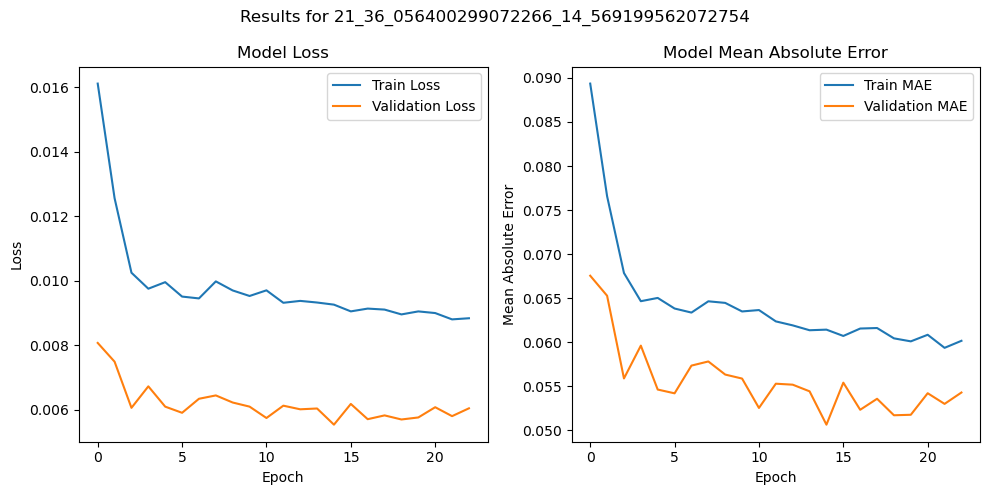

32/32 [==============================] - 14s 424ms/step

Test set Evaluation metrics for file: 21_36_056400299072266_14_569199562072754
Mean Squared Error (MSE): 0.003298651272861819
Mean Absolute Error (MAE): 0.04500528606134169
Root Mean Squared Error (RMSE): 0.05743388610273398



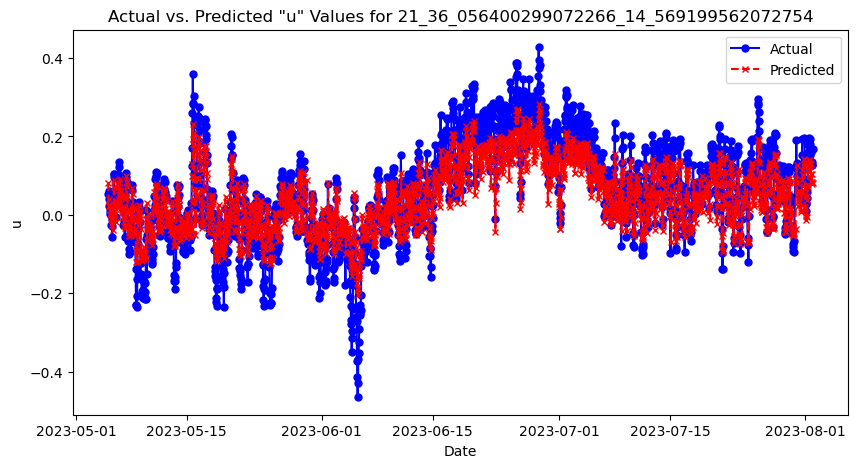

Model tarining & evaluation completed for file: 21_36_056400299072266_14_569199562072754.csv

Processing file: 22_36_07870101928711_14_366399765014648.csv

Epoch 1/100
103/103 [==============================] - ETA: 0s - loss: 0.0162 - mean_absolute_error: 0.0969INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\22_36_07870101928711_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\22_36_07870101928711_14_366399765014648\assets


103/103 [==============================] - 217s 2s/step - loss: 0.0162 - mean_absolute_error: 0.0969 - val_loss: 0.0062 - val_mean_absolute_error: 0.0620
Epoch 2/100
103/103 [==============================] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0727INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\22_36_07870101928711_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\22_36_07870101928711_14_366399765014648\assets


103/103 [==============================] - 214s 2s/step - loss: 0.0101 - mean_absolute_error: 0.0727 - val_loss: 0.0048 - val_mean_absolute_error: 0.0544
Epoch 3/100
103/103 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0632INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\22_36_07870101928711_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\22_36_07870101928711_14_366399765014648\assets


103/103 [==============================] - 209s 2s/step - loss: 0.0081 - mean_absolute_error: 0.0632 - val_loss: 0.0031 - val_mean_absolute_error: 0.0406
Epoch 4/100
103/103 [==============================] - 229s 2s/step - loss: 0.0075 - mean_absolute_error: 0.0589 - val_loss: 0.0035 - val_mean_absolute_error: 0.0411
Epoch 5/100
103/103 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0589INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\22_36_07870101928711_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\22_36_07870101928711_14_366399765014648\assets


103/103 [==============================] - 233s 2s/step - loss: 0.0074 - mean_absolute_error: 0.0589 - val_loss: 0.0029 - val_mean_absolute_error: 0.0376
Epoch 6/100
103/103 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0569INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\22_36_07870101928711_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\22_36_07870101928711_14_366399765014648\assets


103/103 [==============================] - 240s 2s/step - loss: 0.0071 - mean_absolute_error: 0.0569 - val_loss: 0.0027 - val_mean_absolute_error: 0.0358
Epoch 7/100
103/103 [==============================] - 239s 2s/step - loss: 0.0072 - mean_absolute_error: 0.0573 - val_loss: 0.0029 - val_mean_absolute_error: 0.0372
Epoch 8/100
103/103 [==============================] - 226s 2s/step - loss: 0.0073 - mean_absolute_error: 0.0580 - val_loss: 0.0031 - val_mean_absolute_error: 0.0394
Epoch 9/100
103/103 [==============================] - 226s 2s/step - loss: 0.0071 - mean_absolute_error: 0.0570 - val_loss: 0.0033 - val_mean_absolute_error: 0.0407
Epoch 10/100
103/103 [==============================] - 228s 2s/step - loss: 0.0071 - mean_absolute_error: 0.0572 - val_loss: 0.0030 - val_mean_absolute_error: 0.0380
Epoch 11/100
103/103 [==============================] - 227s 2s/step - loss: 0.0072 - mean_absolute_error: 0.0568 - val_loss: 0.0032 - val_mean_absolute_error: 0.0405
Epoch 12/100
1

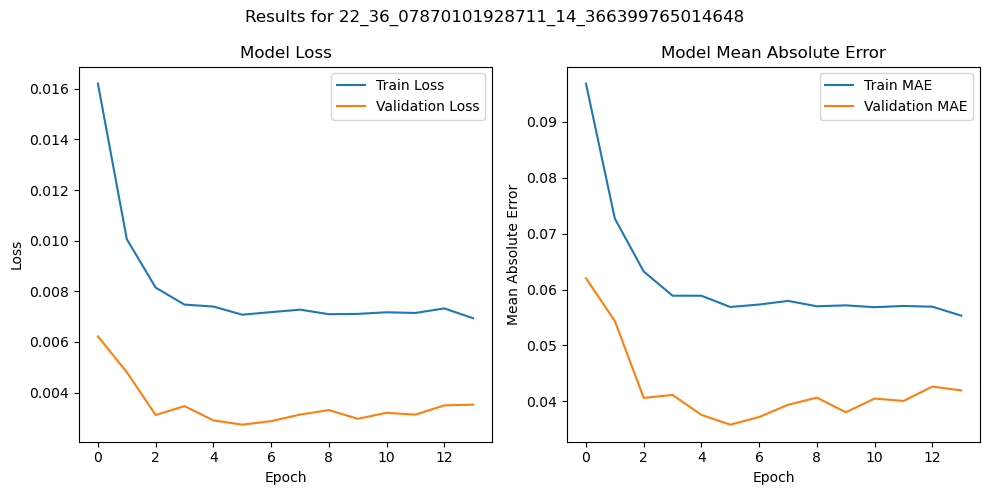

22/22 [==============================] - 9s 399ms/step

Test set Evaluation metrics for file: 22_36_07870101928711_14_366399765014648
Mean Squared Error (MSE): 0.003573361773945071
Mean Absolute Error (MAE): 0.04651430536864357
Root Mean Squared Error (RMSE): 0.05977760261122113



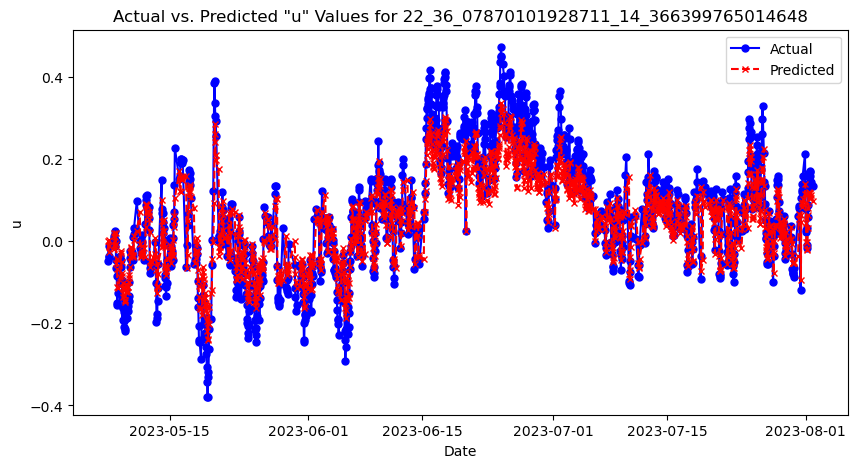

Model tarining & evaluation completed for file: 22_36_07870101928711_14_366399765014648.csv

Processing file: 23_36_07870101928711_14_406900405883789.csv

Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 0.0116 - mean_absolute_error: 0.0777INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\23_36_07870101928711_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 272s 2s/step - loss: 0.0116 - mean_absolute_error: 0.0777 - val_loss: 0.0065 - val_mean_absolute_error: 0.0590
Epoch 2/100
125/125 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0584INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\23_36_07870101928711_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 262s 2s/step - loss: 0.0073 - mean_absolute_error: 0.0584 - val_loss: 0.0049 - val_mean_absolute_error: 0.0476
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0539INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\23_36_07870101928711_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 263s 2s/step - loss: 0.0065 - mean_absolute_error: 0.0539 - val_loss: 0.0048 - val_mean_absolute_error: 0.0464
Epoch 4/100
125/125 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0532INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\23_36_07870101928711_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 269s 2s/step - loss: 0.0063 - mean_absolute_error: 0.0532 - val_loss: 0.0043 - val_mean_absolute_error: 0.0409
Epoch 5/100
125/125 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0550INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\23_36_07870101928711_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 292s 2s/step - loss: 0.0067 - mean_absolute_error: 0.0550 - val_loss: 0.0040 - val_mean_absolute_error: 0.0374
Epoch 6/100
125/125 [==============================] - 298s 2s/step - loss: 0.0063 - mean_absolute_error: 0.0530 - val_loss: 0.0040 - val_mean_absolute_error: 0.0369
Epoch 7/100
125/125 [==============================] - 295s 2s/step - loss: 0.0062 - mean_absolute_error: 0.0517 - val_loss: 0.0042 - val_mean_absolute_error: 0.0382
Epoch 8/100
125/125 [==============================] - 295s 2s/step - loss: 0.0061 - mean_absolute_error: 0.0512 - val_loss: 0.0044 - val_mean_absolute_error: 0.0403
Epoch 9/100
125/125 [==============================] - 296s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0508 - val_loss: 0.0040 - val_mean_absolute_error: 0.0364
Epoch 10/100
125/125 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0501INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\23_36_07

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 304s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0501 - val_loss: 0.0040 - val_mean_absolute_error: 0.0359
Epoch 11/100
125/125 [==============================] - 280s 2s/step - loss: 0.0061 - mean_absolute_error: 0.0513 - val_loss: 0.0042 - val_mean_absolute_error: 0.0396
Epoch 12/100
125/125 [==============================] - 279s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0507 - val_loss: 0.0041 - val_mean_absolute_error: 0.0377
Epoch 13/100
125/125 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0511INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\23_36_07870101928711_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 285s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0511 - val_loss: 0.0039 - val_mean_absolute_error: 0.0364
Epoch 14/100
125/125 [==============================] - 279s 2s/step - loss: 0.0059 - mean_absolute_error: 0.0501 - val_loss: 0.0040 - val_mean_absolute_error: 0.0373
Epoch 15/100
125/125 [==============================] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0501INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\23_36_07870101928711_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 285s 2s/step - loss: 0.0058 - mean_absolute_error: 0.0501 - val_loss: 0.0038 - val_mean_absolute_error: 0.0348
Epoch 16/100
125/125 [==============================] - 279s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0503 - val_loss: 0.0039 - val_mean_absolute_error: 0.0367
Epoch 17/100
125/125 [==============================] - 280s 2s/step - loss: 0.0059 - mean_absolute_error: 0.0494 - val_loss: 0.0040 - val_mean_absolute_error: 0.0364
Epoch 18/100
125/125 [==============================] - 278s 2s/step - loss: 0.0061 - mean_absolute_error: 0.0514 - val_loss: 0.0041 - val_mean_absolute_error: 0.0386
Epoch 19/100
125/125 [==============================] - 280s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0503 - val_loss: 0.0040 - val_mean_absolute_error: 0.0369
Epoch 20/100
125/125 [==============================] - 286s 2s/step - loss: 0.0061 - mean_absolute_error: 0.0508 - val_loss: 0.0039 - val_mean_absolute_error: 0.0358
Epoch 21/10

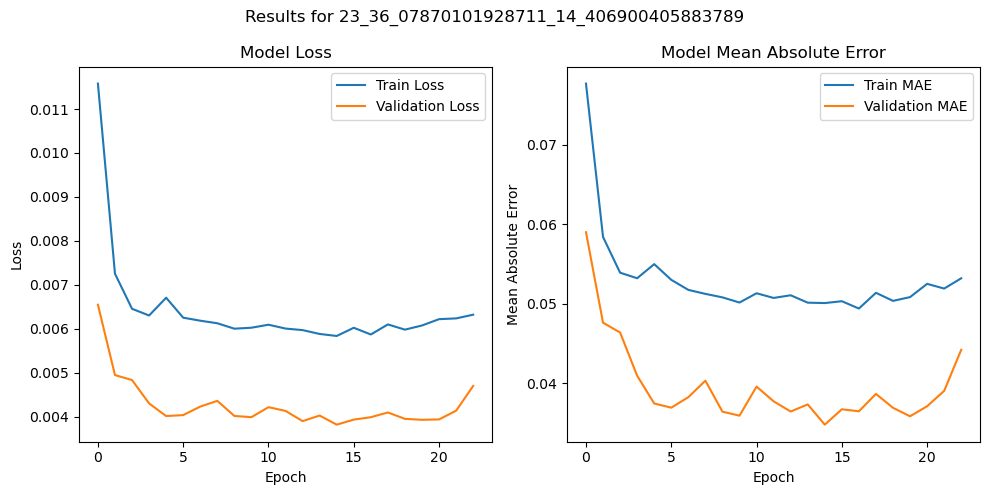

26/26 [==============================] - 12s 438ms/step

Test set Evaluation metrics for file: 23_36_07870101928711_14_406900405883789
Mean Squared Error (MSE): 0.0022390504243845707
Mean Absolute Error (MAE): 0.03566239605447102
Root Mean Squared Error (RMSE): 0.0473186054780207



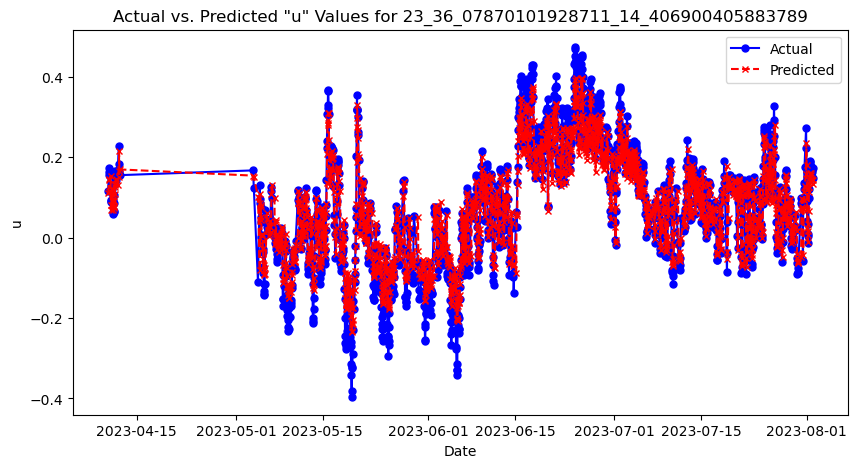

Model tarining & evaluation completed for file: 23_36_07870101928711_14_406900405883789.csv

Processing file: 24_36_07870101928711_14_447500228881836.csv

Epoch 1/100
151/151 [==============================] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.0831INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 342s 2s/step - loss: 0.0133 - mean_absolute_error: 0.0831 - val_loss: 0.0063 - val_mean_absolute_error: 0.0506
Epoch 2/100
151/151 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0614INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 336s 2s/step - loss: 0.0084 - mean_absolute_error: 0.0614 - val_loss: 0.0054 - val_mean_absolute_error: 0.0424
Epoch 3/100
151/151 [==============================] - 362s 2s/step - loss: 0.0078 - mean_absolute_error: 0.0579 - val_loss: 0.0056 - val_mean_absolute_error: 0.0458
Epoch 4/100
151/151 [==============================] - 363s 2s/step - loss: 0.0078 - mean_absolute_error: 0.0579 - val_loss: 0.0059 - val_mean_absolute_error: 0.0487
Epoch 5/100
151/151 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0587INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 368s 2s/step - loss: 0.0079 - mean_absolute_error: 0.0587 - val_loss: 0.0054 - val_mean_absolute_error: 0.0425
Epoch 6/100
151/151 [==============================] - 355s 2s/step - loss: 0.0075 - mean_absolute_error: 0.0563 - val_loss: 0.0055 - val_mean_absolute_error: 0.0442
Epoch 7/100
151/151 [==============================] - 354s 2s/step - loss: 0.0075 - mean_absolute_error: 0.0561 - val_loss: 0.0056 - val_mean_absolute_error: 0.0455
Epoch 8/100
151/151 [==============================] - 355s 2s/step - loss: 0.0075 - mean_absolute_error: 0.0566 - val_loss: 0.0055 - val_mean_absolute_error: 0.0450
Epoch 9/100
151/151 [==============================] - 356s 2s/step - loss: 0.0076 - mean_absolute_error: 0.0568 - val_loss: 0.0057 - val_mean_absolute_error: 0.0465
Epoch 10/100
151/151 [==============================] - 355s 2s/step - loss: 0.0074 - mean_absolute_error: 0.0553 - val_loss: 0.0056 - val_mean_absolute_error: 0.0455
Epoch 11/100
15

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 362s 2s/step - loss: 0.0073 - mean_absolute_error: 0.0552 - val_loss: 0.0053 - val_mean_absolute_error: 0.0435
Epoch 13/100
151/151 [==============================] - 346s 2s/step - loss: 0.0073 - mean_absolute_error: 0.0555 - val_loss: 0.0057 - val_mean_absolute_error: 0.0458
Epoch 14/100
151/151 [==============================] - 348s 2s/step - loss: 0.0075 - mean_absolute_error: 0.0560 - val_loss: 0.0056 - val_mean_absolute_error: 0.0456
Epoch 15/100
151/151 [==============================] - 348s 2s/step - loss: 0.0072 - mean_absolute_error: 0.0550 - val_loss: 0.0056 - val_mean_absolute_error: 0.0456
Epoch 16/100
151/151 [==============================] - 348s 2s/step - loss: 0.0074 - mean_absolute_error: 0.0556 - val_loss: 0.0055 - val_mean_absolute_error: 0.0454
Epoch 17/100
151/151 [==============================] - 347s 2s/step - loss: 0.0074 - mean_absolute_error: 0.0567 - val_loss: 0.0058 - val_mean_absolute_error: 0.0470
Epoch 18/10

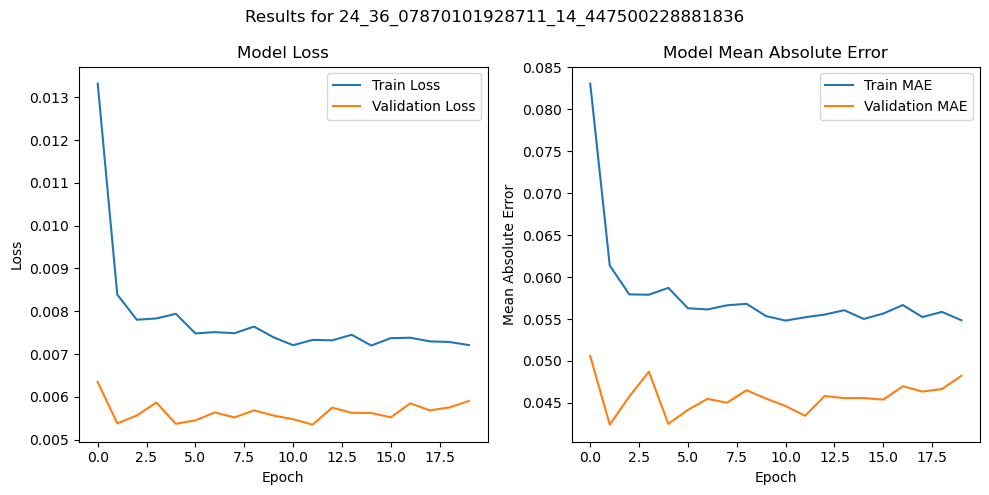

32/32 [==============================] - 15s 453ms/step

Test set Evaluation metrics for file: 24_36_07870101928711_14_447500228881836
Mean Squared Error (MSE): 0.003111231709876431
Mean Absolute Error (MAE): 0.04314005855264981
Root Mean Squared Error (RMSE): 0.05577841616500446



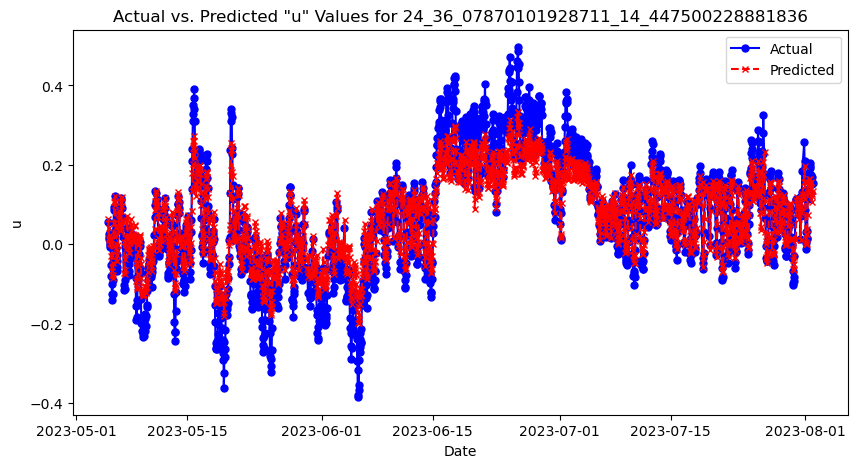

Model tarining & evaluation completed for file: 24_36_07870101928711_14_447500228881836.csv

Processing file: 25_36_07870101928711_14_48799991607666.csv

Epoch 1/100
154/154 [==============================] - ETA: 0s - loss: 0.0145 - mean_absolute_error: 0.0847INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\25_36_07870101928711_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\25_36_07870101928711_14_48799991607666\assets


154/154 [==============================] - 375s 2s/step - loss: 0.0145 - mean_absolute_error: 0.0847 - val_loss: 0.0089 - val_mean_absolute_error: 0.0621
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.0651INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\25_36_07870101928711_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\25_36_07870101928711_14_48799991607666\assets


154/154 [==============================] - 345s 2s/step - loss: 0.0099 - mean_absolute_error: 0.0651 - val_loss: 0.0075 - val_mean_absolute_error: 0.0527
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0627INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\25_36_07870101928711_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\25_36_07870101928711_14_48799991607666\assets


154/154 [==============================] - 352s 2s/step - loss: 0.0092 - mean_absolute_error: 0.0627 - val_loss: 0.0069 - val_mean_absolute_error: 0.0472
Epoch 4/100
154/154 [==============================] - 385s 3s/step - loss: 0.0091 - mean_absolute_error: 0.0614 - val_loss: 0.0070 - val_mean_absolute_error: 0.0482
Epoch 5/100
154/154 [==============================] - 376s 2s/step - loss: 0.0090 - mean_absolute_error: 0.0612 - val_loss: 0.0071 - val_mean_absolute_error: 0.0481
Epoch 6/100
154/154 [==============================] - 368s 2s/step - loss: 0.0094 - mean_absolute_error: 0.0628 - val_loss: 0.0074 - val_mean_absolute_error: 0.0505
Epoch 7/100
154/154 [==============================] - 374s 2s/step - loss: 0.0093 - mean_absolute_error: 0.0629 - val_loss: 0.0081 - val_mean_absolute_error: 0.0550
Epoch 8/100
154/154 [==============================] - 378s 2s/step - loss: 0.0089 - mean_absolute_error: 0.0608 - val_loss: 0.0077 - val_mean_absolute_error: 0.0523
Epoch 9/100
154/

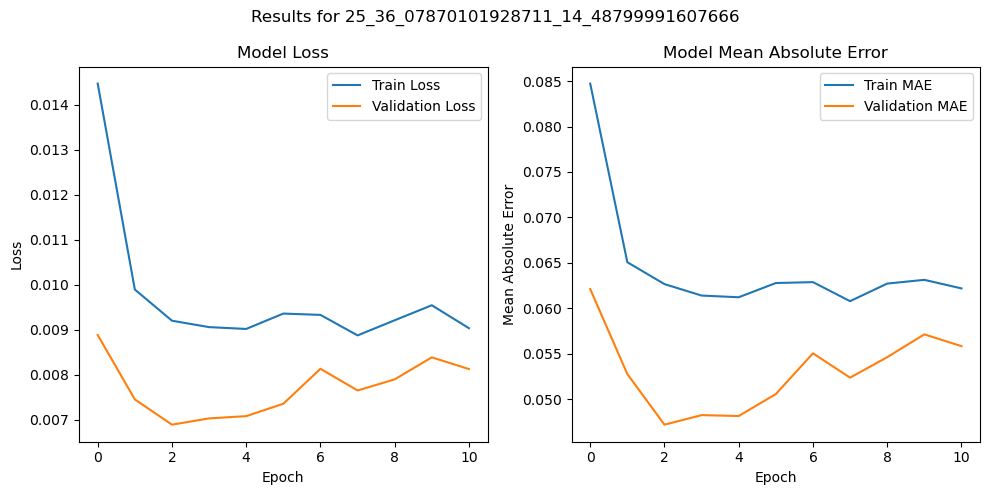

33/33 [==============================] - 16s 471ms/step

Test set Evaluation metrics for file: 25_36_07870101928711_14_48799991607666
Mean Squared Error (MSE): 0.0026880048387974594
Mean Absolute Error (MAE): 0.040649114837015776
Root Mean Squared Error (RMSE): 0.051845972252407994



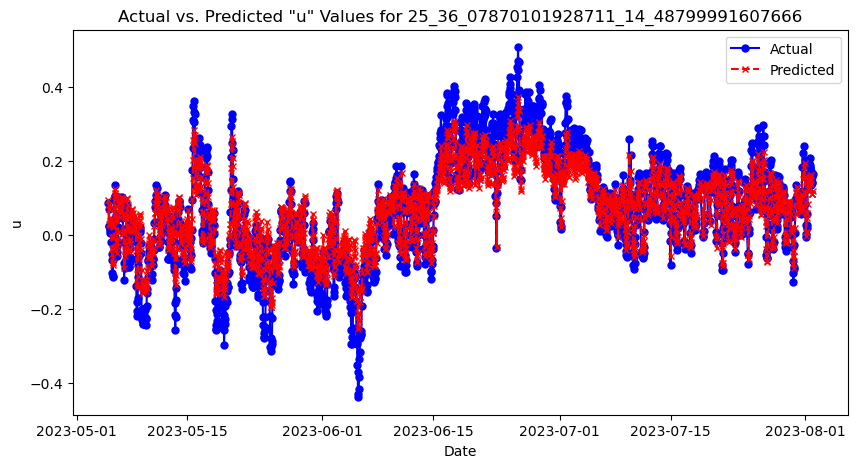

Model tarining & evaluation completed for file: 25_36_07870101928711_14_48799991607666.csv

Processing file: 26_36_07870101928711_14_528599739074707.csv

Epoch 1/100
174/174 [==============================] - ETA: 0s - loss: 0.0159 - mean_absolute_error: 0.0894INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\26_36_07870101928711_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\26_36_07870101928711_14_528599739074707\assets


174/174 [==============================] - 378s 2s/step - loss: 0.0159 - mean_absolute_error: 0.0894 - val_loss: 0.0115 - val_mean_absolute_error: 0.0704
Epoch 2/100
174/174 [==============================] - ETA: 0s - loss: 0.0114 - mean_absolute_error: 0.0722INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\26_36_07870101928711_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\26_36_07870101928711_14_528599739074707\assets


174/174 [==============================] - 372s 2s/step - loss: 0.0114 - mean_absolute_error: 0.0722 - val_loss: 0.0106 - val_mean_absolute_error: 0.0641
Epoch 3/100
174/174 [==============================] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.0676INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\26_36_07870101928711_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\26_36_07870101928711_14_528599739074707\assets


174/174 [==============================] - 372s 2s/step - loss: 0.0105 - mean_absolute_error: 0.0676 - val_loss: 0.0098 - val_mean_absolute_error: 0.0585
Epoch 4/100
174/174 [==============================] - 378s 2s/step - loss: 0.0104 - mean_absolute_error: 0.0663 - val_loss: 0.0101 - val_mean_absolute_error: 0.0607
Epoch 5/100
174/174 [==============================] - 377s 2s/step - loss: 0.0102 - mean_absolute_error: 0.0665 - val_loss: 0.0100 - val_mean_absolute_error: 0.0608
Epoch 6/100
174/174 [==============================] - 380s 2s/step - loss: 0.0102 - mean_absolute_error: 0.0667 - val_loss: 0.0101 - val_mean_absolute_error: 0.0617
Epoch 7/100
174/174 [==============================] - 382s 2s/step - loss: 0.0101 - mean_absolute_error: 0.0659 - val_loss: 0.0100 - val_mean_absolute_error: 0.0599
Epoch 8/100
174/174 [==============================] - 378s 2s/step - loss: 0.0102 - mean_absolute_error: 0.0659 - val_loss: 0.0099 - val_mean_absolute_error: 0.0600
Epoch 9/100
174/

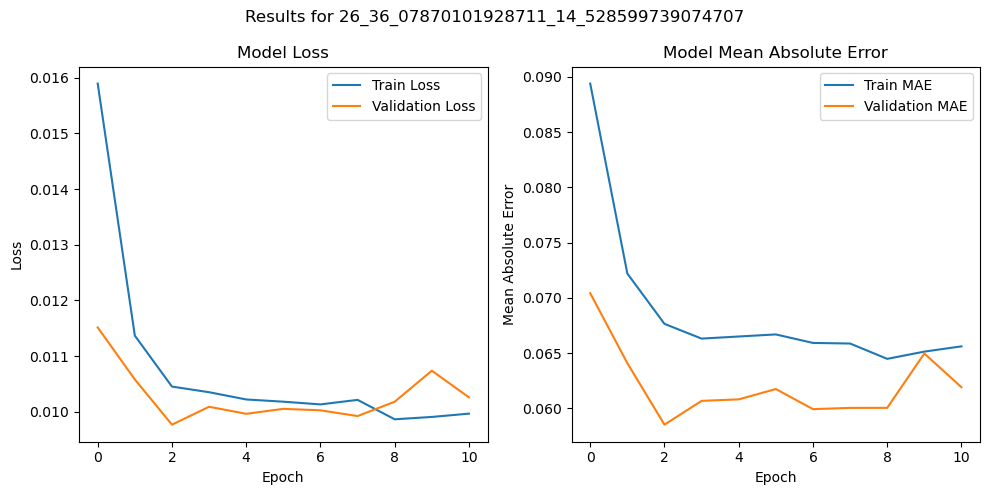

37/37 [==============================] - 17s 435ms/step

Test set Evaluation metrics for file: 26_36_07870101928711_14_528599739074707
Mean Squared Error (MSE): 0.003286933573508833
Mean Absolute Error (MAE): 0.044273499724780105
Root Mean Squared Error (RMSE): 0.057331785019383734



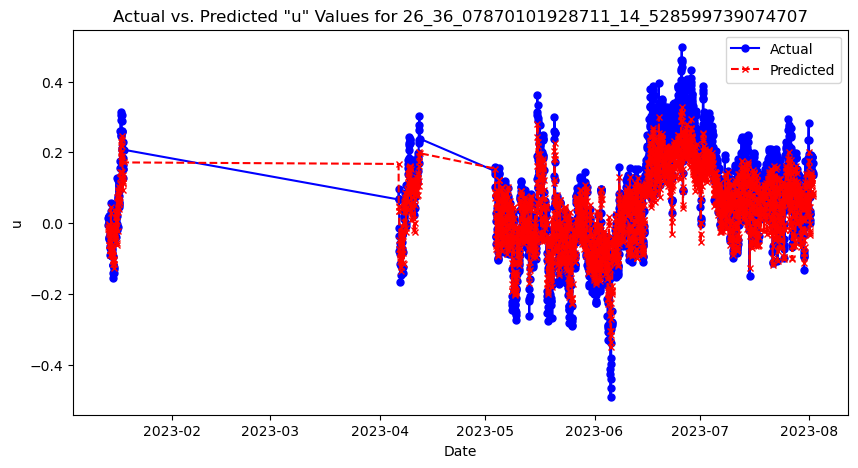

Model tarining & evaluation completed for file: 26_36_07870101928711_14_528599739074707.csv

Processing file: 27_36_07870101928711_14_569199562072754.csv

Epoch 1/100
171/171 [==============================] - ETA: 0s - loss: 0.0184 - mean_absolute_error: 0.0955INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\27_36_07870101928711_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\27_36_07870101928711_14_569199562072754\assets


171/171 [==============================] - 380s 2s/step - loss: 0.0184 - mean_absolute_error: 0.0955 - val_loss: 0.0105 - val_mean_absolute_error: 0.0784
Epoch 2/100
171/171 [==============================] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0.0748INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\27_36_07870101928711_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\27_36_07870101928711_14_569199562072754\assets


171/171 [==============================] - 384s 2s/step - loss: 0.0125 - mean_absolute_error: 0.0748 - val_loss: 0.0071 - val_mean_absolute_error: 0.0617
Epoch 3/100
171/171 [==============================] - ETA: 0s - loss: 0.0114 - mean_absolute_error: 0.0700INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\27_36_07870101928711_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\27_36_07870101928711_14_569199562072754\assets


171/171 [==============================] - 383s 2s/step - loss: 0.0114 - mean_absolute_error: 0.0700 - val_loss: 0.0067 - val_mean_absolute_error: 0.0595
Epoch 4/100
171/171 [==============================] - ETA: 0s - loss: 0.0116 - mean_absolute_error: 0.0709INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\27_36_07870101928711_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\27_36_07870101928711_14_569199562072754\assets


171/171 [==============================] - 384s 2s/step - loss: 0.0116 - mean_absolute_error: 0.0709 - val_loss: 0.0067 - val_mean_absolute_error: 0.0593
Epoch 5/100
171/171 [==============================] - 378s 2s/step - loss: 0.0114 - mean_absolute_error: 0.0703 - val_loss: 0.0071 - val_mean_absolute_error: 0.0613
Epoch 6/100
171/171 [==============================] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.0711INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\27_36_07870101928711_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\27_36_07870101928711_14_569199562072754\assets


171/171 [==============================] - 384s 2s/step - loss: 0.0117 - mean_absolute_error: 0.0711 - val_loss: 0.0062 - val_mean_absolute_error: 0.0555
Epoch 7/100
171/171 [==============================] - 391s 2s/step - loss: 0.0117 - mean_absolute_error: 0.0708 - val_loss: 0.0064 - val_mean_absolute_error: 0.0567
Epoch 8/100
171/171 [==============================] - 391s 2s/step - loss: 0.0116 - mean_absolute_error: 0.0703 - val_loss: 0.0068 - val_mean_absolute_error: 0.0594
Epoch 9/100
171/171 [==============================] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.0691INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\27_36_07870101928711_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\27_36_07870101928711_14_569199562072754\assets


171/171 [==============================] - 394s 2s/step - loss: 0.0112 - mean_absolute_error: 0.0691 - val_loss: 0.0057 - val_mean_absolute_error: 0.0510
Epoch 10/100
171/171 [==============================] - 406s 2s/step - loss: 0.0113 - mean_absolute_error: 0.0688 - val_loss: 0.0060 - val_mean_absolute_error: 0.0536
Epoch 11/100
171/171 [==============================] - 403s 2s/step - loss: 0.0116 - mean_absolute_error: 0.0702 - val_loss: 0.0057 - val_mean_absolute_error: 0.0518
Epoch 12/100
171/171 [==============================] - 407s 2s/step - loss: 0.0111 - mean_absolute_error: 0.0679 - val_loss: 0.0058 - val_mean_absolute_error: 0.0527
Epoch 13/100
171/171 [==============================] - 404s 2s/step - loss: 0.0114 - mean_absolute_error: 0.0695 - val_loss: 0.0062 - val_mean_absolute_error: 0.0552
Epoch 14/100
171/171 [==============================] - 402s 2s/step - loss: 0.0112 - mean_absolute_error: 0.0687 - val_loss: 0.0060 - val_mean_absolute_error: 0.0540
Epoch 15/10

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\27_36_07870101928711_14_569199562072754\assets


171/171 [==============================] - 413s 2s/step - loss: 0.0112 - mean_absolute_error: 0.0687 - val_loss: 0.0056 - val_mean_absolute_error: 0.0505
Epoch 17/100
171/171 [==============================] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0675INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\27_36_07870101928711_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\27_36_07870101928711_14_569199562072754\assets


171/171 [==============================] - 408s 2s/step - loss: 0.0110 - mean_absolute_error: 0.0675 - val_loss: 0.0054 - val_mean_absolute_error: 0.0492
Epoch 18/100
171/171 [==============================] - 400s 2s/step - loss: 0.0109 - mean_absolute_error: 0.0664 - val_loss: 0.0057 - val_mean_absolute_error: 0.0516
Epoch 19/100
171/171 [==============================] - 399s 2s/step - loss: 0.0112 - mean_absolute_error: 0.0680 - val_loss: 0.0058 - val_mean_absolute_error: 0.0523
Epoch 20/100
171/171 [==============================] - 402s 2s/step - loss: 0.0111 - mean_absolute_error: 0.0682 - val_loss: 0.0054 - val_mean_absolute_error: 0.0490
Epoch 21/100
171/171 [==============================] - 402s 2s/step - loss: 0.0110 - mean_absolute_error: 0.0672 - val_loss: 0.0055 - val_mean_absolute_error: 0.0500
Epoch 22/100
171/171 [==============================] - 400s 2s/step - loss: 0.0108 - mean_absolute_error: 0.0665 - val_loss: 0.0055 - val_mean_absolute_error: 0.0499
Epoch 23/10

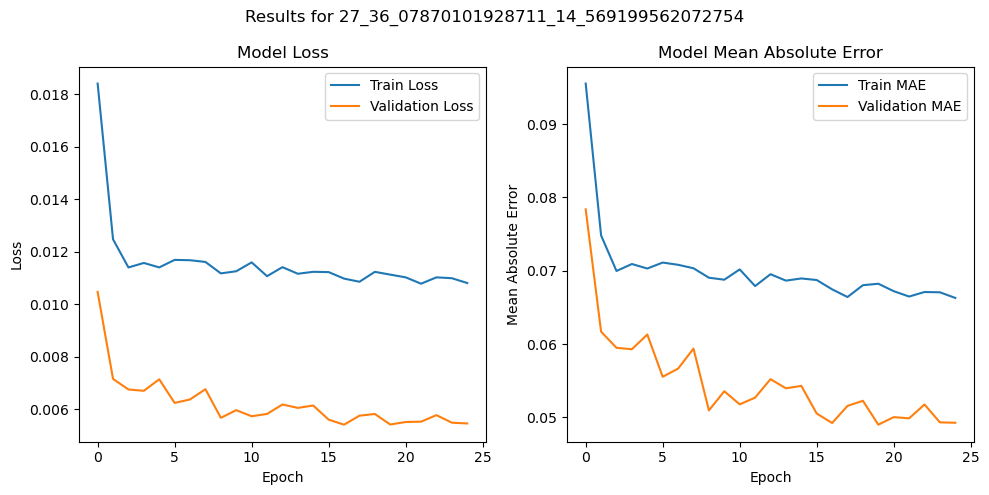

36/36 [==============================] - 16s 439ms/step

Test set Evaluation metrics for file: 27_36_07870101928711_14_569199562072754
Mean Squared Error (MSE): 0.003288965157925702
Mean Absolute Error (MAE): 0.04420801970091861
Root Mean Squared Error (RMSE): 0.05734950006692039



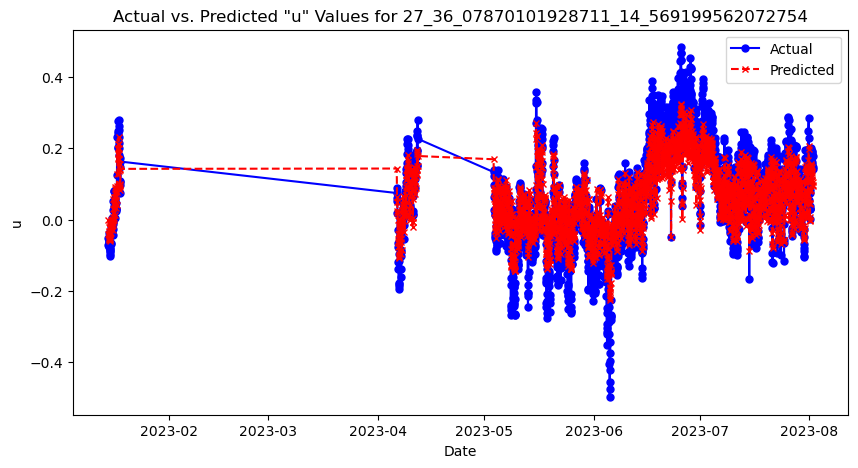

Model tarining & evaluation completed for file: 27_36_07870101928711_14_569199562072754.csv

Processing file: 28_35_945098876953125_14_528599739074707.csv

Epoch 1/100
79/79 [==============================] - ETA: 0s - loss: 0.0123 - mean_absolute_error: 0.0859INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\28_35_945098876953125_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\28_35_945098876953125_14_528599739074707\assets


79/79 [==============================] - 188s 2s/step - loss: 0.0123 - mean_absolute_error: 0.0859 - val_loss: 0.0108 - val_mean_absolute_error: 0.0803
Epoch 2/100
79/79 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0651INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\28_35_945098876953125_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\28_35_945098876953125_14_528599739074707\assets


79/79 [==============================] - 184s 2s/step - loss: 0.0080 - mean_absolute_error: 0.0651 - val_loss: 0.0072 - val_mean_absolute_error: 0.0631
Epoch 3/100
79/79 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0581INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\28_35_945098876953125_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\28_35_945098876953125_14_528599739074707\assets


79/79 [==============================] - 183s 2s/step - loss: 0.0068 - mean_absolute_error: 0.0581 - val_loss: 0.0065 - val_mean_absolute_error: 0.0591
Epoch 4/100
79/79 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0556INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\28_35_945098876953125_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\28_35_945098876953125_14_528599739074707\assets


79/79 [==============================] - 199s 3s/step - loss: 0.0064 - mean_absolute_error: 0.0556 - val_loss: 0.0065 - val_mean_absolute_error: 0.0589
Epoch 5/100
79/79 [==============================] - 185s 2s/step - loss: 0.0062 - mean_absolute_error: 0.0542 - val_loss: 0.0068 - val_mean_absolute_error: 0.0609
Epoch 6/100
79/79 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0545INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\28_35_945098876953125_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\28_35_945098876953125_14_528599739074707\assets


79/79 [==============================] - 179s 2s/step - loss: 0.0062 - mean_absolute_error: 0.0545 - val_loss: 0.0061 - val_mean_absolute_error: 0.0560
Epoch 7/100
79/79 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0531INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\28_35_945098876953125_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\28_35_945098876953125_14_528599739074707\assets


79/79 [==============================] - 179s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0531 - val_loss: 0.0056 - val_mean_absolute_error: 0.0528
Epoch 8/100
79/79 [==============================] - 174s 2s/step - loss: 0.0062 - mean_absolute_error: 0.0539 - val_loss: 0.0057 - val_mean_absolute_error: 0.0539
Epoch 9/100
79/79 [==============================] - 175s 2s/step - loss: 0.0059 - mean_absolute_error: 0.0524 - val_loss: 0.0061 - val_mean_absolute_error: 0.0559
Epoch 10/100
79/79 [==============================] - 183s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0518 - val_loss: 0.0066 - val_mean_absolute_error: 0.0591
Epoch 11/100
79/79 [==============================] - 187s 2s/step - loss: 0.0058 - mean_absolute_error: 0.0522 - val_loss: 0.0063 - val_mean_absolute_error: 0.0578
Epoch 12/100
79/79 [==============================] - 185s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0514 - val_loss: 0.0062 - val_mean_absolute_error: 0.0572
Epoch 13/100
79/79 [=====

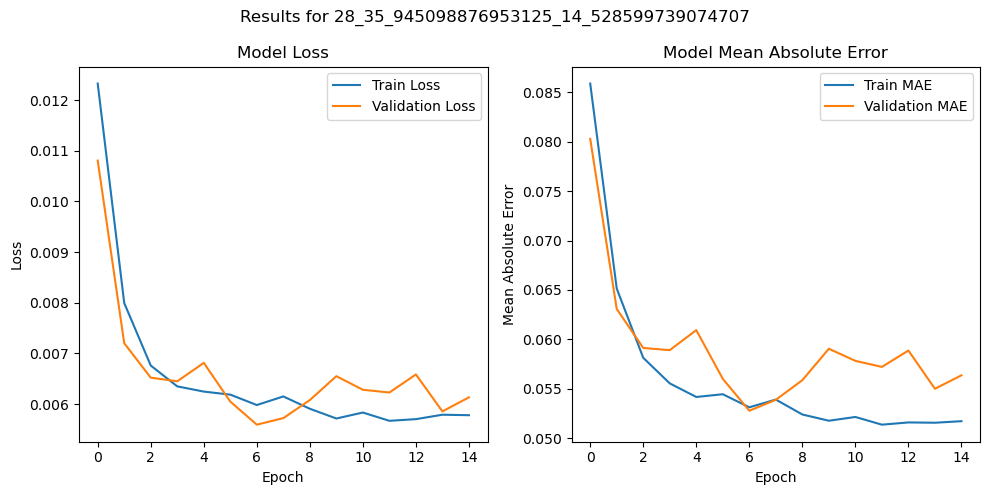

16/16 [==============================] - 8s 474ms/step

Test set Evaluation metrics for file: 28_35_945098876953125_14_528599739074707
Mean Squared Error (MSE): 0.0037843508462572627
Mean Absolute Error (MAE): 0.046717440345679415
Root Mean Squared Error (RMSE): 0.061517077679757046



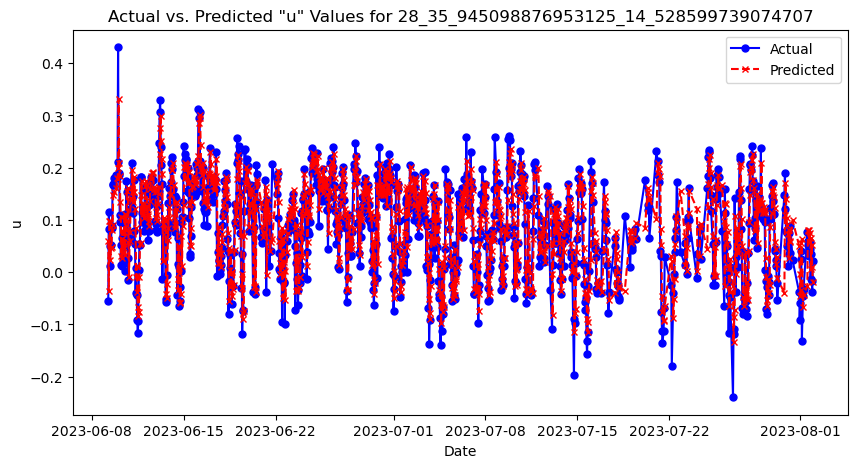

Model tarining & evaluation completed for file: 28_35_945098876953125_14_528599739074707.csv

Processing file: 29_36_03409957885742_14_406900405883789.csv

Epoch 1/100
98/98 [==============================] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0774INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\29_36_03409957885742_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\29_36_03409957885742_14_406900405883789\assets


98/98 [==============================] - 233s 2s/step - loss: 0.0110 - mean_absolute_error: 0.0774 - val_loss: 0.0035 - val_mean_absolute_error: 0.0480
Epoch 2/100
98/98 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0637INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\29_36_03409957885742_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\29_36_03409957885742_14_406900405883789\assets


98/98 [==============================] - 233s 2s/step - loss: 0.0081 - mean_absolute_error: 0.0637 - val_loss: 0.0026 - val_mean_absolute_error: 0.0402
Epoch 3/100
98/98 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0598INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\29_36_03409957885742_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\29_36_03409957885742_14_406900405883789\assets


98/98 [==============================] - 227s 2s/step - loss: 0.0075 - mean_absolute_error: 0.0598 - val_loss: 0.0023 - val_mean_absolute_error: 0.0365
Epoch 4/100
98/98 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0563INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\29_36_03409957885742_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\29_36_03409957885742_14_406900405883789\assets


98/98 [==============================] - 225s 2s/step - loss: 0.0070 - mean_absolute_error: 0.0563 - val_loss: 0.0021 - val_mean_absolute_error: 0.0347
Epoch 5/100
98/98 [==============================] - 234s 2s/step - loss: 0.0067 - mean_absolute_error: 0.0549 - val_loss: 0.0021 - val_mean_absolute_error: 0.0350
Epoch 6/100
98/98 [==============================] - 234s 2s/step - loss: 0.0068 - mean_absolute_error: 0.0552 - val_loss: 0.0021 - val_mean_absolute_error: 0.0345
Epoch 7/100
98/98 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0542INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\29_36_03409957885742_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\29_36_03409957885742_14_406900405883789\assets


98/98 [==============================] - 240s 2s/step - loss: 0.0067 - mean_absolute_error: 0.0542 - val_loss: 0.0020 - val_mean_absolute_error: 0.0338
Epoch 8/100
98/98 [==============================] - 220s 2s/step - loss: 0.0070 - mean_absolute_error: 0.0560 - val_loss: 0.0029 - val_mean_absolute_error: 0.0410
Epoch 9/100
98/98 [==============================] - 219s 2s/step - loss: 0.0068 - mean_absolute_error: 0.0555 - val_loss: 0.0022 - val_mean_absolute_error: 0.0350
Epoch 10/100
98/98 [==============================] - 220s 2s/step - loss: 0.0070 - mean_absolute_error: 0.0567 - val_loss: 0.0032 - val_mean_absolute_error: 0.0442
Epoch 11/100
98/98 [==============================] - 220s 2s/step - loss: 0.0068 - mean_absolute_error: 0.0551 - val_loss: 0.0030 - val_mean_absolute_error: 0.0428
Epoch 12/100
98/98 [==============================] - 219s 2s/step - loss: 0.0067 - mean_absolute_error: 0.0543 - val_loss: 0.0030 - val_mean_absolute_error: 0.0414
Epoch 13/100
98/98 [=====

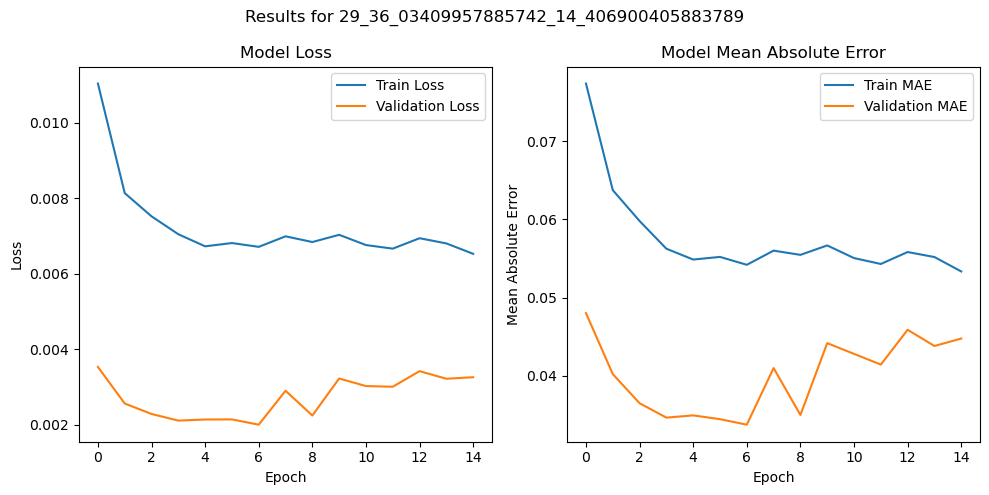

20/20 [==============================] - 10s 459ms/step

Test set Evaluation metrics for file: 29_36_03409957885742_14_406900405883789
Mean Squared Error (MSE): 0.00333150448577378
Mean Absolute Error (MAE): 0.04470096519212966
Root Mean Squared Error (RMSE): 0.0577191864614686



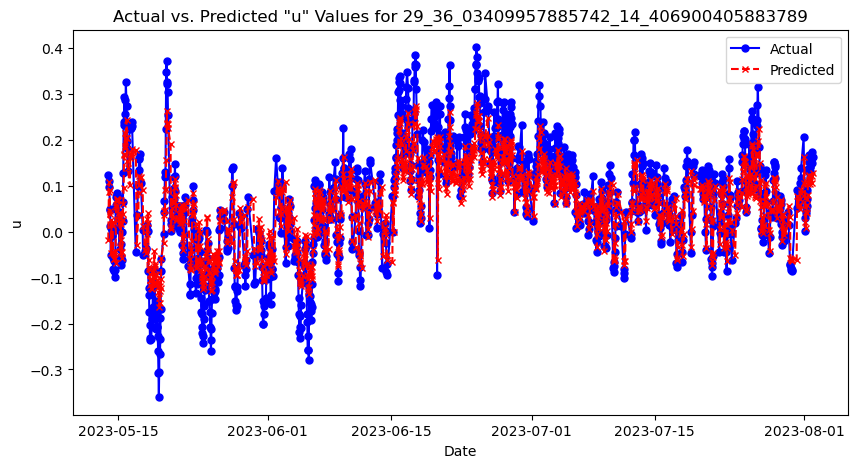

Model tarining & evaluation completed for file: 29_36_03409957885742_14_406900405883789.csv

Processing file: 30_36_056400299072266_14_406900405883789.csv

Epoch 1/100
102/102 [==============================] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.0865INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\30_36_056400299072266_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\30_36_056400299072266_14_406900405883789\assets


102/102 [==============================] - 231s 2s/step - loss: 0.0135 - mean_absolute_error: 0.0865 - val_loss: 0.0044 - val_mean_absolute_error: 0.0531
Epoch 2/100
102/102 [==============================] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.0711INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\30_36_056400299072266_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\30_36_056400299072266_14_406900405883789\assets


102/102 [==============================] - 233s 2s/step - loss: 0.0099 - mean_absolute_error: 0.0711 - val_loss: 0.0035 - val_mean_absolute_error: 0.0482
Epoch 3/100
102/102 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0610INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\30_36_056400299072266_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\30_36_056400299072266_14_406900405883789\assets


102/102 [==============================] - 227s 2s/step - loss: 0.0079 - mean_absolute_error: 0.0610 - val_loss: 0.0031 - val_mean_absolute_error: 0.0433
Epoch 4/100
102/102 [==============================] - 232s 2s/step - loss: 0.0075 - mean_absolute_error: 0.0592 - val_loss: 0.0032 - val_mean_absolute_error: 0.0436
Epoch 5/100
102/102 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0571INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\30_36_056400299072266_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\30_36_056400299072266_14_406900405883789\assets


102/102 [==============================] - 238s 2s/step - loss: 0.0073 - mean_absolute_error: 0.0571 - val_loss: 0.0027 - val_mean_absolute_error: 0.0403
Epoch 6/100
102/102 [==============================] - 240s 2s/step - loss: 0.0073 - mean_absolute_error: 0.0576 - val_loss: 0.0035 - val_mean_absolute_error: 0.0457
Epoch 7/100
102/102 [==============================] - 239s 2s/step - loss: 0.0074 - mean_absolute_error: 0.0586 - val_loss: 0.0035 - val_mean_absolute_error: 0.0456
Epoch 8/100
102/102 [==============================] - 239s 2s/step - loss: 0.0072 - mean_absolute_error: 0.0572 - val_loss: 0.0033 - val_mean_absolute_error: 0.0440
Epoch 9/100
102/102 [==============================] - 242s 2s/step - loss: 0.0073 - mean_absolute_error: 0.0573 - val_loss: 0.0033 - val_mean_absolute_error: 0.0432
Epoch 10/100
102/102 [==============================] - 239s 2s/step - loss: 0.0071 - mean_absolute_error: 0.0567 - val_loss: 0.0033 - val_mean_absolute_error: 0.0435
Epoch 11/100
10

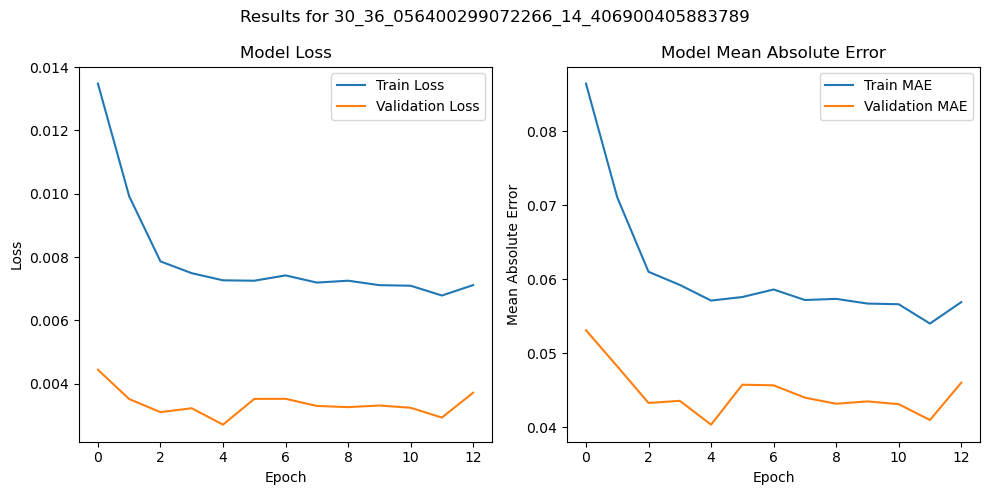

21/21 [==============================] - 11s 480ms/step

Test set Evaluation metrics for file: 30_36_056400299072266_14_406900405883789
Mean Squared Error (MSE): 0.004892961941623185
Mean Absolute Error (MAE): 0.055486033615588404
Root Mean Squared Error (RMSE): 0.06994971008962929



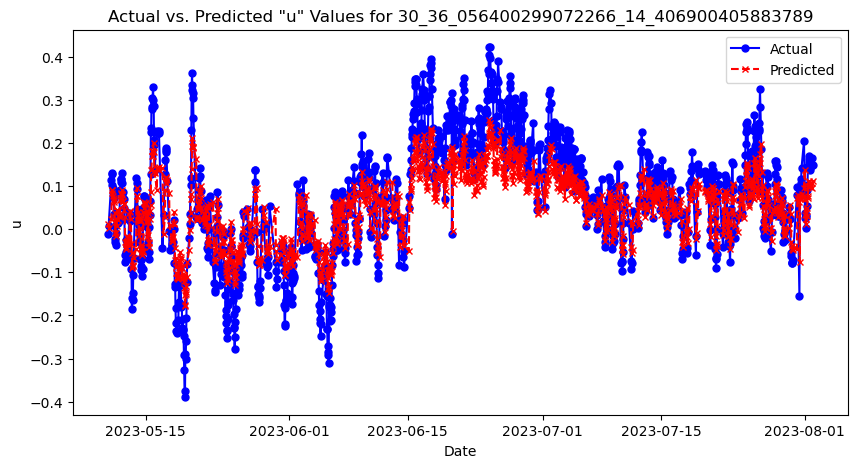

Model tarining & evaluation completed for file: 30_36_056400299072266_14_406900405883789.csv

Processing file: 31_36_01190185546875_14_406900405883789.csv

Epoch 1/100
66/66 [==============================] - ETA: 0s - loss: 0.0120 - mean_absolute_error: 0.0826INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\31_36_01190185546875_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\31_36_01190185546875_14_406900405883789\assets


66/66 [==============================] - 165s 2s/step - loss: 0.0120 - mean_absolute_error: 0.0826 - val_loss: 0.0092 - val_mean_absolute_error: 0.0762
Epoch 2/100
66/66 [==============================] - 157s 2s/step - loss: 0.0137 - mean_absolute_error: 0.0894 - val_loss: 0.0111 - val_mean_absolute_error: 0.0856
Epoch 3/100
66/66 [==============================] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0764INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\31_36_01190185546875_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\31_36_01190185546875_14_406900405883789\assets


66/66 [==============================] - 163s 2s/step - loss: 0.0107 - mean_absolute_error: 0.0764 - val_loss: 0.0063 - val_mean_absolute_error: 0.0631
Epoch 4/100
66/66 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0708INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\31_36_01190185546875_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\31_36_01190185546875_14_406900405883789\assets


66/66 [==============================] - 166s 3s/step - loss: 0.0095 - mean_absolute_error: 0.0708 - val_loss: 0.0057 - val_mean_absolute_error: 0.0617
Epoch 5/100
66/66 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0650INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\31_36_01190185546875_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\31_36_01190185546875_14_406900405883789\assets


66/66 [==============================] - 159s 2s/step - loss: 0.0083 - mean_absolute_error: 0.0650 - val_loss: 0.0050 - val_mean_absolute_error: 0.0568
Epoch 6/100
66/66 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0600INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\31_36_01190185546875_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\31_36_01190185546875_14_406900405883789\assets


66/66 [==============================] - 165s 3s/step - loss: 0.0075 - mean_absolute_error: 0.0600 - val_loss: 0.0044 - val_mean_absolute_error: 0.0524
Epoch 7/100
66/66 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0576INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\31_36_01190185546875_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\31_36_01190185546875_14_406900405883789\assets


66/66 [==============================] - 165s 3s/step - loss: 0.0070 - mean_absolute_error: 0.0576 - val_loss: 0.0041 - val_mean_absolute_error: 0.0500
Epoch 8/100
66/66 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0577INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\31_36_01190185546875_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\31_36_01190185546875_14_406900405883789\assets


66/66 [==============================] - 164s 2s/step - loss: 0.0070 - mean_absolute_error: 0.0577 - val_loss: 0.0039 - val_mean_absolute_error: 0.0486
Epoch 9/100
66/66 [==============================] - 162s 2s/step - loss: 0.0070 - mean_absolute_error: 0.0577 - val_loss: 0.0043 - val_mean_absolute_error: 0.0514
Epoch 10/100
66/66 [==============================] - 160s 2s/step - loss: 0.0070 - mean_absolute_error: 0.0585 - val_loss: 0.0045 - val_mean_absolute_error: 0.0539
Epoch 11/100
66/66 [==============================] - 160s 2s/step - loss: 0.0070 - mean_absolute_error: 0.0571 - val_loss: 0.0040 - val_mean_absolute_error: 0.0493
Epoch 12/100
66/66 [==============================] - 160s 2s/step - loss: 0.0069 - mean_absolute_error: 0.0564 - val_loss: 0.0043 - val_mean_absolute_error: 0.0514
Epoch 13/100
66/66 [==============================] - 162s 2s/step - loss: 0.0071 - mean_absolute_error: 0.0577 - val_loss: 0.0043 - val_mean_absolute_error: 0.0510
Epoch 14/100
66/66 [====

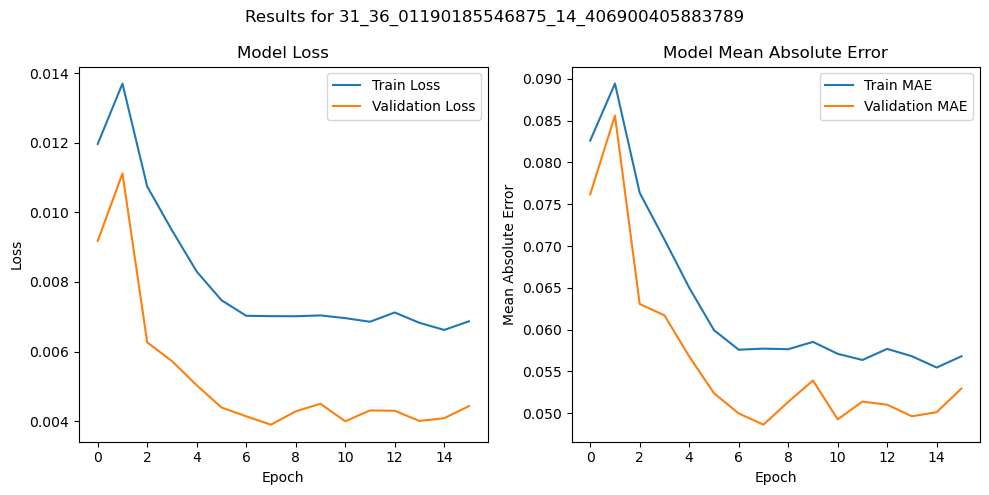

14/14 [==============================] - 7s 473ms/step

Test set Evaluation metrics for file: 31_36_01190185546875_14_406900405883789
Mean Squared Error (MSE): 0.004237874040077238
Mean Absolute Error (MAE): 0.051139281285088885
Root Mean Squared Error (RMSE): 0.06509895575258667



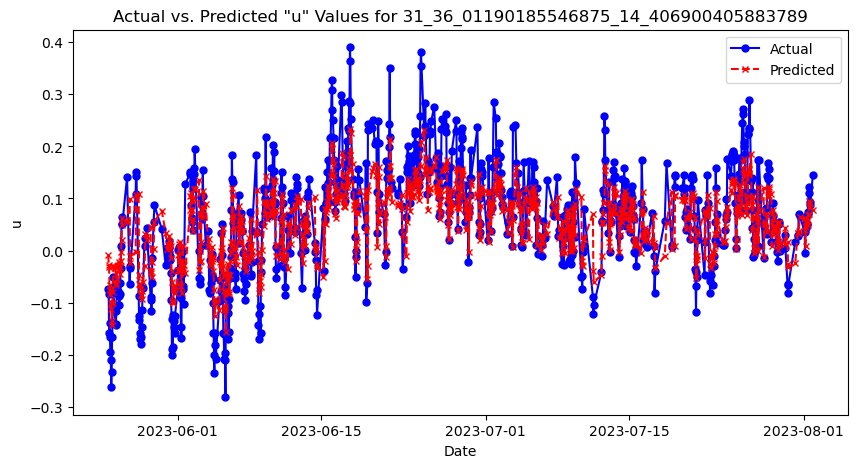

Model tarining & evaluation completed for file: 31_36_01190185546875_14_406900405883789.csv

Processing file: 32_36_03409957885742_14_366399765014648.csv

Epoch 1/100
67/67 [==============================] - ETA: 0s - loss: 0.0120 - mean_absolute_error: 0.0832INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\32_36_03409957885742_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\32_36_03409957885742_14_366399765014648\assets


67/67 [==============================] - 178s 3s/step - loss: 0.0120 - mean_absolute_error: 0.0832 - val_loss: 0.0093 - val_mean_absolute_error: 0.0788
Epoch 2/100
67/67 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0754INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\32_36_03409957885742_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\32_36_03409957885742_14_366399765014648\assets


67/67 [==============================] - 170s 3s/step - loss: 0.0104 - mean_absolute_error: 0.0754 - val_loss: 0.0065 - val_mean_absolute_error: 0.0650
Epoch 3/100
67/67 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0657INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\32_36_03409957885742_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\32_36_03409957885742_14_366399765014648\assets


67/67 [==============================] - 187s 3s/step - loss: 0.0085 - mean_absolute_error: 0.0657 - val_loss: 0.0038 - val_mean_absolute_error: 0.0460
Epoch 4/100
67/67 [==============================] - 181s 3s/step - loss: 0.0072 - mean_absolute_error: 0.0591 - val_loss: 0.0044 - val_mean_absolute_error: 0.0506
Epoch 5/100
67/67 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0575INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\32_36_03409957885742_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\32_36_03409957885742_14_366399765014648\assets


67/67 [==============================] - 168s 3s/step - loss: 0.0068 - mean_absolute_error: 0.0575 - val_loss: 0.0037 - val_mean_absolute_error: 0.0465
Epoch 6/100
67/67 [==============================] - 163s 2s/step - loss: 0.0070 - mean_absolute_error: 0.0572 - val_loss: 0.0040 - val_mean_absolute_error: 0.0480
Epoch 7/100
67/67 [==============================] - 163s 2s/step - loss: 0.0068 - mean_absolute_error: 0.0570 - val_loss: 0.0040 - val_mean_absolute_error: 0.0493
Epoch 8/100
67/67 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0566INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\32_36_03409957885742_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\32_36_03409957885742_14_366399765014648\assets


67/67 [==============================] - 168s 3s/step - loss: 0.0066 - mean_absolute_error: 0.0566 - val_loss: 0.0034 - val_mean_absolute_error: 0.0437
Epoch 9/100
67/67 [==============================] - 163s 2s/step - loss: 0.0068 - mean_absolute_error: 0.0570 - val_loss: 0.0047 - val_mean_absolute_error: 0.0549
Epoch 10/100
67/67 [==============================] - 163s 2s/step - loss: 0.0067 - mean_absolute_error: 0.0564 - val_loss: 0.0044 - val_mean_absolute_error: 0.0523
Epoch 11/100
67/67 [==============================] - 163s 2s/step - loss: 0.0066 - mean_absolute_error: 0.0557 - val_loss: 0.0045 - val_mean_absolute_error: 0.0527
Epoch 12/100
67/67 [==============================] - 163s 2s/step - loss: 0.0065 - mean_absolute_error: 0.0552 - val_loss: 0.0042 - val_mean_absolute_error: 0.0506
Epoch 13/100
67/67 [==============================] - 163s 2s/step - loss: 0.0066 - mean_absolute_error: 0.0557 - val_loss: 0.0042 - val_mean_absolute_error: 0.0509
Epoch 14/100
67/67 [====

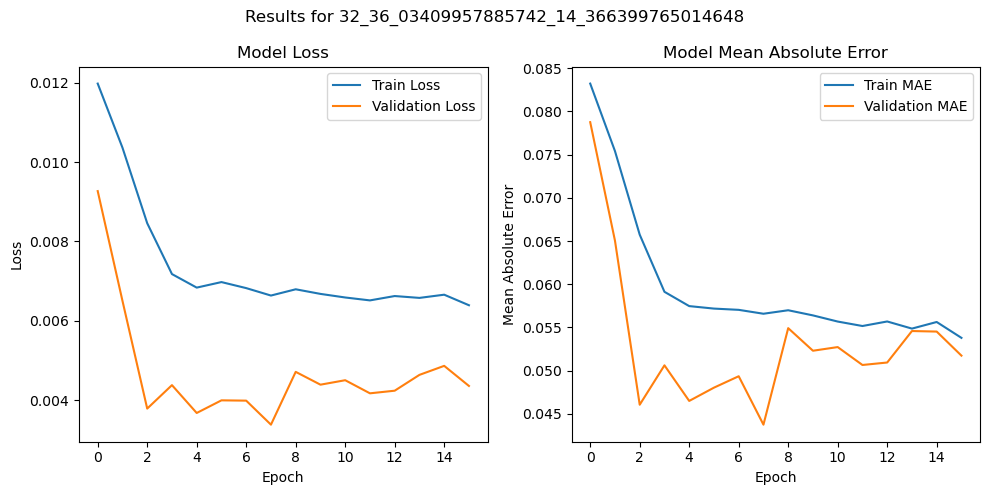

14/14 [==============================] - 7s 477ms/step

Test set Evaluation metrics for file: 32_36_03409957885742_14_366399765014648
Mean Squared Error (MSE): 0.002616120331026331
Mean Absolute Error (MAE): 0.039908008513127625
Root Mean Squared Error (RMSE): 0.05114802372551975



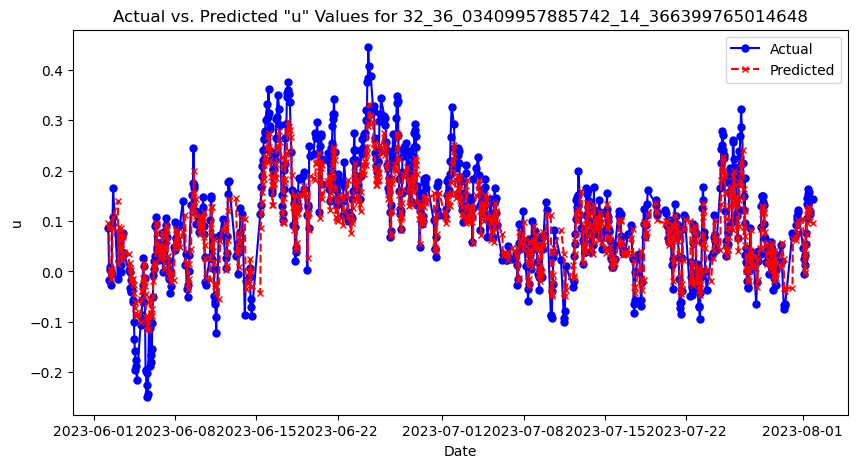

Model tarining & evaluation completed for file: 32_36_03409957885742_14_366399765014648.csv

Processing file: 33_36_056400299072266_14_366399765014648.csv

Epoch 1/100
69/69 [==============================] - ETA: 0s - loss: 0.0122 - mean_absolute_error: 0.0854INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\33_36_056400299072266_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\33_36_056400299072266_14_366399765014648\assets


69/69 [==============================] - 175s 2s/step - loss: 0.0122 - mean_absolute_error: 0.0854 - val_loss: 0.0126 - val_mean_absolute_error: 0.0929
Epoch 2/100
69/69 [==============================] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0745INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\33_36_056400299072266_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\33_36_056400299072266_14_366399765014648\assets


69/69 [==============================] - 169s 2s/step - loss: 0.0101 - mean_absolute_error: 0.0745 - val_loss: 0.0064 - val_mean_absolute_error: 0.0640
Epoch 3/100
69/69 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0643INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\33_36_056400299072266_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\33_36_056400299072266_14_366399765014648\assets


69/69 [==============================] - 170s 2s/step - loss: 0.0080 - mean_absolute_error: 0.0643 - val_loss: 0.0043 - val_mean_absolute_error: 0.0500
Epoch 4/100
69/69 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0586INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\33_36_056400299072266_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\33_36_056400299072266_14_366399765014648\assets


69/69 [==============================] - 170s 2s/step - loss: 0.0069 - mean_absolute_error: 0.0586 - val_loss: 0.0034 - val_mean_absolute_error: 0.0444
Epoch 5/100
69/69 [==============================] - 165s 2s/step - loss: 0.0061 - mean_absolute_error: 0.0534 - val_loss: 0.0040 - val_mean_absolute_error: 0.0481
Epoch 6/100
69/69 [==============================] - 165s 2s/step - loss: 0.0062 - mean_absolute_error: 0.0540 - val_loss: 0.0034 - val_mean_absolute_error: 0.0440
Epoch 7/100
69/69 [==============================] - 165s 2s/step - loss: 0.0063 - mean_absolute_error: 0.0548 - val_loss: 0.0035 - val_mean_absolute_error: 0.0457
Epoch 8/100
69/69 [==============================] - 165s 2s/step - loss: 0.0063 - mean_absolute_error: 0.0549 - val_loss: 0.0038 - val_mean_absolute_error: 0.0473
Epoch 9/100
69/69 [==============================] - 165s 2s/step - loss: 0.0062 - mean_absolute_error: 0.0541 - val_loss: 0.0043 - val_mean_absolute_error: 0.0510
Epoch 10/100
69/69 [========

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\33_36_056400299072266_14_366399765014648\assets


69/69 [==============================] - 179s 3s/step - loss: 0.0059 - mean_absolute_error: 0.0524 - val_loss: 0.0032 - val_mean_absolute_error: 0.0425
Epoch 11/100
69/69 [==============================] - 165s 2s/step - loss: 0.0061 - mean_absolute_error: 0.0537 - val_loss: 0.0039 - val_mean_absolute_error: 0.0477
Epoch 12/100
69/69 [==============================] - 165s 2s/step - loss: 0.0061 - mean_absolute_error: 0.0542 - val_loss: 0.0036 - val_mean_absolute_error: 0.0453
Epoch 13/100
69/69 [==============================] - 164s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0521 - val_loss: 0.0037 - val_mean_absolute_error: 0.0465
Epoch 14/100
69/69 [==============================] - 166s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0513 - val_loss: 0.0037 - val_mean_absolute_error: 0.0471
Epoch 15/100
69/69 [==============================] - 165s 2s/step - loss: 0.0058 - mean_absolute_error: 0.0524 - val_loss: 0.0035 - val_mean_absolute_error: 0.0451
Epoch 16/100
69/69 [===

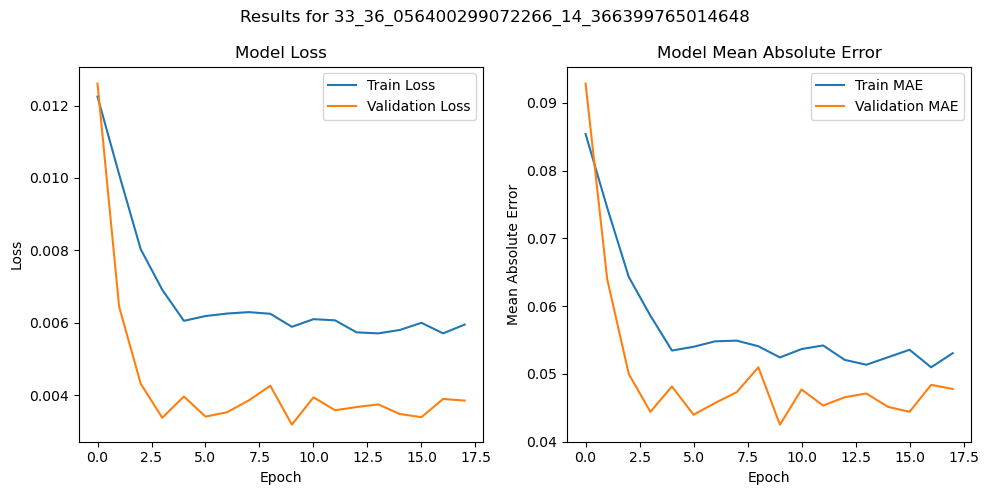

14/14 [==============================] - 7s 463ms/step

Test set Evaluation metrics for file: 33_36_056400299072266_14_366399765014648
Mean Squared Error (MSE): 0.0024935492209487756
Mean Absolute Error (MAE): 0.03912460719472565
Root Mean Squared Error (RMSE): 0.04993545054316398



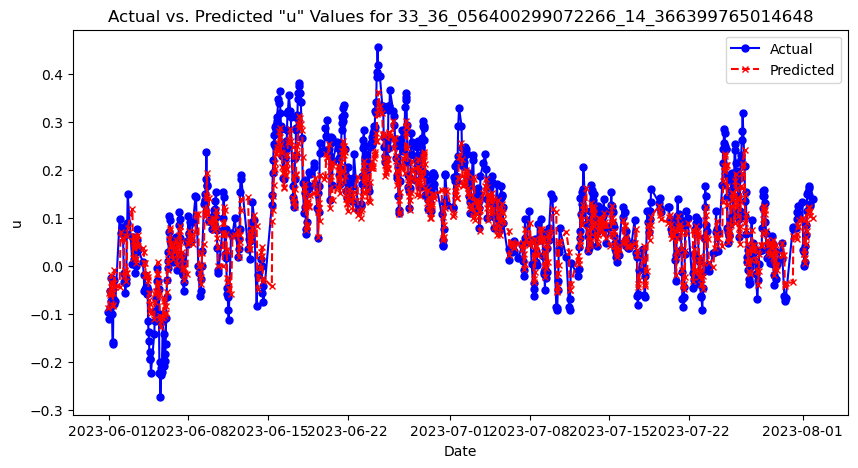

Model tarining & evaluation completed for file: 33_36_056400299072266_14_366399765014648.csv

Processing file: 34_35_96730041503906_14_48799991607666.csv

Epoch 1/100
56/56 [==============================] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0788INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\34_35_96730041503906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\34_35_96730041503906_14_48799991607666\assets


56/56 [==============================] - 147s 3s/step - loss: 0.0106 - mean_absolute_error: 0.0788 - val_loss: 0.0104 - val_mean_absolute_error: 0.0805
Epoch 2/100
56/56 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0680INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\34_35_96730041503906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\34_35_96730041503906_14_48799991607666\assets


56/56 [==============================] - 144s 3s/step - loss: 0.0084 - mean_absolute_error: 0.0680 - val_loss: 0.0077 - val_mean_absolute_error: 0.0688
Epoch 3/100
56/56 [==============================] - 134s 2s/step - loss: 0.0062 - mean_absolute_error: 0.0564 - val_loss: 0.0083 - val_mean_absolute_error: 0.0700
Epoch 4/100
56/56 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0511INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\34_35_96730041503906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\34_35_96730041503906_14_48799991607666\assets


56/56 [==============================] - 140s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0511 - val_loss: 0.0067 - val_mean_absolute_error: 0.0626
Epoch 5/100
56/56 [==============================] - 135s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0494 - val_loss: 0.0069 - val_mean_absolute_error: 0.0630
Epoch 6/100
56/56 [==============================] - 134s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0484 - val_loss: 0.0068 - val_mean_absolute_error: 0.0621
Epoch 7/100
56/56 [==============================] - 133s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0481 - val_loss: 0.0073 - val_mean_absolute_error: 0.0650
Epoch 8/100
56/56 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.0467INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\34_35_96730041503906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\34_35_96730041503906_14_48799991607666\assets


56/56 [==============================] - 139s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0467 - val_loss: 0.0066 - val_mean_absolute_error: 0.0612
Epoch 9/100
56/56 [==============================] - 133s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0504 - val_loss: 0.0075 - val_mean_absolute_error: 0.0658
Epoch 10/100
56/56 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0485INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\34_35_96730041503906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\34_35_96730041503906_14_48799991607666\assets


56/56 [==============================] - 139s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0485 - val_loss: 0.0061 - val_mean_absolute_error: 0.0590
Epoch 11/100
56/56 [==============================] - 133s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0477 - val_loss: 0.0074 - val_mean_absolute_error: 0.0649
Epoch 12/100
56/56 [==============================] - 133s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0472 - val_loss: 0.0064 - val_mean_absolute_error: 0.0601
Epoch 13/100
56/56 [==============================] - 134s 2s/step - loss: 0.0043 - mean_absolute_error: 0.0456 - val_loss: 0.0067 - val_mean_absolute_error: 0.0617
Epoch 14/100
56/56 [==============================] - 133s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0478 - val_loss: 0.0067 - val_mean_absolute_error: 0.0616
Epoch 15/100
56/56 [==============================] - 135s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0471 - val_loss: 0.0066 - val_mean_absolute_error: 0.0611
Epoch 16/100
56/56 [===

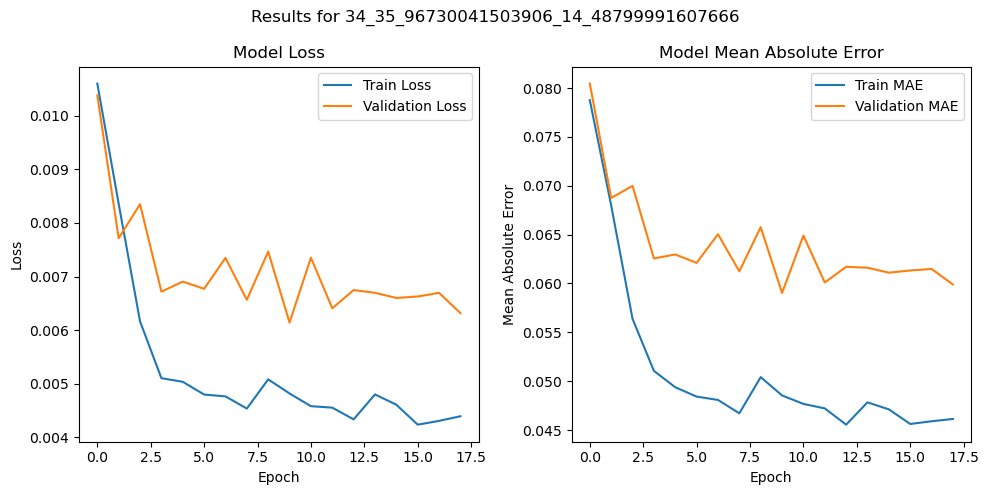

12/12 [==============================] - 6s 453ms/step

Test set Evaluation metrics for file: 34_35_96730041503906_14_48799991607666
Mean Squared Error (MSE): 0.005481850887837848
Mean Absolute Error (MAE): 0.05599445032026323
Root Mean Squared Error (RMSE): 0.07403952247170323



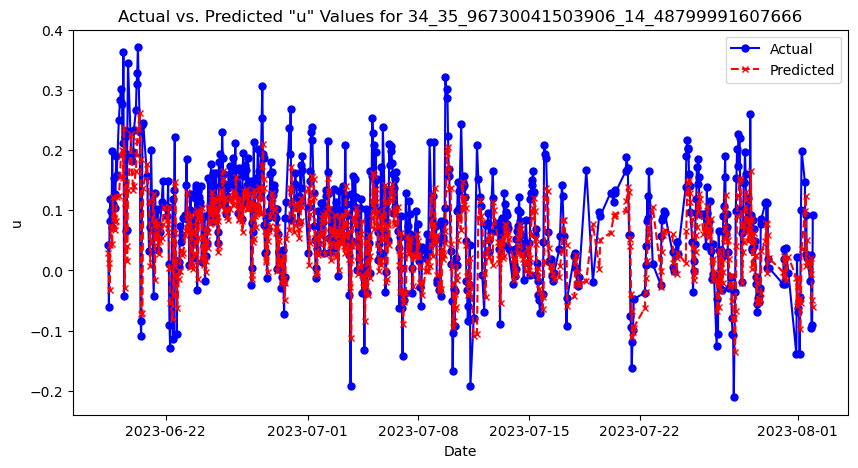

Model tarining & evaluation completed for file: 34_35_96730041503906_14_48799991607666.csv

Processing file: 35_35_989601135253906_14_406900405883789.csv

Epoch 1/100
27/27 [==============================] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.0875INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\35_35_989601135253906_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\35_35_989601135253906_14_406900405883789\assets


27/27 [==============================] - 72s 3s/step - loss: 0.0124 - mean_absolute_error: 0.0875 - val_loss: 0.0135 - val_mean_absolute_error: 0.0929
Epoch 2/100
27/27 [==============================] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0832INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\35_35_989601135253906_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\35_35_989601135253906_14_406900405883789\assets


27/27 [==============================] - 66s 2s/step - loss: 0.0110 - mean_absolute_error: 0.0832 - val_loss: 0.0134 - val_mean_absolute_error: 0.0930
Epoch 3/100
27/27 [==============================] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0781INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\35_35_989601135253906_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\35_35_989601135253906_14_406900405883789\assets


27/27 [==============================] - 69s 3s/step - loss: 0.0101 - mean_absolute_error: 0.0781 - val_loss: 0.0125 - val_mean_absolute_error: 0.0883
Epoch 4/100
27/27 [==============================] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.0771INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\35_35_989601135253906_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\35_35_989601135253906_14_406900405883789\assets


27/27 [==============================] - 69s 3s/step - loss: 0.0099 - mean_absolute_error: 0.0771 - val_loss: 0.0119 - val_mean_absolute_error: 0.0853
Epoch 5/100
27/27 [==============================] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0758INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\35_35_989601135253906_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\35_35_989601135253906_14_406900405883789\assets


27/27 [==============================] - 69s 3s/step - loss: 0.0094 - mean_absolute_error: 0.0758 - val_loss: 0.0107 - val_mean_absolute_error: 0.0801
Epoch 6/100
27/27 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0718INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\35_35_989601135253906_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\35_35_989601135253906_14_406900405883789\assets


27/27 [==============================] - 69s 3s/step - loss: 0.0088 - mean_absolute_error: 0.0718 - val_loss: 0.0104 - val_mean_absolute_error: 0.0781
Epoch 7/100
27/27 [==============================] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0709INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\35_35_989601135253906_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\35_35_989601135253906_14_406900405883789\assets


27/27 [==============================] - 68s 3s/step - loss: 0.0086 - mean_absolute_error: 0.0709 - val_loss: 0.0099 - val_mean_absolute_error: 0.0751
Epoch 8/100
27/27 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0664INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\35_35_989601135253906_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\35_35_989601135253906_14_406900405883789\assets


27/27 [==============================] - 69s 3s/step - loss: 0.0077 - mean_absolute_error: 0.0664 - val_loss: 0.0099 - val_mean_absolute_error: 0.0739
Epoch 9/100
27/27 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0683INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\35_35_989601135253906_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\35_35_989601135253906_14_406900405883789\assets


27/27 [==============================] - 69s 3s/step - loss: 0.0081 - mean_absolute_error: 0.0683 - val_loss: 0.0098 - val_mean_absolute_error: 0.0738
Epoch 10/100
27/27 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0668INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\35_35_989601135253906_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\35_35_989601135253906_14_406900405883789\assets


27/27 [==============================] - 67s 3s/step - loss: 0.0079 - mean_absolute_error: 0.0668 - val_loss: 0.0097 - val_mean_absolute_error: 0.0731
Epoch 11/100
27/27 [==============================] - 62s 2s/step - loss: 0.0076 - mean_absolute_error: 0.0655 - val_loss: 0.0101 - val_mean_absolute_error: 0.0750
Epoch 12/100
27/27 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0654INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\35_35_989601135253906_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\35_35_989601135253906_14_406900405883789\assets


27/27 [==============================] - 67s 2s/step - loss: 0.0076 - mean_absolute_error: 0.0654 - val_loss: 0.0097 - val_mean_absolute_error: 0.0730
Epoch 13/100
27/27 [==============================] - 62s 2s/step - loss: 0.0077 - mean_absolute_error: 0.0660 - val_loss: 0.0098 - val_mean_absolute_error: 0.0737
Epoch 14/100
27/27 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0659INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\35_35_989601135253906_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\35_35_989601135253906_14_406900405883789\assets


27/27 [==============================] - 67s 2s/step - loss: 0.0078 - mean_absolute_error: 0.0659 - val_loss: 0.0096 - val_mean_absolute_error: 0.0727
Epoch 15/100
27/27 [==============================] - 63s 2s/step - loss: 0.0077 - mean_absolute_error: 0.0650 - val_loss: 0.0097 - val_mean_absolute_error: 0.0739
Epoch 16/100
27/27 [==============================] - 62s 2s/step - loss: 0.0076 - mean_absolute_error: 0.0644 - val_loss: 0.0096 - val_mean_absolute_error: 0.0730
Epoch 17/100
27/27 [==============================] - 62s 2s/step - loss: 0.0078 - mean_absolute_error: 0.0662 - val_loss: 0.0097 - val_mean_absolute_error: 0.0731
Epoch 18/100
27/27 [==============================] - 62s 2s/step - loss: 0.0075 - mean_absolute_error: 0.0650 - val_loss: 0.0097 - val_mean_absolute_error: 0.0729
Epoch 19/100
27/27 [==============================] - 62s 2s/step - loss: 0.0073 - mean_absolute_error: 0.0632 - val_loss: 0.0097 - val_mean_absolute_error: 0.0731
Epoch 20/100
27/27 [=========

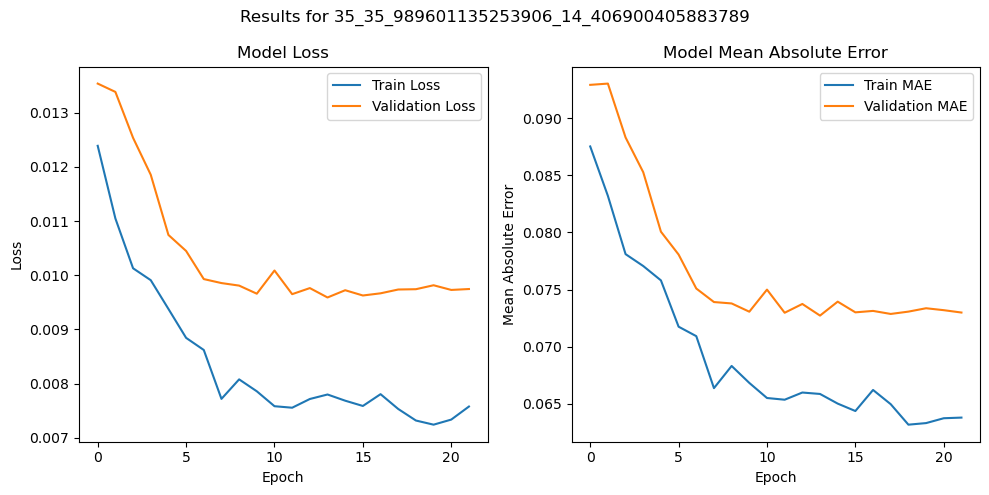

5/5 [==============================] - 3s 442ms/step

Test set Evaluation metrics for file: 35_35_989601135253906_14_406900405883789
Mean Squared Error (MSE): 0.005789658778913888
Mean Absolute Error (MAE): 0.054834457235487306
Root Mean Squared Error (RMSE): 0.07608980732603998



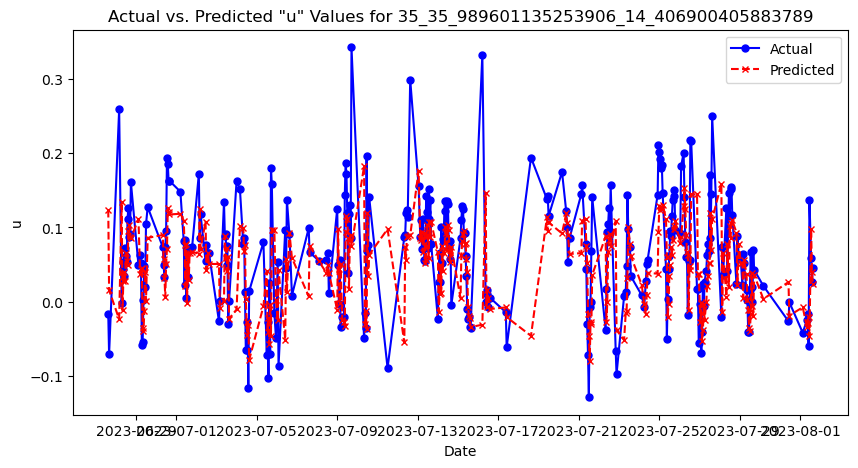

Model tarining & evaluation completed for file: 35_35_989601135253906_14_406900405883789.csv

Processing file: 36_36_01190185546875_14_366399765014648.csv

Epoch 1/100
29/29 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0783INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\36_36_01190185546875_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\36_36_01190185546875_14_366399765014648\assets


29/29 [==============================] - 79s 3s/step - loss: 0.0096 - mean_absolute_error: 0.0783 - val_loss: 0.0093 - val_mean_absolute_error: 0.0782
Epoch 2/100
29/29 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0676INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\36_36_01190185546875_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\36_36_01190185546875_14_366399765014648\assets


29/29 [==============================] - 72s 2s/step - loss: 0.0074 - mean_absolute_error: 0.0676 - val_loss: 0.0076 - val_mean_absolute_error: 0.0712
Epoch 3/100
29/29 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0614INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\36_36_01190185546875_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\36_36_01190185546875_14_366399765014648\assets


29/29 [==============================] - 74s 3s/step - loss: 0.0064 - mean_absolute_error: 0.0614 - val_loss: 0.0061 - val_mean_absolute_error: 0.0635
Epoch 4/100
29/29 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0580INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\36_36_01190185546875_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\36_36_01190185546875_14_366399765014648\assets


29/29 [==============================] - 76s 3s/step - loss: 0.0057 - mean_absolute_error: 0.0580 - val_loss: 0.0056 - val_mean_absolute_error: 0.0603
Epoch 5/100
29/29 [==============================] - 70s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0530 - val_loss: 0.0057 - val_mean_absolute_error: 0.0587
Epoch 6/100
29/29 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.0525INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\36_36_01190185546875_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\36_36_01190185546875_14_366399765014648\assets


29/29 [==============================] - 72s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0525 - val_loss: 0.0046 - val_mean_absolute_error: 0.0521
Epoch 7/100
29/29 [==============================] - 67s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0500 - val_loss: 0.0049 - val_mean_absolute_error: 0.0529
Epoch 8/100
29/29 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0509INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\36_36_01190185546875_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\36_36_01190185546875_14_366399765014648\assets


29/29 [==============================] - 73s 3s/step - loss: 0.0046 - mean_absolute_error: 0.0509 - val_loss: 0.0044 - val_mean_absolute_error: 0.0505
Epoch 9/100
29/29 [==============================] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.0491INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\36_36_01190185546875_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\36_36_01190185546875_14_366399765014648\assets


29/29 [==============================] - 73s 3s/step - loss: 0.0044 - mean_absolute_error: 0.0491 - val_loss: 0.0042 - val_mean_absolute_error: 0.0494
Epoch 10/100
29/29 [==============================] - 67s 2s/step - loss: 0.0044 - mean_absolute_error: 0.0493 - val_loss: 0.0043 - val_mean_absolute_error: 0.0508
Epoch 11/100
29/29 [==============================] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.0496INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\36_36_01190185546875_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\36_36_01190185546875_14_366399765014648\assets


29/29 [==============================] - 72s 3s/step - loss: 0.0044 - mean_absolute_error: 0.0496 - val_loss: 0.0042 - val_mean_absolute_error: 0.0499
Epoch 12/100
29/29 [==============================] - 66s 2s/step - loss: 0.0043 - mean_absolute_error: 0.0480 - val_loss: 0.0043 - val_mean_absolute_error: 0.0514
Epoch 13/100
29/29 [==============================] - 66s 2s/step - loss: 0.0043 - mean_absolute_error: 0.0485 - val_loss: 0.0044 - val_mean_absolute_error: 0.0511
Epoch 14/100
29/29 [==============================] - 67s 2s/step - loss: 0.0044 - mean_absolute_error: 0.0490 - val_loss: 0.0043 - val_mean_absolute_error: 0.0508
Epoch 15/100
29/29 [==============================] - 67s 2s/step - loss: 0.0042 - mean_absolute_error: 0.0478 - val_loss: 0.0044 - val_mean_absolute_error: 0.0512
Epoch 16/100
29/29 [==============================] - 67s 2s/step - loss: 0.0042 - mean_absolute_error: 0.0478 - val_loss: 0.0042 - val_mean_absolute_error: 0.0498
Epoch 17/100
29/29 [=========

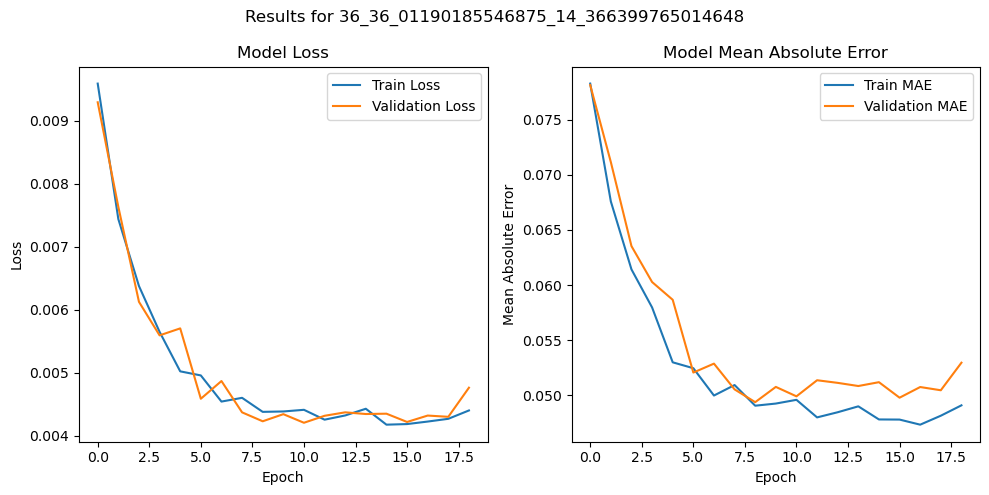

6/6 [==============================] - 3s 413ms/step

Test set Evaluation metrics for file: 36_36_01190185546875_14_366399765014648
Mean Squared Error (MSE): 0.0026816851757215975
Mean Absolute Error (MAE): 0.04042882430093837
Root Mean Squared Error (RMSE): 0.05178498986889538



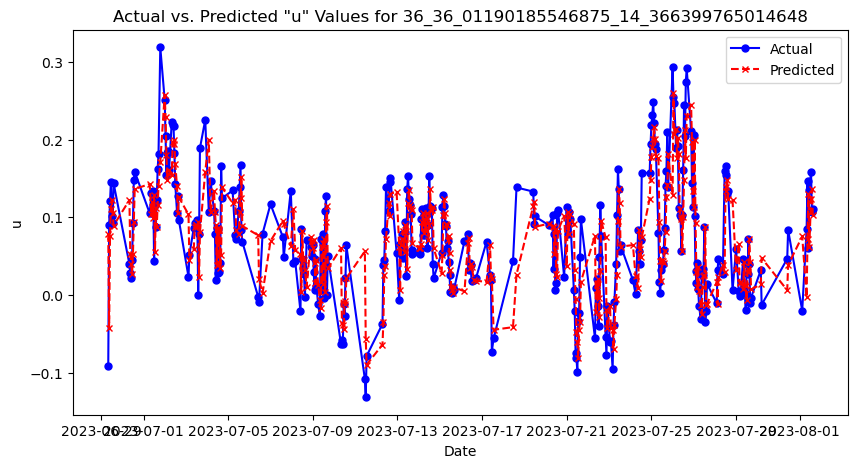

Model tarining & evaluation completed for file: 36_36_01190185546875_14_366399765014648.csv

Processing file: 37_35_96730041503906_14_447500228881836.csv

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.0153 - mean_absolute_error: 0.0991INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\37_35_96730041503906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\37_35_96730041503906_14_447500228881836\assets


21/21 [==============================] - 57s 3s/step - loss: 0.0153 - mean_absolute_error: 0.0991 - val_loss: 0.0153 - val_mean_absolute_error: 0.1003
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.0149 - mean_absolute_error: 0.0962INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\37_35_96730041503906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\37_35_96730041503906_14_447500228881836\assets


21/21 [==============================] - 54s 3s/step - loss: 0.0149 - mean_absolute_error: 0.0962 - val_loss: 0.0139 - val_mean_absolute_error: 0.0946
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.0870INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\37_35_96730041503906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\37_35_96730041503906_14_447500228881836\assets


21/21 [==============================] - 54s 3s/step - loss: 0.0124 - mean_absolute_error: 0.0870 - val_loss: 0.0137 - val_mean_absolute_error: 0.0939
Epoch 4/100
21/21 [==============================] - ETA: 0s - loss: 0.0122 - mean_absolute_error: 0.0859INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\37_35_96730041503906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\37_35_96730041503906_14_447500228881836\assets


21/21 [==============================] - 53s 3s/step - loss: 0.0122 - mean_absolute_error: 0.0859 - val_loss: 0.0133 - val_mean_absolute_error: 0.0922
Epoch 5/100
21/21 [==============================] - ETA: 0s - loss: 0.0114 - mean_absolute_error: 0.0831INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\37_35_96730041503906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\37_35_96730041503906_14_447500228881836\assets


21/21 [==============================] - 55s 3s/step - loss: 0.0114 - mean_absolute_error: 0.0831 - val_loss: 0.0128 - val_mean_absolute_error: 0.0890
Epoch 6/100
21/21 [==============================] - ETA: 0s - loss: 0.0114 - mean_absolute_error: 0.0827INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\37_35_96730041503906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\37_35_96730041503906_14_447500228881836\assets


21/21 [==============================] - 55s 3s/step - loss: 0.0114 - mean_absolute_error: 0.0827 - val_loss: 0.0125 - val_mean_absolute_error: 0.0866
Epoch 7/100
21/21 [==============================] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0782INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\37_35_96730041503906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\37_35_96730041503906_14_447500228881836\assets


21/21 [==============================] - 55s 3s/step - loss: 0.0103 - mean_absolute_error: 0.0782 - val_loss: 0.0113 - val_mean_absolute_error: 0.0820
Epoch 8/100
21/21 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0741INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\37_35_96730041503906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\37_35_96730041503906_14_447500228881836\assets


21/21 [==============================] - 56s 3s/step - loss: 0.0095 - mean_absolute_error: 0.0741 - val_loss: 0.0109 - val_mean_absolute_error: 0.0787
Epoch 9/100
21/21 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0734INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\37_35_96730041503906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\37_35_96730041503906_14_447500228881836\assets


21/21 [==============================] - 56s 3s/step - loss: 0.0095 - mean_absolute_error: 0.0734 - val_loss: 0.0106 - val_mean_absolute_error: 0.0776
Epoch 10/100
21/21 [==============================] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0722INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\37_35_96730041503906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_u\37_35_96730041503906_14_447500228881836\assets


21/21 [==============================] - 55s 3s/step - loss: 0.0091 - mean_absolute_error: 0.0722 - val_loss: 0.0104 - val_mean_absolute_error: 0.0761
Epoch 11/100
21/21 [==============================] - 51s 2s/step - loss: 0.0090 - mean_absolute_error: 0.0717 - val_loss: 0.0106 - val_mean_absolute_error: 0.0768
Epoch 12/100
21/21 [==============================] - 50s 2s/step - loss: 0.0091 - mean_absolute_error: 0.0712 - val_loss: 0.0106 - val_mean_absolute_error: 0.0767
Epoch 13/100
21/21 [==============================] - 50s 2s/step - loss: 0.0092 - mean_absolute_error: 0.0717 - val_loss: 0.0109 - val_mean_absolute_error: 0.0792
Epoch 14/100
21/21 [==============================] - 51s 2s/step - loss: 0.0090 - mean_absolute_error: 0.0703 - val_loss: 0.0109 - val_mean_absolute_error: 0.0792
Epoch 15/100
21/21 [==============================] - 50s 2s/step - loss: 0.0087 - mean_absolute_error: 0.0698 - val_loss: 0.0106 - val_mean_absolute_error: 0.0768
Epoch 16/100
21/21 [=========

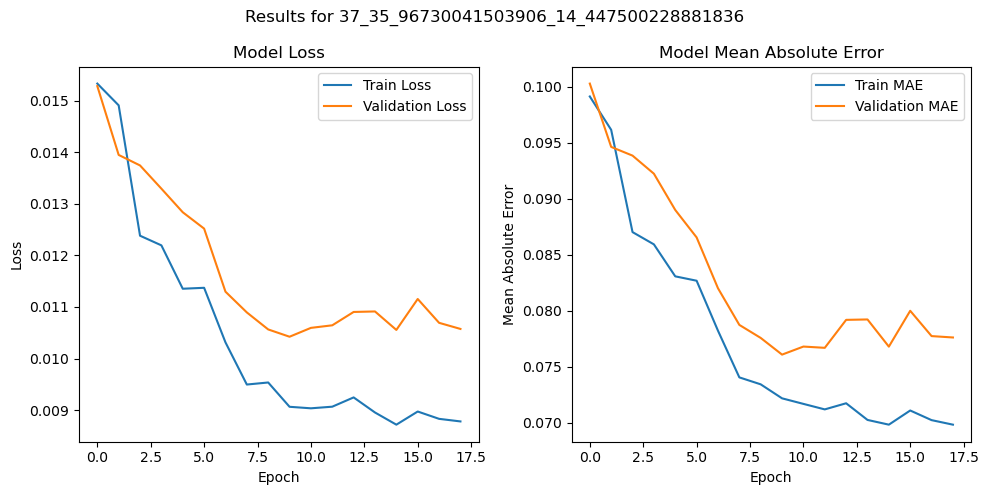

4/4 [==============================] - 3s 427ms/step

Test set Evaluation metrics for file: 37_35_96730041503906_14_447500228881836
Mean Squared Error (MSE): 0.0071810031714496835
Mean Absolute Error (MAE): 0.0586023381147931
Root Mean Squared Error (RMSE): 0.08474079992217258



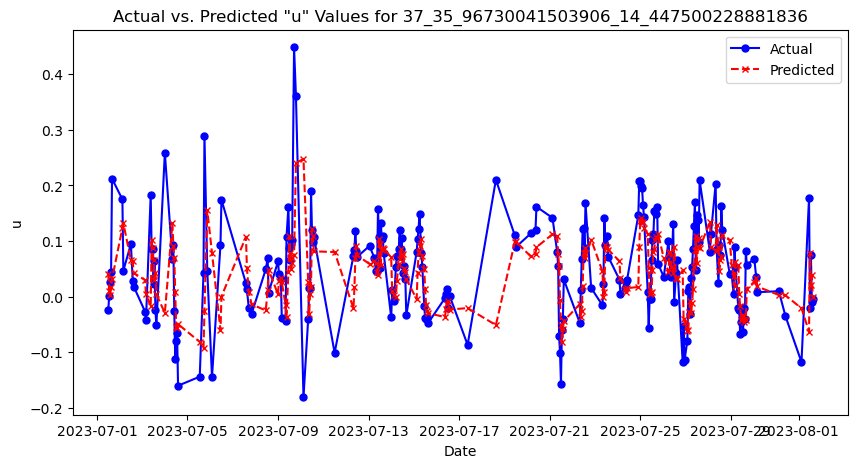

Model tarining & evaluation completed for file: 37_35_96730041503906_14_447500228881836.csv



In [10]:
# Directory for saving models 
model_save_directory = "Data/saved_models/GRU/models_u"
os.makedirs(model_save_directory, exist_ok=True)

# Function to extract the numerical index from the filename
def extract_index(filename):
    # Index is always before the first underscore
    index_part = filename.split("_")[0]
    try:
        return int(index_part)
    except ValueError:
        # In case of any error, return a large number to sort this file at the end
        return float('inf')

# List all CSV files in the directory and sort them numerically based on the index
csv_files = sorted([f for f in os.listdir(save_directory) if f.endswith('.csv')], key=extract_index)

print(csv_files,"\n")
print("="*175)

# Set up early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=8, 
                               mode='min', 
                               restore_best_weights=True)

# Loop through each CSV file in the directory
for file in csv_files:
    print("="*175)
    print(f"Processing file: {file}\n")

    # Load the dataset from the CSV file
    df = pd.read_csv(os.path.join(save_directory, file))

    # Convert the 'time' column to datetime object and set it as the index 
    df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)
    df.set_index('time', inplace=True)

    # Select 'u' and 'v' columns as input features 
    df_input = df[['u', 'v']]
    features = df_input.to_numpy()

    # Set the 'u' column as the target variable 
    target = df_input['u'].values

    # Splitting Data into Train, Validation, and Test sets (70-15-15 split)
    X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.3, random_state=123, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123, shuffle=False)

    # Time series generator parameters
    win_length = 72 # 3 Days
    batch_size = 64 # 64 samples per batch
    num_features = 2 # 'u' and 'v' columns

    # Creating the time series generators for the training, validation, and test sets
    train_generator = TimeseriesGenerator(X_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
    val_generator = TimeseriesGenerator(X_val, y_val, length=win_length, sampling_rate=1, batch_size=batch_size)
    test_generator = TimeseriesGenerator(X_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

    # Building the GRU Model Architecture
    model = Sequential([
        GRU(256, input_shape=(win_length, num_features), return_sequences=True),
        Dropout(0.3),
        GRU(128, return_sequences=True),
        Dropout(0.3),
        GRU(128, return_sequences=True),
        Dropout(0.3),
        GRU(64),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])

    # Compile the model 
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[MeanAbsoluteError()])

    # Define ModelCheckpoint callback to save the best model during training
    model_checkpoint = ModelCheckpoint(filepath=f"{model_save_directory}/{file[:-4]}",
                                       save_best_only=True, 
                                       monitor='val_loss', 
                                       mode='min', 
                                       save_format='tf',
                                       verbose=0)

    # Fit the model to the training data
    history = model.fit(train_generator, epochs=100, validation_data=val_generator, shuffle=False, callbacks=[early_stopping, model_checkpoint])

    # Determine the epoch number at best performance
    best_epoch = early_stopping.stopped_epoch - early_stopping.patience

    # Print the best epoch number and the best validation loss achieved
    print("="*175)
    print(f"Training stopped at epoch: {best_epoch + 1}")
    print(f"Best validation loss achieved at epoch: {best_epoch + 1}\n")

    # Plot training and validation loss values 
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot training and validation mean absolute error values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Train MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.title('Model Mean Absolute Error')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Display the plots 
    plt.suptitle(f'Results for {file[:-4]}')
    plt.tight_layout()
    plt.show()

    # Generate predictions for the test data 
    predictions = model.predict(test_generator)
    test_indexes = df.index[-len(predictions):]

    # Prepare the final DataFrame for plotting and analysis 
    df_final = pd.DataFrame(df.loc[test_indexes])
    df_final['u_pred'] = predictions.flatten()

    # Calculate evaluation metrics  
    mse = mean_squared_error(df_final['u'], df_final['u_pred'])
    mae = mean_absolute_error(df_final['u'], df_final['u_pred'])
    rmse = np.sqrt(mse)

    # Print evaluation metrics
    print(f'\nTest set Evaluation metrics for file: {file[:-4]}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Root Mean Squared Error (RMSE): {rmse}\n')

    # Plot Actual vs. Predicted 'u' Values
    plt.figure(figsize=(10, 5))
    plt.plot(df_final.index, df_final['u'], label='Actual', color='blue', marker='o', linestyle='-', markersize=5)
    plt.plot(df_final.index, df_final['u_pred'], label='Predicted', color='red', marker='x', linestyle='--', markersize=5)
    plt.title(f'Actual vs. Predicted "u" Values for {file[:-4]}')  
    plt.xlabel('Date') 
    plt.ylabel('u')
    plt.legend()
    plt.show()
    
    print("="*175)
    print(f"Model tarining & evaluation completed for file: {file}")
    print("="*175, "\n")

## Making Real-life Predictions from Data (Simulation)
This section outlines the process of making predictions based on real-life data collected over a span of three days. The goal is to use data from the previous three days to simulate a prediction of the sea surface currents for the 4th of August, demonstrating the application in real-world scenarios.

### Extract 3 Days of Inputs for Each Coordinate Pair

- **Data Loading**: Retrieve sea surface current data from August 1, 2023, to August 3, 2023, and load it.
- **Dataframe Conversion**: Transform the loaded NetCDF data into a pandas DataFrame.
- **Data Cleaning**: Remove unnecessary columns.
- **Data Organization**: Set up a directory specifically for storing the processed data files.
- **Data Processing**:
    - For each predefined pair of coordinates, isolate the data corresponding to that location.
    - Ensure the data is in order to maintain the sequence integrity.
    - Apply cubic spline interpolation to fill in any missing 'u' and 'v' values, ensuring a continuous dataset.
- **File Saving**: Format latitude and longitude information for compatibility with filenames and save the individual data frames as seperate CSV files. Each file is uniquely named to correspond with its geographic location.

In [11]:
# Load the dataset (from August 1, 2023 till August 3, 2023) 
input_netcdf_path = "Data/model_IO/3_day_input_SSC_Data.nc"
dataset = xr.open_dataset(input_netcdf_path)

# Convert the dataset to a pandas DataFrame and reset the index
df = dataset.to_dataframe().reset_index()

# Drop columns from the DataFrame that are not needed
df = df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

# Directory to save the files 
input_data_directory = "Data/3_day_input_data_frames"
os.makedirs(input_data_directory, exist_ok=True)

# Loop through each pair of coordinates 
for index, (lon, lat) in enumerate(coordinates_inside, start=1):
    # Extract data for the specific coordinates and copy it
    df_specific = df[(df['lat'] == lat) & (df['lon'] == lon)].copy()

    # Ensure the DataFrame is sorted by time 
    df_specific.sort_values('time', inplace=True)

    # Interpolate NaN values using cubic spline interpolation
    df_specific.loc[:, ['u', 'v']] = df_specific[['u', 'v']].interpolate(method='spline', order=3)

    # After interpolation, if there are still NaNs at the beginning or the end, fill them in using the nearest value
    df_specific.loc[:, ['u', 'v']] = df_specific[['u', 'v']].fillna(method='bfill').fillna(method='ffill')

    # Replace decimal points with underscores in lat and lon for the filename
    lat_str = str(lat).replace('.', '_')
    lon_str = str(lon).replace('.', '_')

    # Save to CSV file with a unique filename
    filename = f"{index}_{lat_str}_{lon_str}_3_day.csv"
    filepath = os.path.join(input_data_directory, filename)
    df_specific.to_csv(filepath, index=False)
    print(f"Saved 3-day data for (lat: {lat}, lon: {lon}) as {filename}")
    
print("="*175)

Saved 3-day data for (lat: 35.90060043334961, lon: 14.569199562072754) as 1_35_90060043334961_14_569199562072754_3_day.csv
Saved 3-day data for (lat: 35.92279815673828, lon: 14.569199562072754) as 2_35_92279815673828_14_569199562072754_3_day.csv
Saved 3-day data for (lat: 35.945098876953125, lon: 14.569199562072754) as 3_35_945098876953125_14_569199562072754_3_day.csv
Saved 3-day data for (lat: 35.96730041503906, lon: 14.528599739074707) as 4_35_96730041503906_14_528599739074707_3_day.csv
Saved 3-day data for (lat: 35.96730041503906, lon: 14.569199562072754) as 5_35_96730041503906_14_569199562072754_3_day.csv
Saved 3-day data for (lat: 35.989601135253906, lon: 14.447500228881836) as 6_35_989601135253906_14_447500228881836_3_day.csv
Saved 3-day data for (lat: 35.989601135253906, lon: 14.48799991607666) as 7_35_989601135253906_14_48799991607666_3_day.csv
Saved 3-day data for (lat: 35.989601135253906, lon: 14.528599739074707) as 8_35_989601135253906_14_528599739074707_3_day.csv
Saved 3-da

### Extract 1 day of actaul data for each coordinate pair to use for comparison 

- **Data Loading**: Access actual sea surface current data for August 4th, 2023, to compare against the predictions.
- **Dataframe Conversion**: Transform the NetCDF data into a pandas DataFrame.
- **Data Cleaning**: Remove unnecessary columns.
- **File Organization**: Establish a directory specifically for storing actual data files.
- **Data Processing**:
    - For each predefined pair of coordinates, isolate the data corresponding to that location.
    - Sort this data to maintain the correct time sequence.
    - Fill in missing 'u' and 'v' data points using cubic spline interpolation.
- **File Saving**: Adjust latitude and longitude information for filename compatibility and save the processed data frames as seperate CSV files. Each file is distinctly named according to its geographic location.

In [12]:
# Load the dataset for the next day (August 4th, 2023) 
actual_netcdf_path = "Data/model_IO/1_day_actual_4th_SSC_Data.nc"
actual_dataset = xr.open_dataset(actual_netcdf_path)

# Convert the dataset to a pandas DataFrame and reset index
actual_df = actual_dataset.to_dataframe().reset_index()

# Drop columns from the DataFrame that are not needed
actual_df = actual_df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

# Directory to save the files
actual_data_directory = "Data/1_day_actual_data_frames"
os.makedirs(actual_data_directory, exist_ok=True)

# Loop through each pair of coordinates
for index, (lon, lat) in enumerate(coordinates_inside, start=1):
    actual_df_specific = actual_df[(actual_df['lat'] == lat) & (actual_df['lon'] == lon)].copy()
    actual_df_specific.sort_values('time', inplace=True)

    # Check if there are enough non-NaN values to apply cubic spline
    if actual_df_specific[['u', 'v']].count().min() >= 4:
        # Enough data points, use cubic spline
        actual_df_specific.loc[:, ['u', 'v']] = actual_df_specific[['u', 'v']].interpolate(method='spline', order=3)
    else:
        # Not enough data points, use linear interpolation
        actual_df_specific.loc[:, ['u', 'v']] = actual_df_specific[['u', 'v']].interpolate(method='linear')

    # Fill remaining NaNs at the beginning or end
    actual_df_specific.loc[:, ['u', 'v']] = actual_df_specific[['u', 'v']].fillna(method='bfill').fillna(method='ffill')

    # Replace decimal points with underscores in lat and lon for the filename
    lat_str = str(lat).replace('.', '_')
    lon_str = str(lon).replace('.', '_')

    # Save to CSV file with a unique filename
    filename = f"{index}_{lat_str}_{lon_str}_1_day.csv"
    filepath = os.path.join(actual_data_directory, filename)
    actual_df_specific.to_csv(filepath, index=False)
    print(f"Saved 1-day actual data for (lat: {lat}, lon: {lon}) as {filename}")

print("="*175)

Saved 1-day actual data for (lat: 35.90060043334961, lon: 14.569199562072754) as 1_35_90060043334961_14_569199562072754_1_day.csv
Saved 1-day actual data for (lat: 35.92279815673828, lon: 14.569199562072754) as 2_35_92279815673828_14_569199562072754_1_day.csv
Saved 1-day actual data for (lat: 35.945098876953125, lon: 14.569199562072754) as 3_35_945098876953125_14_569199562072754_1_day.csv
Saved 1-day actual data for (lat: 35.96730041503906, lon: 14.528599739074707) as 4_35_96730041503906_14_528599739074707_1_day.csv
Saved 1-day actual data for (lat: 35.96730041503906, lon: 14.569199562072754) as 5_35_96730041503906_14_569199562072754_1_day.csv
Saved 1-day actual data for (lat: 35.989601135253906, lon: 14.447500228881836) as 6_35_989601135253906_14_447500228881836_1_day.csv
Saved 1-day actual data for (lat: 35.989601135253906, lon: 14.48799991607666) as 7_35_989601135253906_14_48799991607666_1_day.csv
Saved 1-day actual data for (lat: 35.989601135253906, lon: 14.528599739074707) as 8_35

### Rolling Prediction for 24 hours

This section performs a series of rolling predictions, for a total of 24 hours, utilizing the previously trained models. 

- **Prediction Initialization**: Begin with an empty list to store outcomes from all models.
- **Prediction Span**: Set the forecast length to 24 hours (1 day).
- **Model Access**: Locate all saved GRU models from the designated storage directory.
- **Iterative Forecasting**: For each saved model:
    - Retrieve the model's unique identifier.
    - Load the GRU model.
    - Prepare input data derived from the preceding three days corresponding to each geographical location.
    - Execute sequential predictions where each hourly prediction informs the next, mirroring real-world forecasting scenarios. Specifically:
        - Utilize the model to forecast the next 'u' value based on the last 72 hours (3 days) of data.
        - Update the input feature set for the subsequent prediction by appending the newly predicted 'u' value while shifting the dataset forward by one hour, ensuring the model consistently receives fresh data reflecting the most recent conditions.
        - Importantly, while 'u' values are iteratively forecasted and updated, the 'v' values are directly drawn from the actual data for the corresponding hour, maintaining the model's contextual relevance to evolving environmental conditions.
- **Data Synchronization**: Align each prediction with actual data to evaluate the model's performance accurately.
    - Preprocess real data to match the model's input structure.
    - Record every hourly forecast alongside actual measurements for comparison.
- **Performance Metrics**: For each model, compute and report key metrics:
    - **MAE (Mean Absolute Error)**: Reflects the average magnitude of errors between predicted and actual values, irrespective of direction.
    - **MSE (Mean Squared Error)**: Emphasizes larger errors by squaring them, thus penalizing more significant discrepancies more severely.
    - **RMSE (Root Mean Squared Error)**: Provides error magnitude in the same units as the predicted values.
- **Result Compilation**: Aggregate all hourly predictions across all models and locations into a single DataFrame, creating a comprehensive overview of the forecasting performance.
- **Save Predictions**: Store the combined predictions as a CSV file.

In [13]:
# Initialize a list to collect the results of all predictions
all_predictions = []

# Number of hours to predict into the future
n_future_hours = 24  

# Specify the directory where saved models are stored
model_directory = "Data/saved_models/GRU/models_u"

win_length = 72 # 3 Days
num_features = 2 # 'u' and 'v' columns

# Function to extract the numerical index from the filename
def extract_index(filename):
    # Index is always before the first underscore
    index_part = filename.split("_")[0]
    try:
        return int(index_part)
    except ValueError:
        # In case of any error, return a large number to sort this file at the end
        return float('inf')

# Retrieve and sort paths for all saved models within the specified directory based on the numerical index
model_paths = sorted(
    [os.path.join(model_directory, filename).replace("\\", "/") for filename in os.listdir(model_directory)],
    key=lambda x: extract_index(os.path.basename(x).split('.')[0])
)

# Iterate over each model to perform predictions
for model_path in model_paths:
    # Extract model identifier from the file name
    model_id = os.path.basename(model_path).split('.')[0]  
    
    print("="*175)
    print(f"Processing model: {model_id}")
    print("="*175, "\n")

    # Load the saved model from its path
    model = load_model(model_path)

    # Define paths for input data and actual comparison data
    input_data_path = os.path.join(input_data_directory, f"{model_id}_3_day.csv").replace("\\", "/")
    actual_data_path = os.path.join(actual_data_directory, f"{model_id}_1_day.csv").replace("\\", "/")

    # Load and preprocess input data from CSV file
    input_data_df = pd.read_csv(input_data_path)
    input_data_df['time'] = pd.to_datetime(input_data_df['time'])
    features = input_data_df[['u', 'v']].values[-win_length:].reshape(1, win_length, num_features)

    # Initialize a list to store predictions for each hour
    predictions_u = []
    # Perform rolling predictions for the defined number of future hours
    for i in range(n_future_hours):
        # Predict the next value using the model
        current_prediction_u = model.predict(features, verbose=0)[0, 0]
        # Append the prediction to the list
        predictions_u.append(current_prediction_u)
        # Update the features for the next prediction step
        next_v_values = np.roll(features[0, :, 1], -1)
        # Use the most recent 'v' value
        next_v_values[-1] = features[0, -1, 1]  
        features = np.column_stack((np.roll(features[0, :, 0], -1), next_v_values)).reshape(1, win_length, num_features)
        # Set the last 'u' value to the current prediction
        features[0, -1, 0] = current_prediction_u  

    # Load and preprocess actual data for comparison
    actual_data_df = pd.read_csv(actual_data_path)
    actual_data_df['time'] = pd.to_datetime(actual_data_df['time'])
    actual_u_values = actual_data_df['u'].values[:n_future_hours]
    # Use the first row's lat and lon for location
    lat, lon = actual_data_df[['lat', 'lon']].values[0]  

    # Compile all predictions with their corresponding timestamps and locations
    for i, predicted_u in enumerate(predictions_u):
        all_predictions.append([actual_data_df['time'].iloc[i], lat, lon, predicted_u])

    # Calculate evaluation metrics 
    mae = mean_absolute_error(actual_u_values, predictions_u)
    mse = mean_squared_error(actual_u_values, predictions_u)
    rmse = np.sqrt(mse)

    # Display calculated metrics
    print(f"Metrics for model {model_id}:\nMAE = {mae}\nMSE = {mse}\nRMSE = {rmse}\n")

print("="*175)

# Convert the list of all predictions into a DataFrame
predictions_df = pd.DataFrame(all_predictions, columns=['time', 'lat', 'lon', 'u'])

# Save the compiled predictions to a CSV file
predictions_df.to_csv("Data/model_IO/GRU/GRU_merged_predictions_u.csv", index=False)
print("Saved merged predictions to 'Data/model_IO/GRU/GRU_merged_predictions_u.csv'")
print("="*175)

Processing model: 1_35_90060043334961_14_569199562072754

Metrics for model 1_35_90060043334961_14_569199562072754:
MAE = 0.06369391806105301
MSE = 0.005357023666220981
RMSE = 0.07319169123760552

Processing model: 2_35_92279815673828_14_569199562072754

Metrics for model 2_35_92279815673828_14_569199562072754:
MAE = 0.08611791909076945
MSE = 0.00862929178746931
RMSE = 0.09289398143835428

Processing model: 3_35_945098876953125_14_569199562072754

Metrics for model 3_35_945098876953125_14_569199562072754:
MAE = 0.33627686768908777
MSE = 0.14746383466383967
RMSE = 0.384010201249706

Processing model: 4_35_96730041503906_14_528599739074707

Metrics for model 4_35_96730041503906_14_528599739074707:
MAE = 0.36910475253959246
MSE = 0.20255348124765452
RMSE = 0.4500594196855061

Processing model: 5_35_96730041503906_14_569199562072754

Metrics for model 5_35_96730041503906_14_569199562072754:
MAE = 0.2354061561183162
MSE = 0.0661829257934804
RMSE = 0.2572604240715629

Processing model: 6_35_

---